# ACC Aim 1: Description of Hit Exposure

The purpose of this notebook is to give a brief explaination of the calculations behind a statistical description of the hit exposure of University of Tulsa's football team during the 2017 season.

In [1]:
# Load required python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from scipy.stats import wilcoxon, chi2_contingency, mannwhitneyu

In [2]:
# Define some functions that we'll use down the road
%matplotlib inline
plt.style.use('ggplot')

pd.options.display.max_rows = 100

def printmd(string):
    display(Markdown(string))
    
def get_num_players_by_date(att_df, date, option):
    return att_df.loc[date, option]

def get_prepost_duration_by_date(durs, date, prepost, ptype):
    try:
        return durs[durs['prebreak']==prepost].loc[date, ptype]
    except:
        return 0

def get_activity_duration_by_event(durs, event, ptype, activity):
    return durs.loc[event, (ptype, activity)]

def get_total_duration_by_date(durs, date, ptype):
    return (  get_prepost_duration_by_date(durs, date, 'pre', ptype)
            + get_prepost_duration_by_date(durs, date, 'post', ptype))

def read_attendance_data(filename, date_column='date'):
    df = pd.read_excel(filename)
    df.columns = [str(col).strip() for col in df.columns]
    df.set_index(date_column, inplace=True)
    return df

In [3]:
# Read in two data sets. The first one contains the duration of each practice and game, pre and post break.
durs = pd.read_csv('durations.csv', index_col='day', parse_dates=True)
# The second data set contains the attendance data on a daily basis. It contains individual attendance,
# attendance by position, by team (i.e. offense or defencse), and total attendance.
attnd = read_attendance_data('attendance.xlsx')

In [4]:
# Read in the compiled raw data. This is the raw hit data with some additional information that will be useful
# in downstream analysis.
raw = pd.read_csv('compiled_raw.csv', index_col=0)
# I'm printing out the first 5 lines of the raw data so you can see them.
raw.head()

,activity,before_break,date,event,h2,h3,h4,h5,pcode,player,ptype,type,day
4379,pre,pre,2017-07-31 19:05:00,fall camp practice #1,0.0,0.0,0.0,0.0,lb,linebacker,defensive,camp,2017-07-31
4378,pre,pre,2017-07-31 19:05:00,fall camp practice #1,0.0,1.0,0.0,0.0,og,off guard,offensive,camp,2017-07-31
4376,pat/fg,pre,2017-07-31 19:10:00,fall camp practice #1,0.0,0.0,0.0,0.0,te,tight end,offensive,camp,2017-07-31
4374,pat/fg,pre,2017-07-31 19:10:00,fall camp practice #1,0.0,0.0,0.0,0.0,wr,wide receiver,offensive,camp,2017-07-31
4377,pat/fg,pre,2017-07-31 19:10:00,fall camp practice #1,1.0,0.0,0.0,0.0,og,off guard,offensive,camp,2017-07-31


### Question 1: What is the exposure to hits based on player position over all games?

First, let's take a look at the hit data that we have for games. We'll get rid of all non-game data. Then for each game we'll look at each position and sum the number of hits for that position. I'll display two games worth of data below so we can see what this looks like.

In [5]:
games = raw[raw.type == 'game']
game_groups = games.groupby(['event', 'player']).sum().assign(sum24=lambda x: x.h2+x.h3+x.h4)
game_groups.loc[['Tulane Game', 'Houston Game'],:]

h2    h3   h4   h5  sum24
event        player                                    
Houston Game cornerback      3.0   6.0  1.0  0.0   10.0
             def end        16.0  14.0  4.0  1.0   34.0
             def tackle      2.0   0.0  0.0  0.0    2.0
             linebacker     14.0   9.0  4.0  4.0   27.0
             off guard      12.0   4.0  1.0  1.0   17.0
             off tackle     12.0  14.0  1.0  0.0   27.0
             running back   12.0   8.0  2.0  1.0   22.0
             tight end      10.0  17.0  2.0  0.0   29.0
             wide receiver   4.0   1.0  0.0  0.0    5.0
Tulane Game  cornerback      2.0   2.0  0.0  0.0    4.0
             def end        13.0   9.0  4.0  2.0   26.0
             def tackle     12.0   9.0  1.0  0.0   22.0
             linebacker      6.0   5.0  0.0  1.0   11.0
             off guard       6.0   3.0  0.0  0.0    9.0
             off tackle      6.0  10.0  1.0  0.0   17.0
             running back    4.0   3.0  0.0  0.0    7.0
             tight end       7.0   5.0  3.0  0.0   15.0
             wide receiver   0.0   1.0  0.0  0.0    1.0

We need to keep in mind, however, that these are just raw summations of the data. For instance, two defensive tackles were playing in the Houston game, while only one was playing in the Tulane game. Moreover, the defense played nearly 44 minutes during the Tulane game while only playing 32 minutes in the Houston game. In order to take these confounding variables into account, we'll normalize the number of hits by the number of "player-minutes" that each position played during each game. As an example, if 2 defensive ends each played 20 minutes during a game and combined they registers 10 h2-level hits, then the number of h2-level hits for that game would be 10/(2*20) = 0.25 hits/player-minute. We could notionally say that a single player only typically plays on offense or defense, and that the offense and defense nominally each play for 30 minutes a game. Therefore each player (nominally) accumulates 30 player-minutes during a game. We can therefore take our rate of 0.25 h2 hits/player-minute and multiply by 30 player-minutes, leaving us with a normalized 7.5 h2 hits for this given example game.

In the output below, we'll add the number of players in each position for a given game, the number of minutes the appropriate team played (offense or defense) and the equivalent player-minutes (under the column labelled `plyrmnts`).

In [6]:
(games.groupby(['event', 'day', 'player', 'pcode', 'ptype'], as_index=False)
      .sum()
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_total_duration_by_date(durs, y.day, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .groupby(['event', 'player'])
      .sum()
      .loc[['Tulane Game', 'Houston Game'],:])

h2    h3   h4   h5  sum24  num_players  minutes  \
event        player                                                             
Houston Game cornerback      3.0   6.0  1.0  0.0   10.0            2    32.01   
             def end        16.0  14.0  4.0  1.0   34.0            2    32.01   
             def tackle      2.0   0.0  0.0  0.0    2.0            2    32.01   
             linebacker     14.0   9.0  4.0  4.0   27.0            2    32.01   
             off guard      12.0   4.0  1.0  1.0   17.0            2    27.99   
             off tackle     12.0  14.0  1.0  0.0   27.0            2    27.99   
             running back   12.0   8.0  2.0  1.0   22.0            1    27.99   
             tight end      10.0  17.0  2.0  0.0   29.0            2    27.99   
             wide receiver   4.0   1.0  0.0  0.0    5.0            2    27.99   
Tulane Game  cornerback      2.0   2.0  0.0  0.0    4.0            2    43.63   
             def end        13.0   9.0  4.0  2.0   26.0            2    43.63   
             def tackle     12.0   9.0  1.0  0.0   22.0            1    43.63   
             linebacker      6.0   5.0  0.0  1.0   11.0            2    43.63   
             off guard       6.0   3.0  0.0  0.0    9.0            2    16.37   
             off tackle      6.0  10.0  1.0  0.0   17.0            2    16.37   
             running back    4.0   3.0  0.0  0.0    7.0            1    16.37   
             tight end       7.0   5.0  3.0  0.0   15.0            2    16.37   
             wide receiver   0.0   1.0  0.0  0.0    1.0            2    16.37   

                            plyrmnts  
event        player                   
Houston Game cornerback        64.02  
             def end           64.02  
             def tackle        64.02  
             linebacker        64.02  
             off guard         55.98  
             off tackle        55.98  
             running back      27.99  
             tight end         55.98  
             wide receiver     55.98  
Tulane Game  cornerback        87.26  
             def end           87.26  
             def tackle        43.63  
             linebacker        87.26  
             off guard         32.74  
             off tackle        32.74  
             running back      16.37  
             tight end         32.74  
             wide receiver     32.74

From here, its easy to normalize the data as discussed above and aggregate on the median value.

In [7]:
grps = (games.groupby(['event', 'day', 'player', 'pcode', 'ptype'], as_index=False)
      .sum()
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_total_duration_by_date(durs, y.day, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .assign(h2=lambda x: x.h2*30/x.plyrmnts)
      .assign(h3=lambda x: x.h3*30/x.plyrmnts)
      .assign(h4=lambda x: x.h4*30/x.plyrmnts)
      .assign(h5=lambda x: x.h5*30/x.plyrmnts)
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .groupby(['player']))
grps.aggregate(np.median)[['h2', 'h3', 'h4', 'h5', 'sum24']]

,h2,h3,h4,h5,sum24
player,,,,,
cornerback,3.289615,1.342254,0.364977,0.000000,4.586008
def end,8.168285,5.058782,1.901631,0.695253,16.190920
def tackle,4.124510,1.667329,0.616825,0.000000,7.612676
linebacker,6.011646,4.597739,1.660197,1.227612,12.332701
off guard,5.914515,2.806154,0.472480,0.000000,10.077424
off tackle,5.964365,2.608358,0.204527,0.000000,9.968617
running back,10.529278,8.924031,4.464770,1.690962,27.187249
safety,2.108716,2.184201,0.585252,0.000000,6.326148
tight end,4.861664,4.540571,1.850866,0.409054,13.367708


### Results for Cornerback

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.670327,0.655887,0.000000,0.000000,3.913721
Median,3.289615,1.342254,0.364977,0.000000,4.586008
75 Percentile,3.529997,1.962546,0.581298,0.440863,5.558506


##### Box Plots

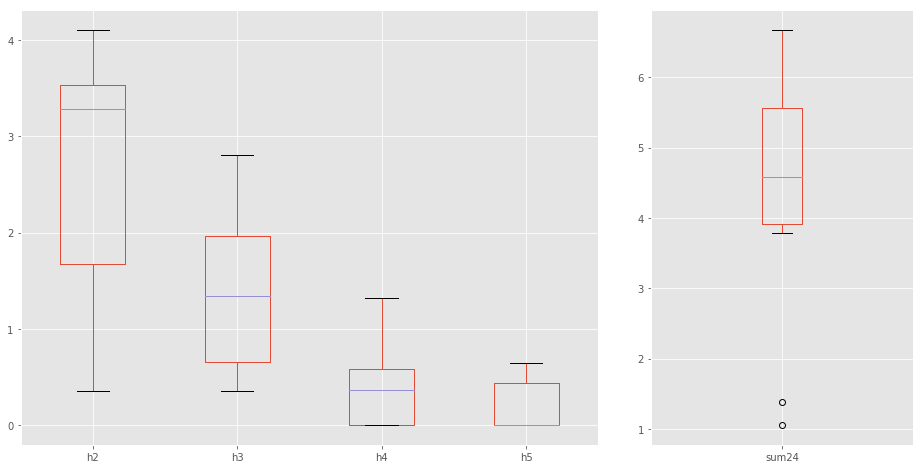

### Results for Def End

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,5.807219,3.717476,1.177713,0.579126,11.619334
Median,8.168285,5.058782,1.901631,0.695253,16.190920
75 Percentile,10.177267,5.895922,2.593234,1.545041,18.210556


##### Box Plots

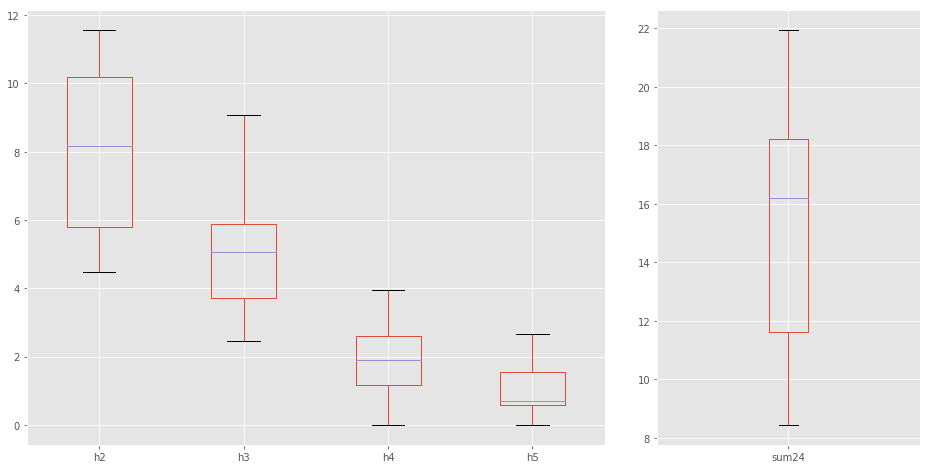

### Results for Def Tackle

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.281990,0.409538,0.000000,0.0,3.101066
Median,4.124510,1.667329,0.616825,0.0,7.612676
75 Percentile,6.814839,6.619614,0.923714,0.0,15.454994


##### Box Plots

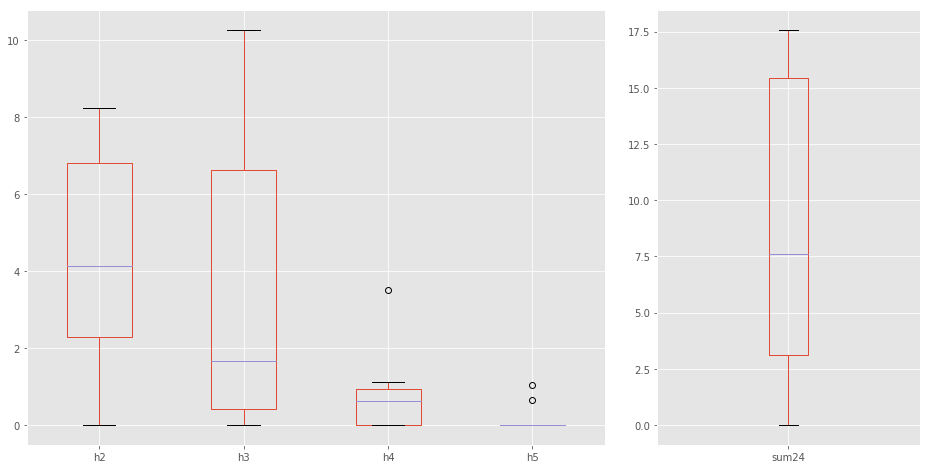

### Results for Linebacker

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,4.984529,4.001884,1.027354,0.743478,10.760243
Median,6.011646,4.597739,1.660197,1.227612,12.332701
75 Percentile,7.056942,6.671002,2.178200,1.787478,17.365511


##### Box Plots

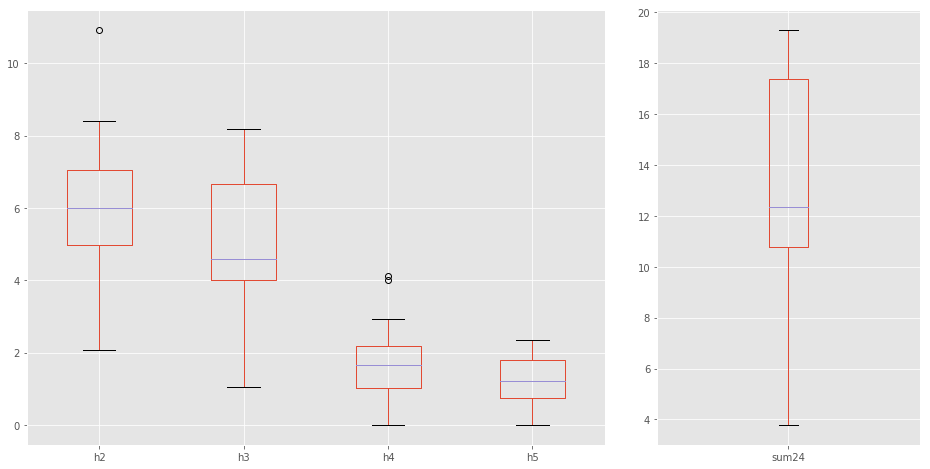

### Results for Off Guard

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,4.531831,2.068830,0.000000,0.0,7.408728
Median,5.914515,2.806154,0.472480,0.0,10.077424
75 Percentile,7.139310,3.907434,0.966491,0.0,11.341986


##### Box Plots

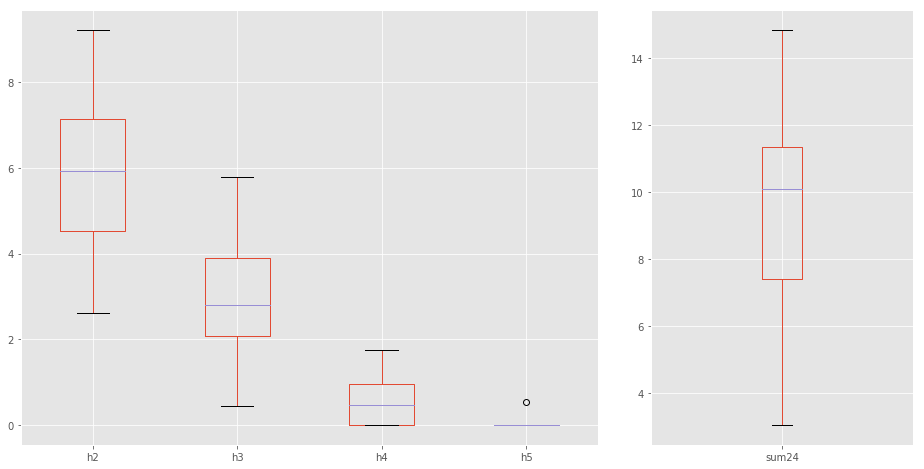

### Results for Off Tackle

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.643183,1.094961,0.000000,0.0,2.609673
Median,5.964365,2.608358,0.204527,0.0,9.968617
75 Percentile,8.294094,5.092841,0.586024,0.0,14.532806


##### Box Plots

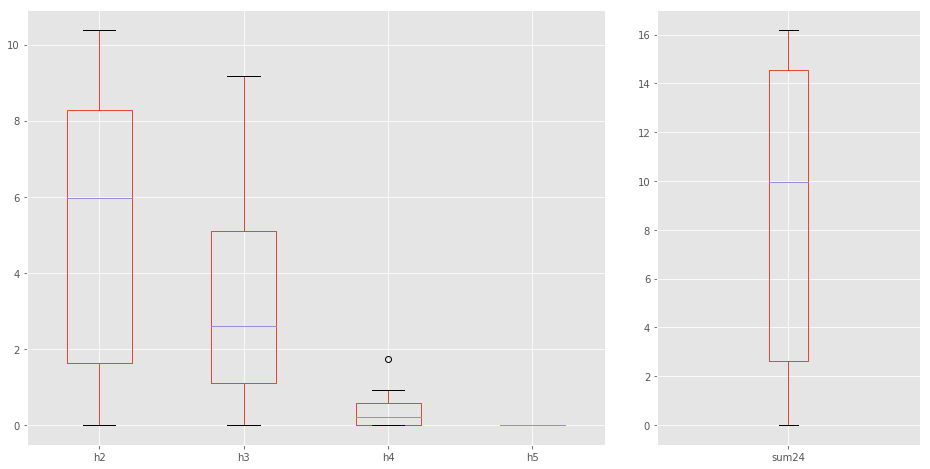

### Results for Running Back

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,7.302373,6.291983,1.722995,1.021629,16.728417
Median,10.529278,8.924031,4.464770,1.690962,27.187249
75 Percentile,13.228701,11.675913,6.092695,2.197416,31.842326


##### Box Plots

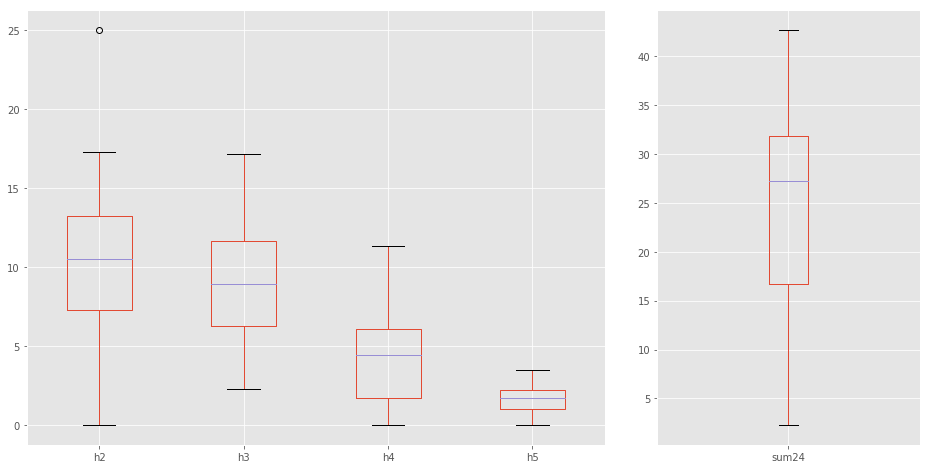

### Results for Safety

  Number of Data Points: 5


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.514005,1.285898,0.546050,0.000000,5.786541
Median,2.108716,2.184201,0.585252,0.000000,6.326148
75 Percentile,3.822352,3.514527,0.702905,0.757002,6.552603


##### Box Plots

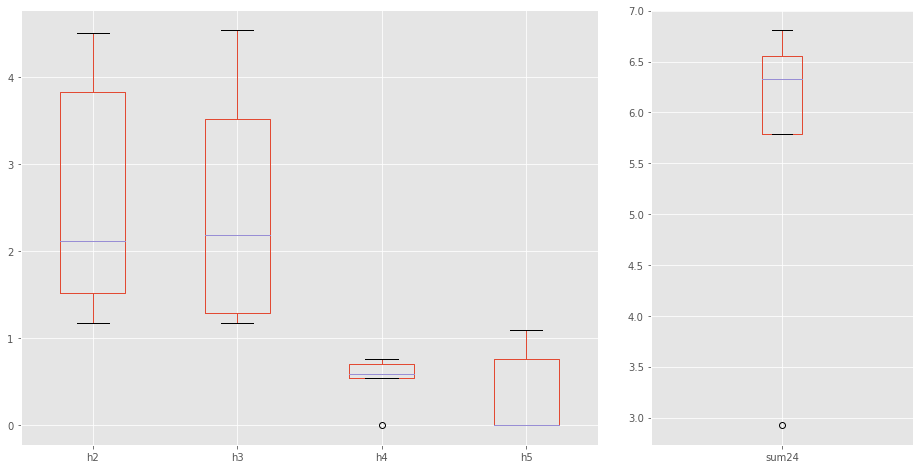

### Results for Tight End

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,3.098941,3.482638,1.047365,0.000000,8.033832
Median,4.861664,4.540571,1.850866,0.409054,13.367708
75 Percentile,7.052740,6.546005,3.004348,1.146616,18.031262


##### Box Plots

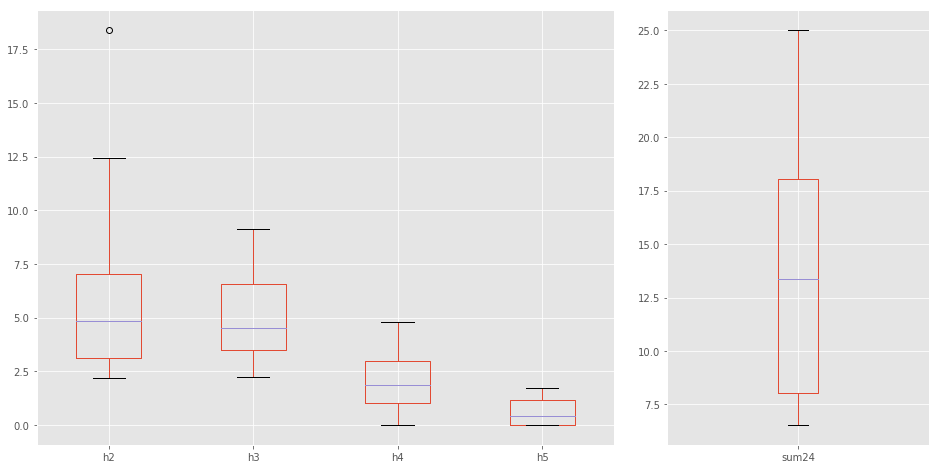

### Results for Wide Receiver

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.094961,0.504193,0.000000,0.000000,2.189922
Median,2.738308,0.909283,0.000000,0.000000,3.582902
75 Percentile,5.855871,1.463968,0.428544,0.108885,7.470880


##### Box Plots

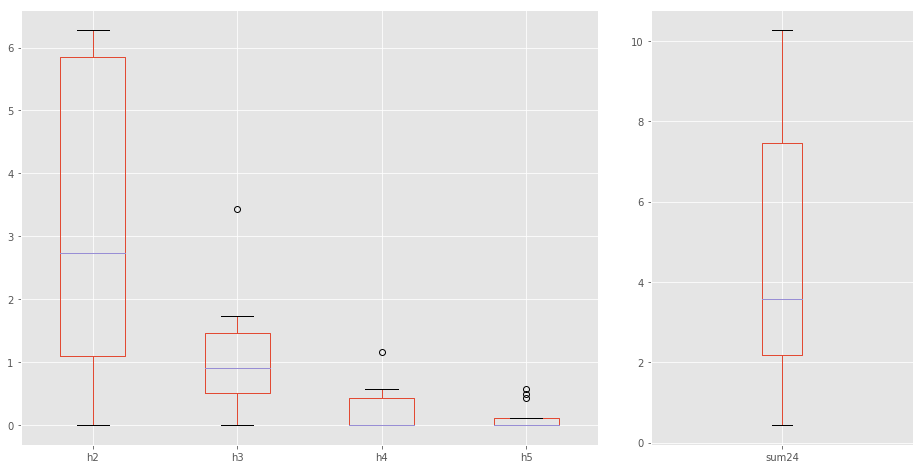

In [8]:
for name, grp in grps:
    printmd('### Results for {}'.format(name.title()))
    print('  Number of Data Points: {}'.format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp.quantile([0.25, 0.50, 0.75])[['h2', 'h3', 'h4', 'h5', 'sum24']]
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,3), (0,0), colspan=2)
    grp[['h2', 'h3', 'h4', 'h5']].boxplot()
    plt.subplot2grid((1,3), (0,2))
    grp[['sum24']].boxplot()
    plt.show()

### Question 2: What is the exposure to hits based on player position over all practices?

The code below follows the same procedures as for games (above), but this time with the practice data. The only difference is that the median practice length is 125 minutes, so this time will be used in the data normalization.

In [9]:
practices = raw[raw.type != 'game']
practice_groups = (practices.groupby(['event', 'player'])
                            .sum()
                            .assign(sum24=lambda x: x.h2+x.h3+x.h4))
practice_groups.loc[['Conneticut #1', 'Houston #1']]

h2   h3   h4   h5  sum24
event         player                                   
Conneticut #1 def end         6.0  1.0  0.0  0.0    7.0
              def tackle      1.0  0.0  0.0  0.0    1.0
              linebacker      4.0  4.0  0.0  0.0    8.0
              off tackle      0.0  0.0  0.0  0.0    0.0
              running back    0.0  0.0  0.0  0.0    0.0
              tight end      10.0  6.0  2.0  0.0   18.0
              wide receiver   1.0  0.0  0.0  0.0    1.0
Houston #1    cornerback      1.0  0.0  0.0  0.0    1.0
              def end         4.0  0.0  0.0  1.0    4.0
              def tackle      0.0  0.0  0.0  0.0    0.0
              linebacker      5.0  2.0  0.0  0.0    7.0
              off tackle      0.0  0.0  0.0  0.0    0.0
              running back    1.0  0.0  0.0  0.0    1.0
              tight end       4.0  6.0  0.0  0.0   10.0
              wide receiver   1.0  1.0  0.0  0.0    2.0

In [10]:
grps = (practices.groupby(['event', 'day', 'player', 'pcode', 'ptype'], as_index=False)
      .sum()
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_total_duration_by_date(durs, y.day, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .assign(h2=lambda x: x.h2*125/x.plyrmnts)
      .assign(h3=lambda x: x.h3*125/x.plyrmnts)
      .assign(h4=lambda x: x.h4*125/x.plyrmnts)
      .assign(h5=lambda x: x.h5*125/x.plyrmnts)
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .groupby(['player']))
grps.aggregate(np.median)[['h2', 'h3', 'h4', 'h5', 'sum24']]

,h2,h3,h4,h5,sum24
player,,,,,
cornerback,0.506148,0.000000,0.000000,0.0,0.738577
def end,1.968504,0.919118,0.000000,0.0,3.348214
def tackle,0.767756,0.000000,0.000000,0.0,0.984252
linebacker,1.500000,0.512295,0.000000,0.0,2.297794
off guard,1.506243,0.000000,0.000000,0.0,1.829117
off tackle,0.851145,0.000000,0.000000,0.0,0.992063
running back,1.000000,0.496032,0.000000,0.0,1.488095
safety,0.481025,0.409354,0.000000,0.0,0.936448
tight end,2.819549,1.984127,0.534188,0.0,6.448413


### Results for Cornerback

  Number of Data Points: 38


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.107021,0.000000,0.0,0.0,0.459559
Median,0.506148,0.000000,0.0,0.0,0.738577
75 Percentile,1.353346,0.487466,0.0,0.0,1.531285


##### Box Plots

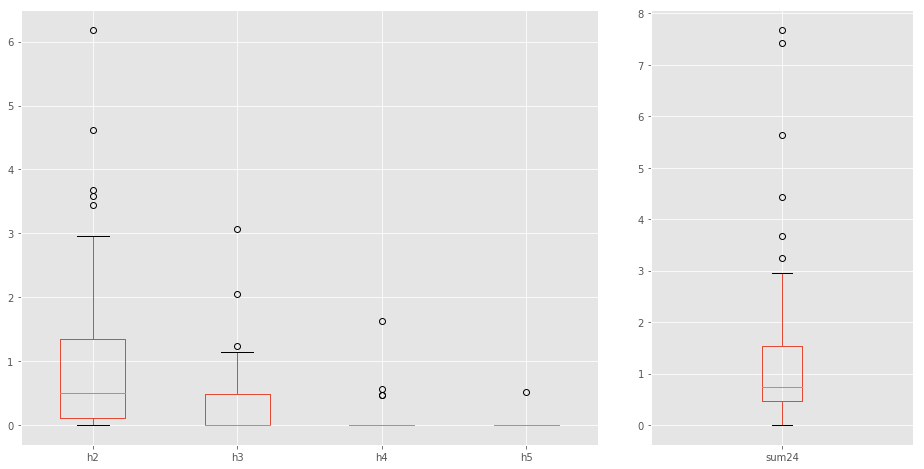

### Results for Def End

  Number of Data Points: 51


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.004421,0.475292,0.000000,0.000000,1.968504
Median,1.968504,0.919118,0.000000,0.000000,3.348214
75 Percentile,4.087148,2.689865,0.919118,0.492126,6.278670


##### Box Plots

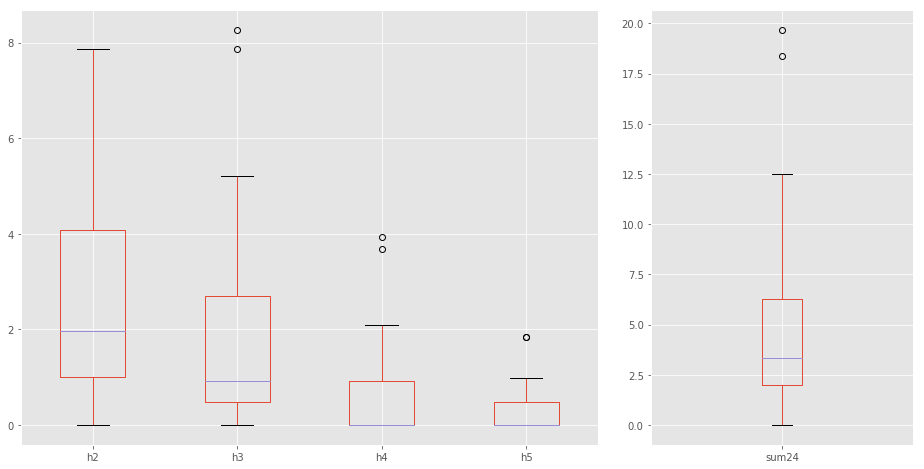

### Results for Def Tackle

  Number of Data Points: 50


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.767756,0.000000,0.0,0.0,0.984252
75 Percentile,1.873624,0.462112,0.0,0.0,1.992126


##### Box Plots

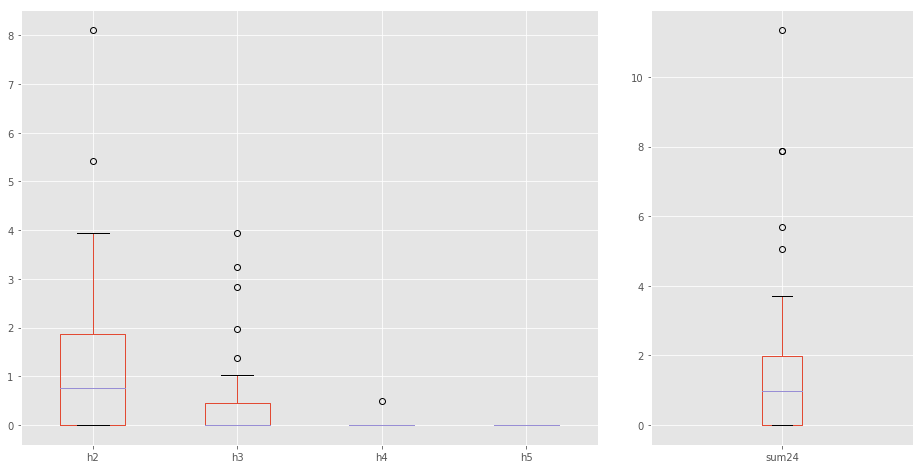

### Results for Linebacker

  Number of Data Points: 55


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.714779,0.000000,0.0,0.0,1.024590
Median,1.500000,0.512295,0.0,0.0,2.297794
75 Percentile,2.460630,0.984252,0.0,0.0,3.676471


##### Box Plots

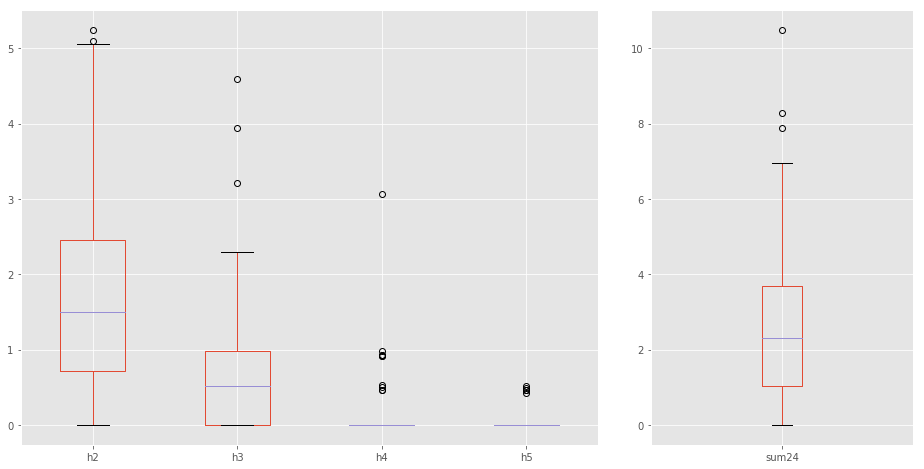

### Results for Off Guard

  Number of Data Points: 42


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.788860,0.00000,0.0,0.0,1.041887
Median,1.506243,0.00000,0.0,0.0,1.829117
75 Percentile,2.480159,0.64902,0.0,0.0,3.472222


##### Box Plots

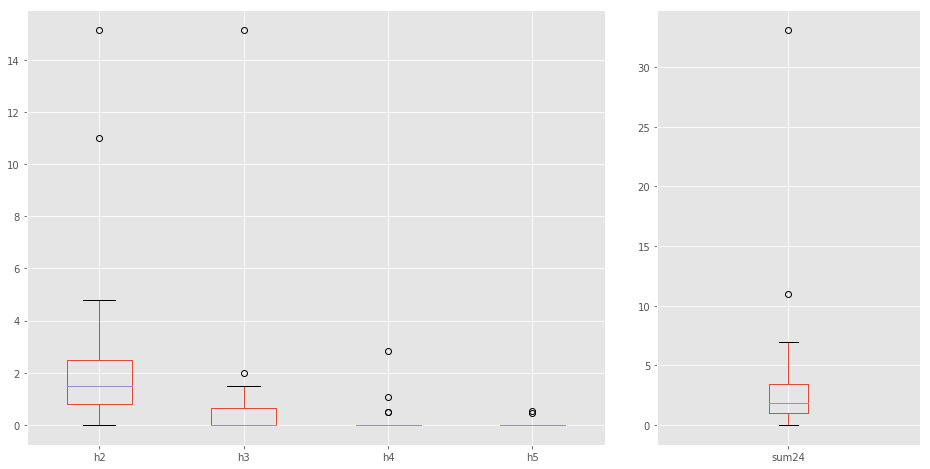

### Results for Off Tackle

  Number of Data Points: 46


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.118371
Median,0.851145,0.000000,0.0,0.0,0.992063
75 Percentile,1.500000,0.496032,0.0,0.0,1.984127


##### Box Plots

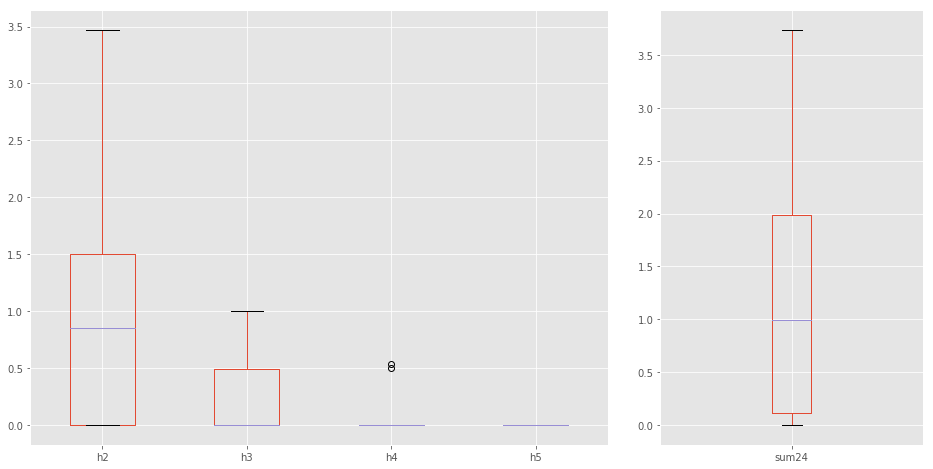

### Results for Running Back

  Number of Data Points: 39


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.626853
Median,1.000000,0.496032,0.0,0.0,1.488095
75 Percentile,1.582532,1.000000,0.0,0.0,2.510405


##### Box Plots

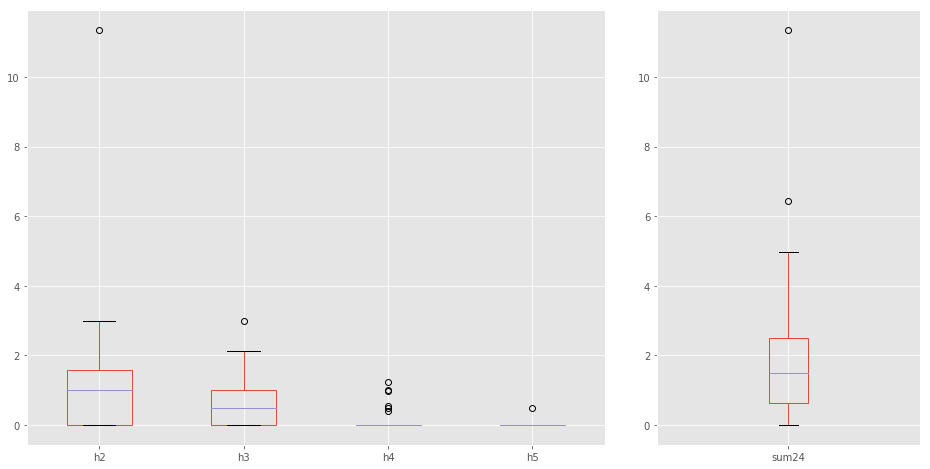

### Results for Safety

  Number of Data Points: 28


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.321062,0.000000,0.0,0.0,0.634511
Median,0.481025,0.409354,0.0,0.0,0.936448
75 Percentile,0.984252,0.919118,0.0,0.0,1.838235


##### Box Plots

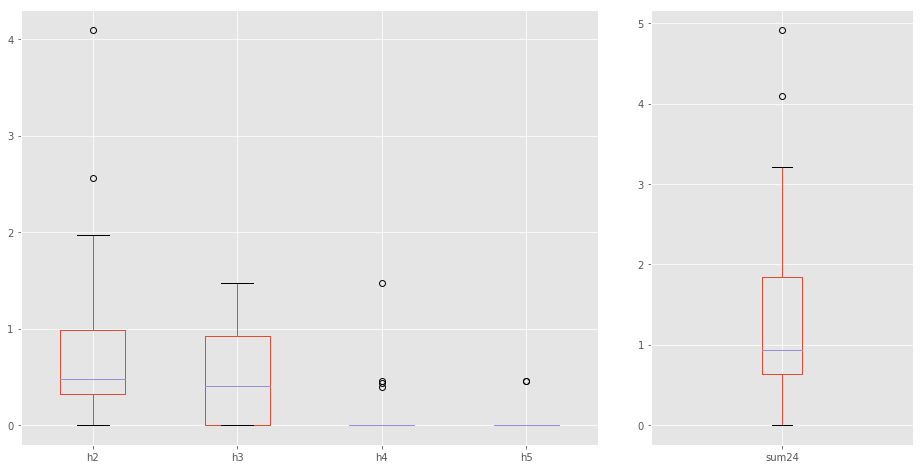

### Results for Tight End

  Number of Data Points: 53


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.623377,1.016260,0.000000,0.000000,3.205128
Median,2.819549,1.984127,0.534188,0.000000,6.448413
75 Percentile,3.968254,3.246753,1.068376,0.558036,8.547009


##### Box Plots

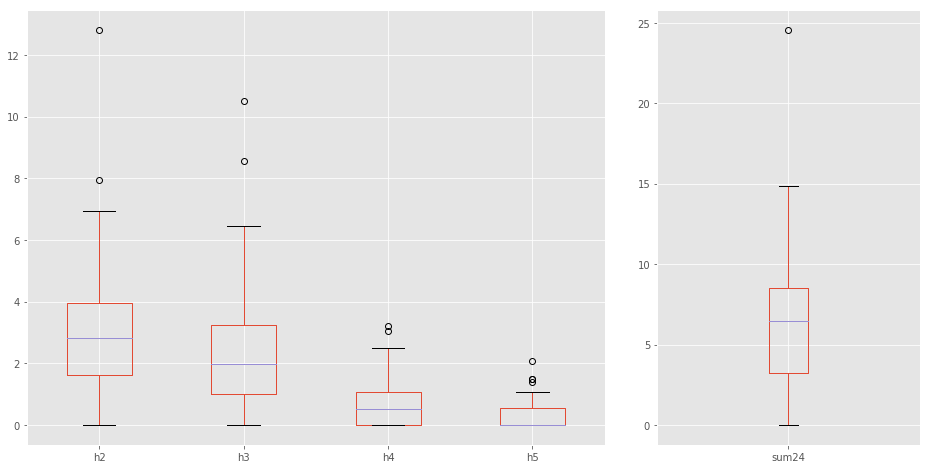

### Results for Wide Receiver

  Number of Data Points: 33


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.500000,0.000000,0.0,0.0,0.534188
75 Percentile,1.068376,0.534188,0.0,0.0,1.500000


##### Box Plots

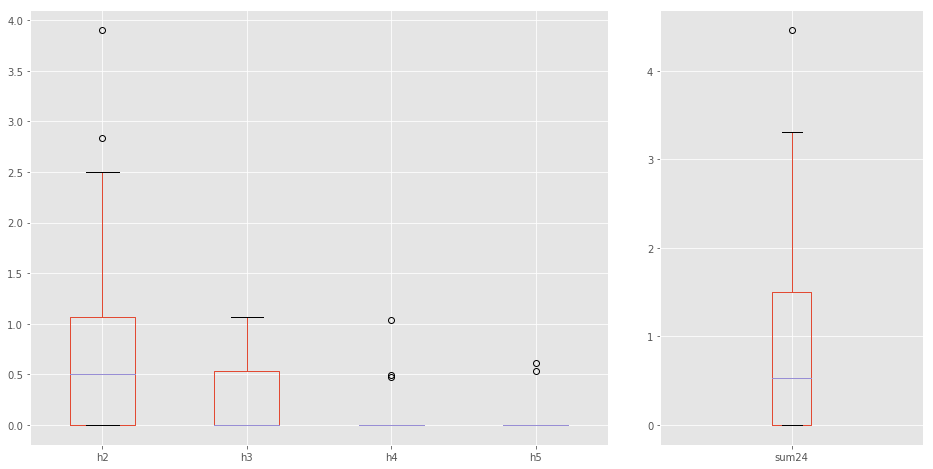

In [11]:
for name, grp in grps:
    printmd('### Results for {}'.format(name.title()))
    print('  Number of Data Points: {}'.format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp.quantile([0.25, 0.50, 0.75])[['h2', 'h3', 'h4', 'h5', 'sum24']]
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,3), (0,0), colspan=2)
    grp[['h2', 'h3', 'h4', 'h5']].boxplot()
    plt.subplot2grid((1,3), (0,2))
    grp[['sum24']].boxplot()
    plt.show()

### Question 3: What is the exposure to hits based on player position by practice type?

Again, the procedure is similar. First, we'll used the data that is normalized by the number of players in a given position and only include practice data.

Next, we'll group the data by practice type (tuesday, wednedsay, camp, etc) and player position then sum the hit data. As before, a sample of the data is below.

In [12]:
grps = (practices.groupby(['type', 'player', 'pcode', 'ptype', 'day'], as_index=False)
      .sum()
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_total_duration_by_date(durs, y.day, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .assign(h2=lambda x: x.h2*125/x.plyrmnts)
      .assign(h3=lambda x: x.h3*125/x.plyrmnts)
      .assign(h4=lambda x: x.h4*125/x.plyrmnts)
      .assign(h5=lambda x: x.h5*125/x.plyrmnts)
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .groupby(['player', 'type']))
grps.aggregate(np.median)[['h2', 'h3', 'h4', 'h5', 'sum24']]

h2        h3        h4        h5     sum24
player        type                                                       
cornerback    camp       0.459559  0.000000  0.000000  0.000000  0.459559
              scrimmage  0.000000  0.000000  0.000000  0.000000  0.000000
              thurs      0.512295  0.473485  0.000000  0.000000  0.558036
              tues       0.969225  0.000000  0.000000  0.000000  1.065520
              wed        0.462963  0.000000  0.000000  0.000000  0.492126
              wed/thurs  1.623377  0.000000  0.000000  0.000000  3.246753
def end       camp       3.676471  2.622378  0.856164  0.000000  5.514706
              scrimmage  1.953125  1.171875  0.000000  0.000000  3.125000
              thurs      0.512295  0.000000  0.000000  0.000000  0.946970
              tues       2.385496  0.500000  0.000000  0.492126  3.712871
              wed        1.968504  0.939850  0.469925  0.000000  2.952756
              wed/thurs  2.840909  1.623377  0.000000  0.000000  4.289216
def tackle    camp       0.459559  0.000000  0.000000  0.000000  0.856164
              scrimmage  1.065341  0.355114  0.000000  0.000000  1.420455
              thurs      0.512295  0.000000  0.000000  0.000000  0.512295
              tues       0.954198  0.000000  0.000000  0.000000  0.954198
              wed        0.984252  0.000000  0.000000  0.000000  0.984252
              wed/thurs  2.450980  0.000000  0.000000  0.000000  2.450980
linebacker    camp       2.297794  0.919118  0.000000  0.000000  3.676471
              scrimmage  2.663352  0.941051  0.000000  0.000000  3.604403
              thurs      0.558036  0.000000  0.000000  0.000000  0.558036
              tues       1.500000  0.618812  0.000000  0.000000  2.118644
              wed        1.968504  0.925926  0.000000  0.000000  2.952756
              wed/thurs  1.704545  0.000000  0.000000  0.000000  2.435065
off guard     camp       1.984127  0.496032  0.000000  0.000000  2.480159
              scrimmage  0.745739  0.195312  0.000000  0.000000  0.941051
              thurs      1.577057  0.558036  0.000000  0.000000  2.195749
              tues       1.068376  0.000000  0.000000  0.000000  1.068376
              wed        2.262195  0.000000  0.000000  0.000000  2.540650
              wed/thurs  0.811688  0.000000  0.000000  0.000000  0.811688
off tackle    camp       1.448935  0.000000  0.000000  0.000000  1.488095
              scrimmage  0.355114  0.000000  0.000000  0.000000  0.355114
              thurs      0.558036  0.000000  0.000000  0.000000  0.558036
              tues       0.000000  0.000000  0.000000  0.000000  0.534188
              wed        1.500000  0.000000  0.000000  0.000000  1.500000
              wed/thurs  1.225490  0.000000  0.000000  0.000000  1.225490
running back  camp       1.736111  0.965957  0.000000  0.000000  2.480159
              scrimmage  1.136364  0.390625  0.195312  0.000000  1.722301
              thurs      0.558036  0.000000  0.000000  0.000000  0.558036
              tues       0.000000  0.000000  0.000000  0.000000  1.033058
              wed        1.000000  1.000000  0.000000  0.000000  2.000000
              wed/thurs  0.000000  0.000000  1.225490  0.000000  1.225490
safety        camp       0.459559  0.919118  0.000000  0.000000  0.919118
              scrimmage  0.000000  0.390625  0.390625  0.000000  0.781250
              thurs      0.946970  0.000000  0.000000  0.000000  0.946970
              tues       0.742126  0.246063  0.000000  0.000000  0.984252
              wed        0.469925  0.000000  0.000000  0.000000  0.925926
tight end     camp       2.976190  1.984127  0.496032  0.000000  6.448413
              scrimmage  2.112926  0.390625  0.195312  0.000000  2.698864
              thurs      0.679348  0.000000  0.000000  0.000000  1.358696
              tues       3.205128  3.205128  1.068376  0.516529  8.012821
              wed        3.556911  1.500000  1.000000  0.508130  7.478632
              wed/thurs  2.450980  

### Results for Cornerback, Practice Type: Camp

  Number of Data Points: 7


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.459559,0.000000,0.0,0.0,0.459559
Median,0.459559,0.000000,0.0,0.0,0.459559
75 Percentile,0.459559,0.229779,0.0,0.0,0.689338


##### Box Plots

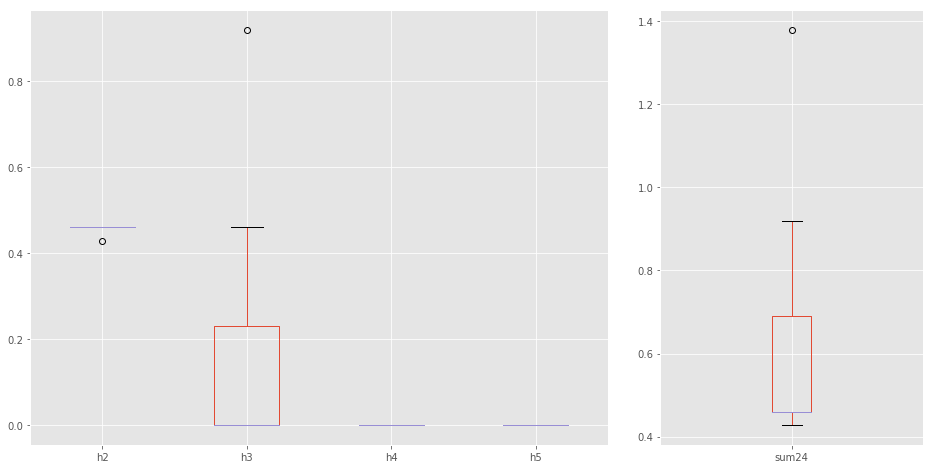

### Results for Cornerback, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

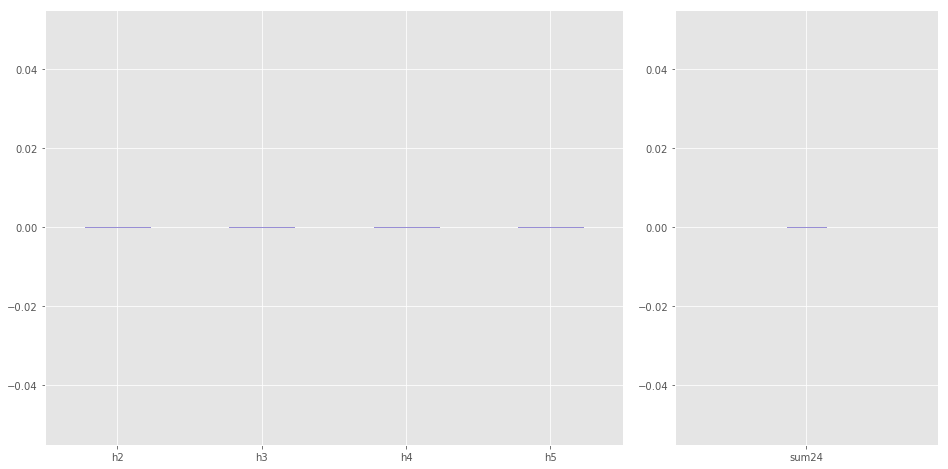

### Results for Cornerback, Practice Type: Thurs

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.512295
Median,0.512295,0.473485,0.0,0.0,0.558036
75 Percentile,1.893939,0.558036,0.0,0.0,2.840909


##### Box Plots

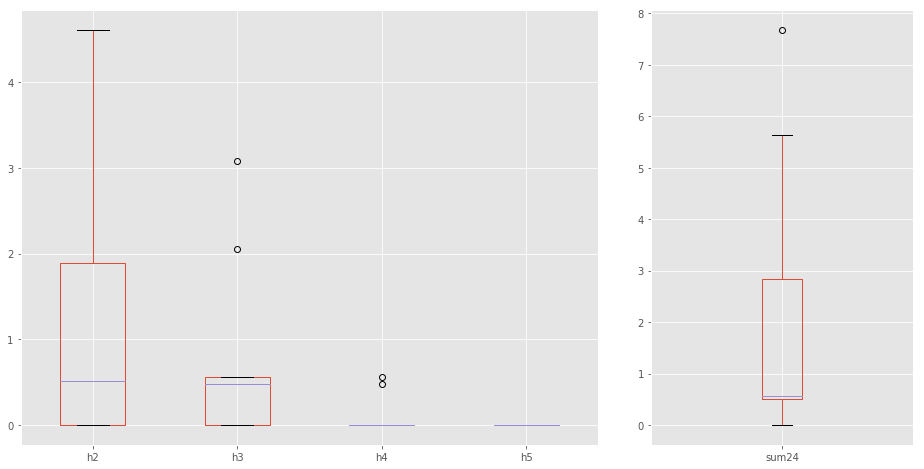

### Results for Cornerback, Practice Type: Tues

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.498031,0.000000,0.0,0.0,0.515625
Median,0.969225,0.000000,0.0,0.0,1.065520
75 Percentile,1.900379,0.615157,0.0,0.0,1.900379


##### Box Plots

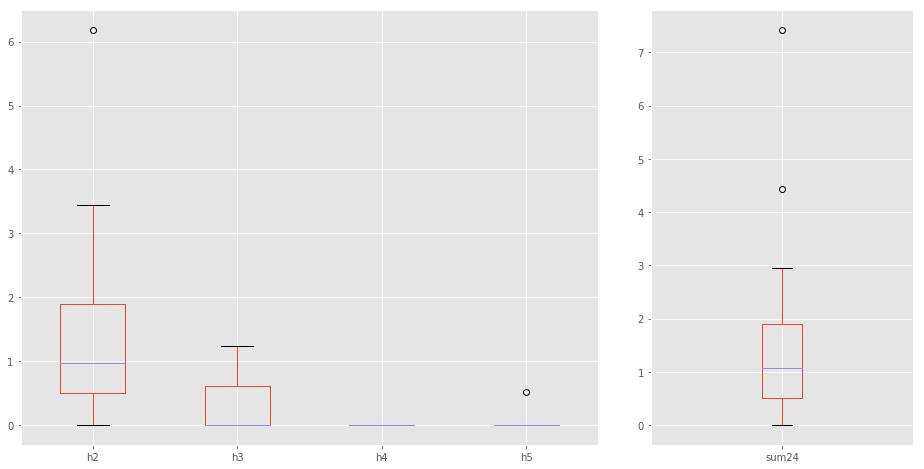

### Results for Cornerback, Practice Type: Wed

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.462963,0.0,0.0,0.0,0.492126
75 Percentile,0.969670,0.0,0.0,0.0,1.287730


##### Box Plots

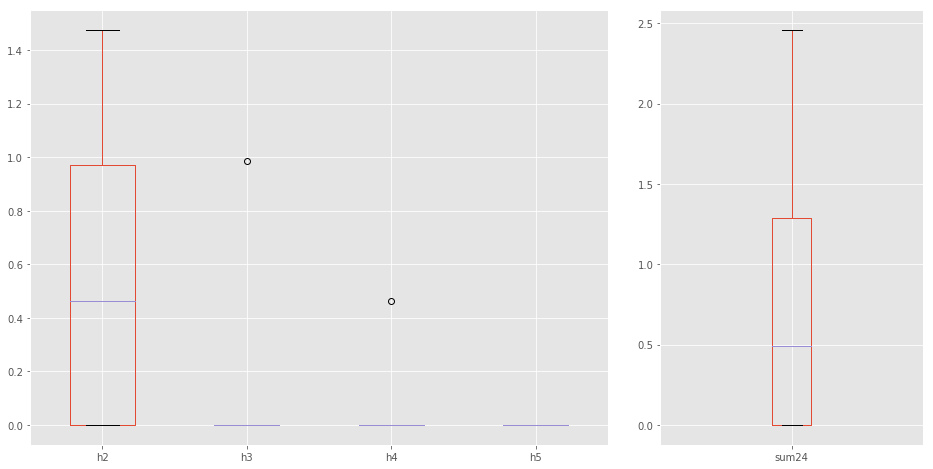

### Results for Cornerback, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.811688,0.0,0.000000,0.0,1.623377
Median,1.623377,0.0,0.000000,0.0,3.246753
75 Percentile,2.649924,0.0,0.811688,0.0,3.461612


##### Box Plots

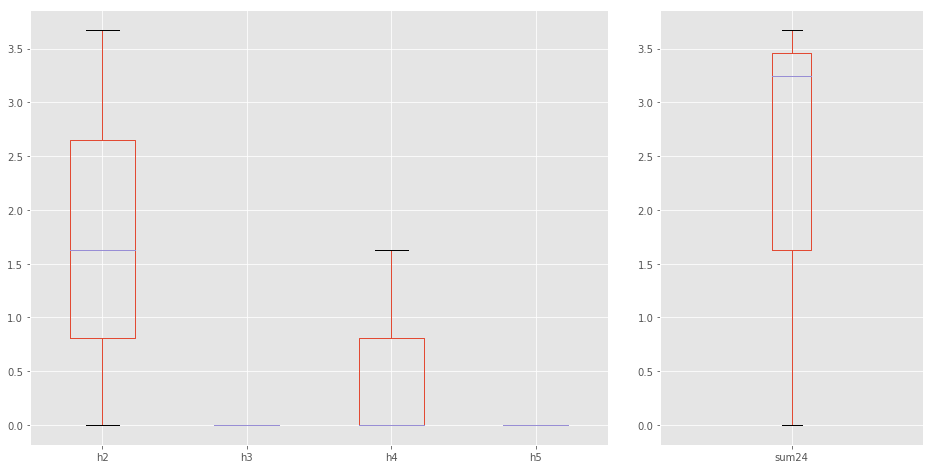

### Results for Def End, Practice Type: Camp

  Number of Data Points: 13


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.838235,0.919118,0.000000,0.000000,3.216912
Median,3.676471,2.622378,0.856164,0.000000,5.514706
75 Percentile,5.514706,3.676471,0.919118,0.919118,10.110294


##### Box Plots

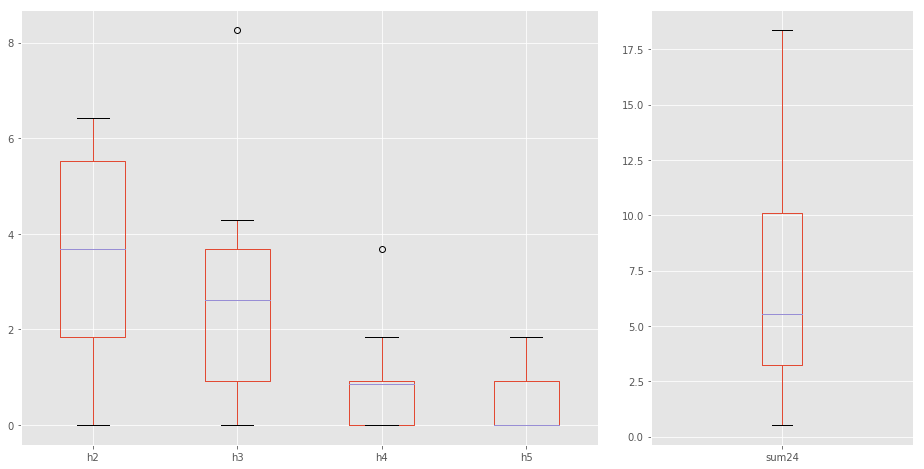

### Results for Def End, Practice Type: Scrimmage

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.976562,0.585938,0.0,0.0,1.5625
Median,1.953125,1.171875,0.0,0.0,3.1250
75 Percentile,2.929688,1.757812,0.0,0.0,4.6875


##### Box Plots

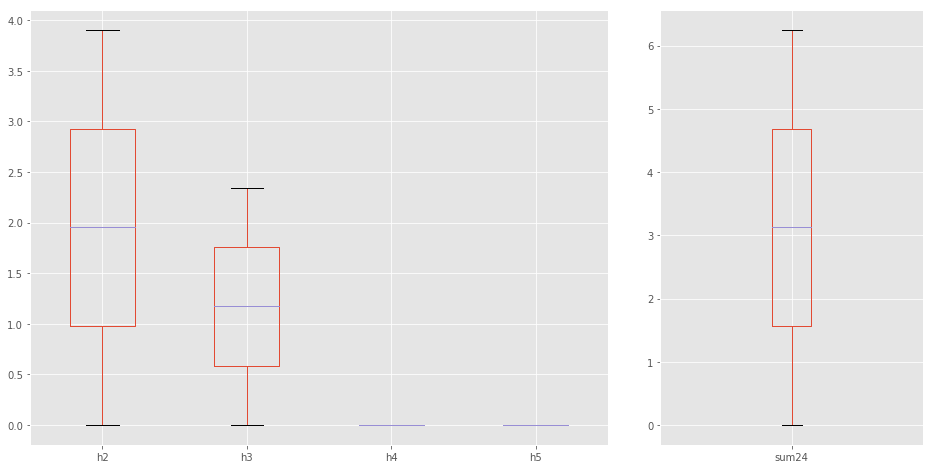

### Results for Def End, Practice Type: Thurs

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.512295,0.000000,0.0,0.0,0.946970
75 Percentile,1.024590,0.512295,0.0,0.0,2.038043


##### Box Plots

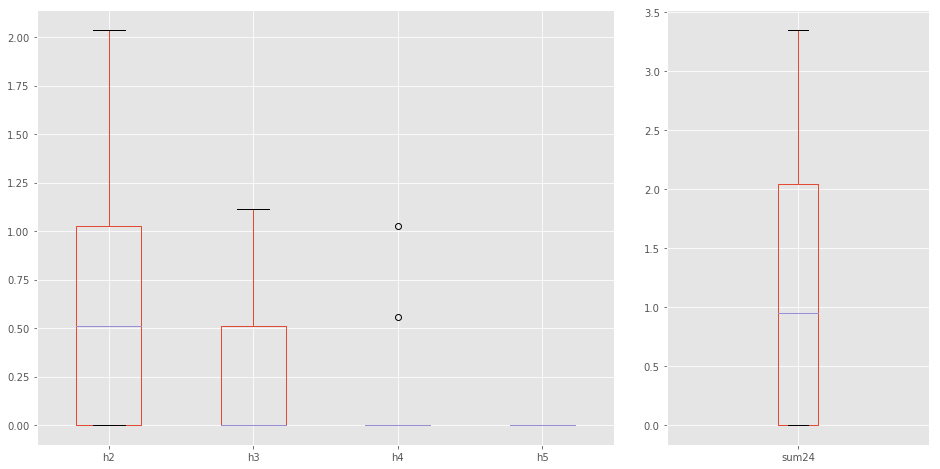

### Results for Def End, Practice Type: Tues

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.968504,0.238550,0.000000,0.000000,1.984252
Median,2.385496,0.500000,0.000000,0.492126,3.712871
75 Percentile,4.087148,3.269471,0.555469,0.544962,6.352489


##### Box Plots

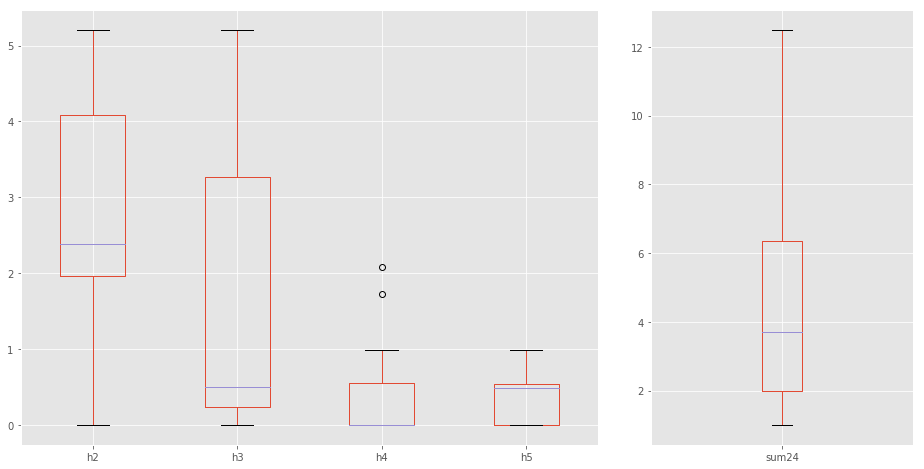

### Results for Def End, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.409774,0.492126,0.000000,0.000000,2.349624
Median,1.968504,0.939850,0.469925,0.000000,2.952756
75 Percentile,5.092593,2.314815,0.925926,0.469925,8.333333


##### Box Plots

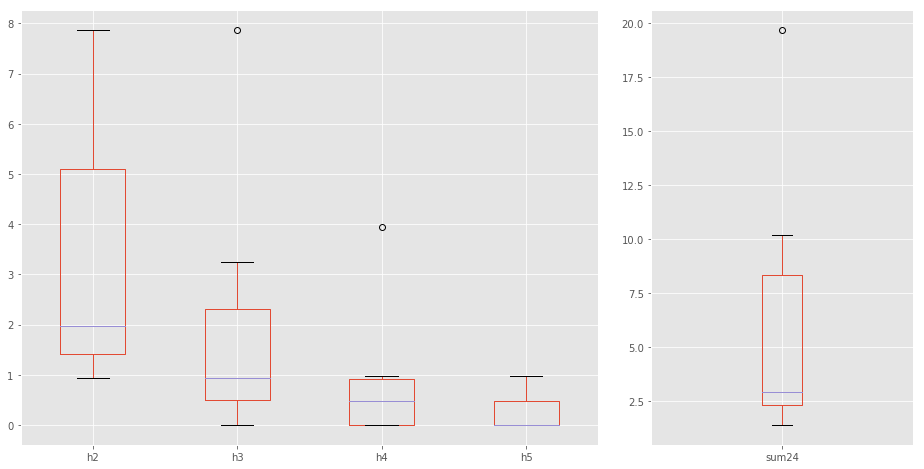

### Results for Def End, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.826299,1.118061,0.000000,0.000000,3.362140
Median,2.840909,1.623377,0.000000,0.000000,4.289216
75 Percentile,3.258690,1.948052,0.568182,0.405844,5.269608


##### Box Plots

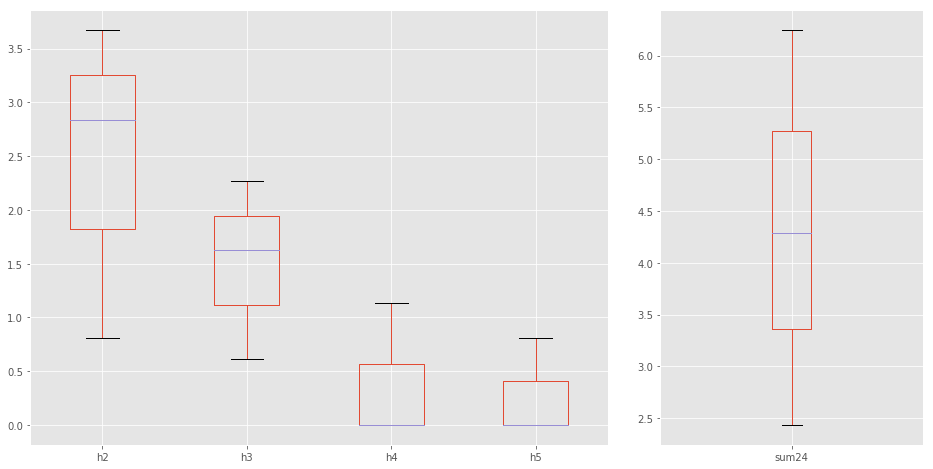

### Results for Def Tackle, Practice Type: Camp

  Number of Data Points: 13


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.459559,0.000000,0.0,0.0,0.856164
75 Percentile,1.378676,0.459559,0.0,0.0,1.378676


##### Box Plots

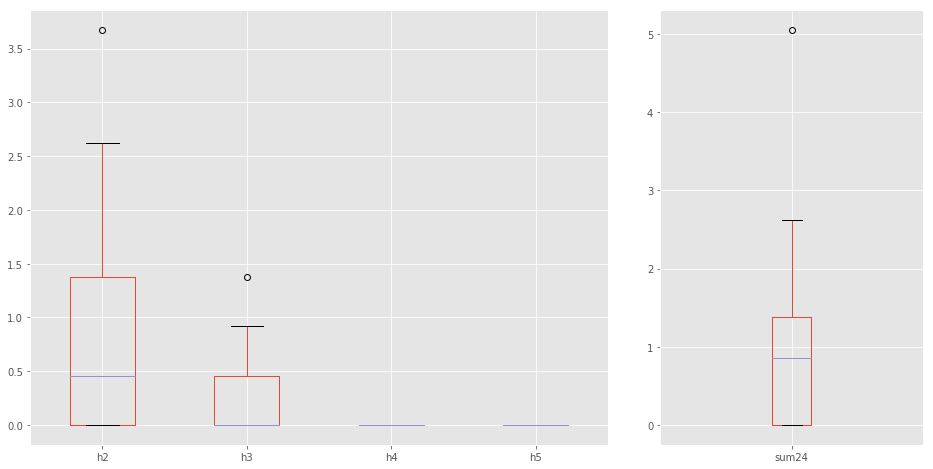

### Results for Def Tackle, Practice Type: Scrimmage

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.532670,0.177557,0.0,0.0,0.710227
Median,1.065341,0.355114,0.0,0.0,1.420455
75 Percentile,1.598011,0.532670,0.0,0.0,2.130682


##### Box Plots

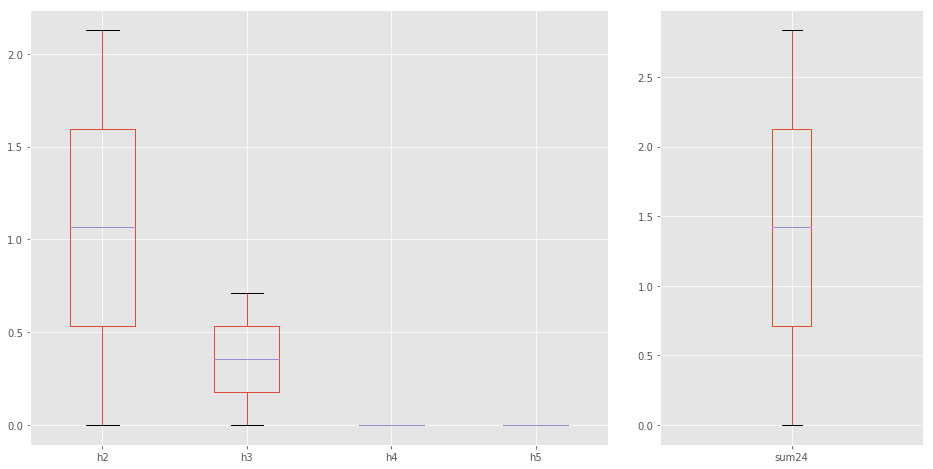

### Results for Def Tackle, Practice Type: Thurs

  Number of Data Points: 8


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.384221,0.000000,0.0,0.0,0.384221
Median,0.512295,0.000000,0.0,0.0,0.512295
75 Percentile,0.554058,0.256148,0.0,0.0,0.893732


##### Box Plots

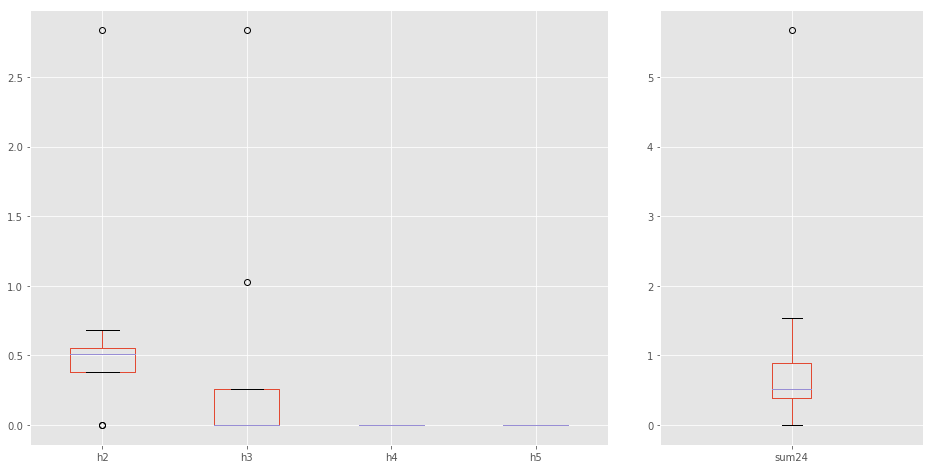

### Results for Def Tackle, Practice Type: Tues

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.00,0.0,0.0,0.000000
Median,0.954198,0.00,0.0,0.0,0.954198
75 Percentile,1.778743,0.25,0.0,0.0,1.984252


##### Box Plots

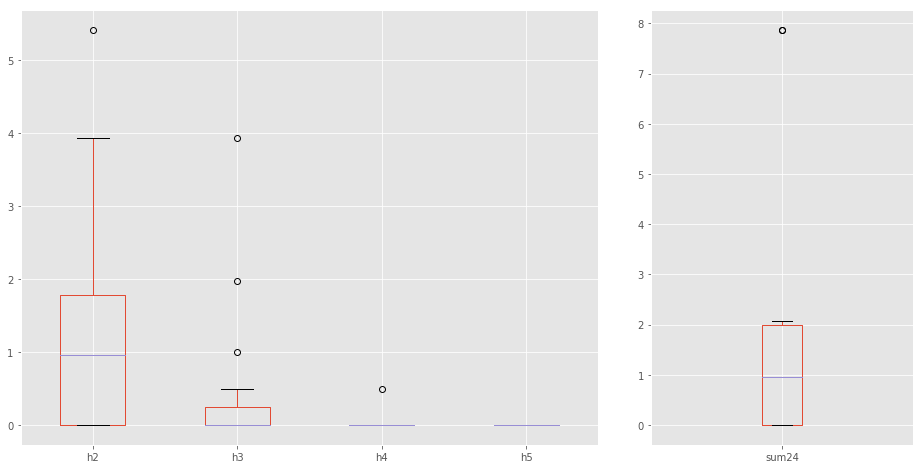

### Results for Def Tackle, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.492126,0.000000,0.0,0.0,0.984252
Median,0.984252,0.000000,0.0,0.0,0.984252
75 Percentile,1.409774,0.462963,0.0,0.0,1.476378


##### Box Plots

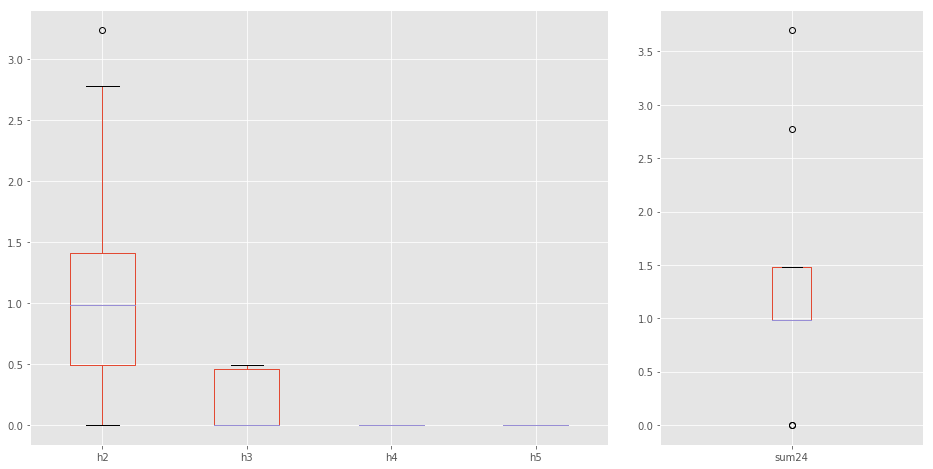

### Results for Def Tackle, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.361854,0.000000,0.0,0.0,2.361854
Median,2.450980,0.000000,0.0,0.0,2.450980
75 Percentile,5.283932,1.623377,0.0,0.0,6.907308


##### Box Plots

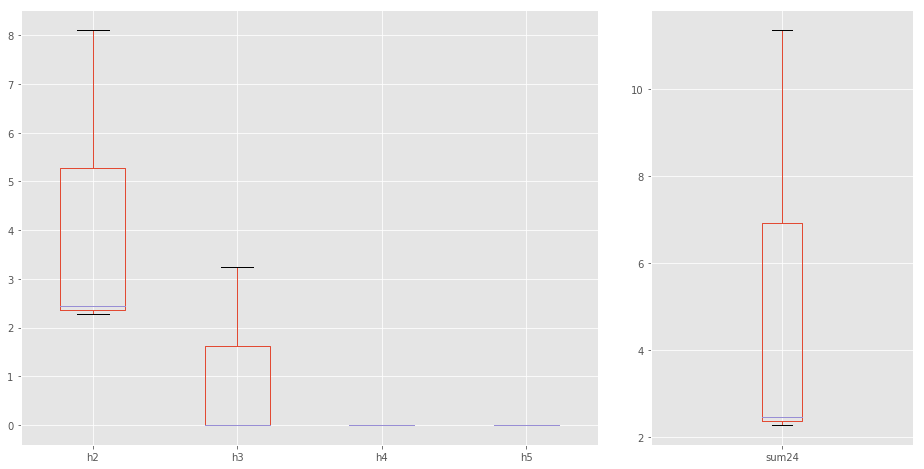

### Results for Linebacker, Practice Type: Camp

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.470588,0.459559,0.000000,0.0,2.297794
Median,2.297794,0.919118,0.000000,0.0,3.676471
75 Percentile,4.136029,1.948822,0.459559,0.0,6.204044


##### Box Plots

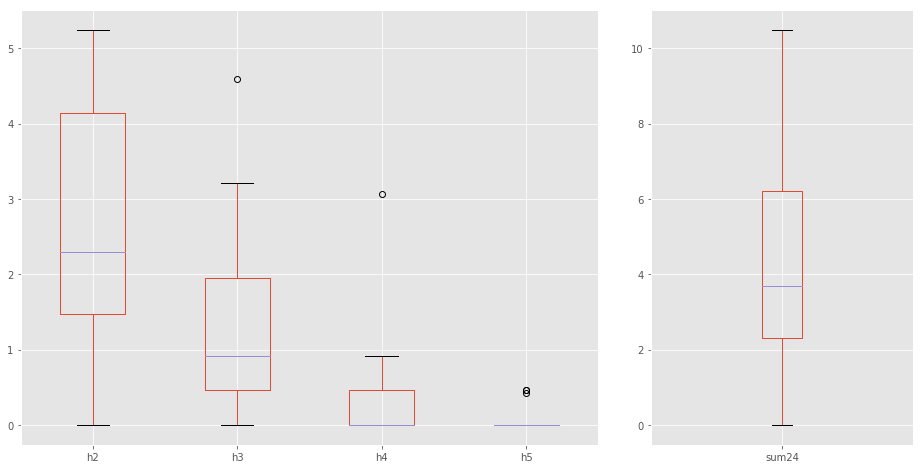

### Results for Linebacker, Practice Type: Scrimmage

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.041903,0.825639,0.0,0.0,2.867543
Median,2.663352,0.941051,0.0,0.0,3.604403
75 Percentile,3.284801,1.056463,0.0,0.0,4.341264


##### Box Plots

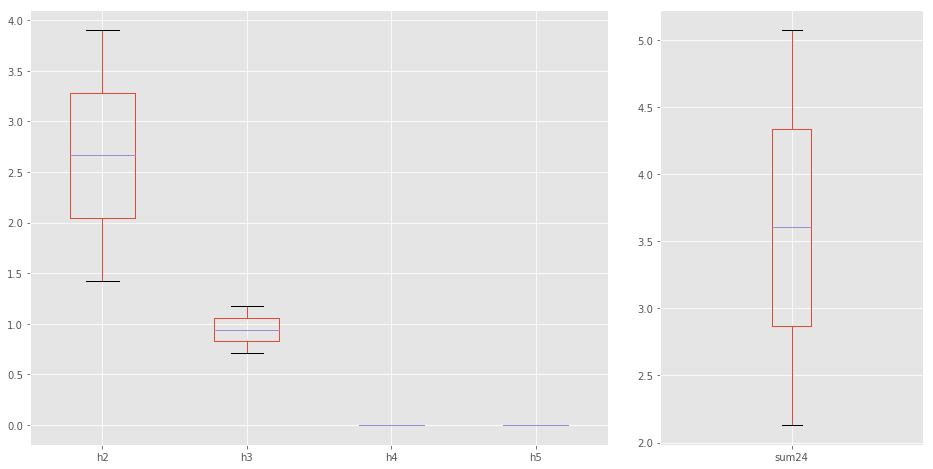

### Results for Linebacker, Practice Type: Thurs

  Number of Data Points: 11


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.512295,0.0,0.0,0.0,0.512295
Median,0.558036,0.0,0.0,0.0,0.558036
75 Percentile,1.024590,0.0,0.0,0.0,1.024590


##### Box Plots

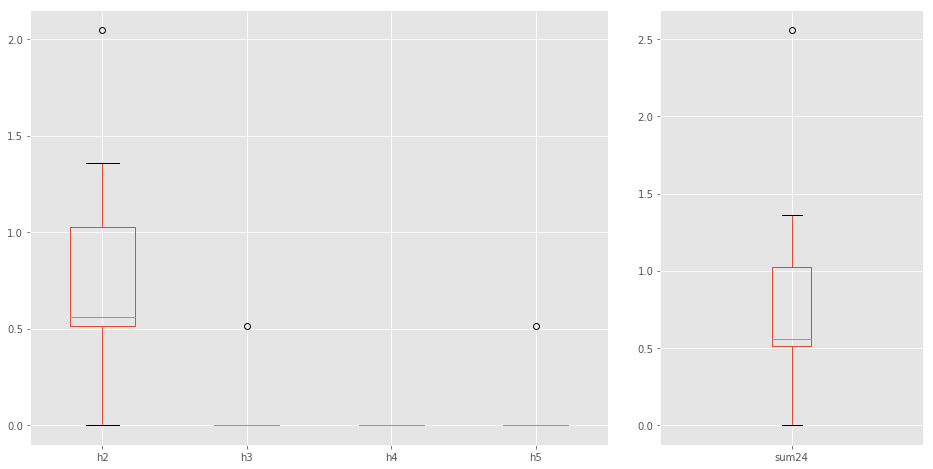

### Results for Linebacker, Practice Type: Tues

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.547114,0.000000,0.0,0.0,1.047595
Median,1.500000,0.618812,0.0,0.0,2.118644
75 Percentile,2.460630,0.992126,0.0,0.0,3.198819


##### Box Plots

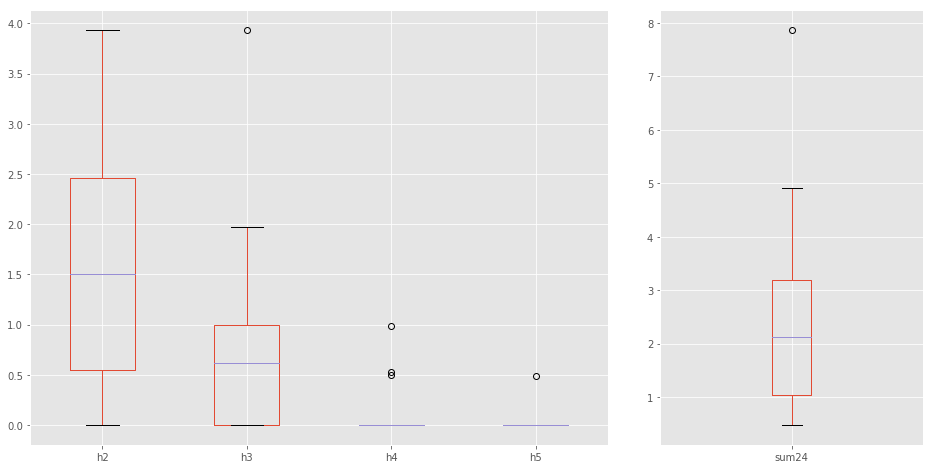

### Results for Linebacker, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.476378,0.469925,0.0,0.0,1.968504
Median,1.968504,0.925926,0.0,0.0,2.952756
75 Percentile,2.777778,0.984252,0.0,0.0,3.937008


##### Box Plots

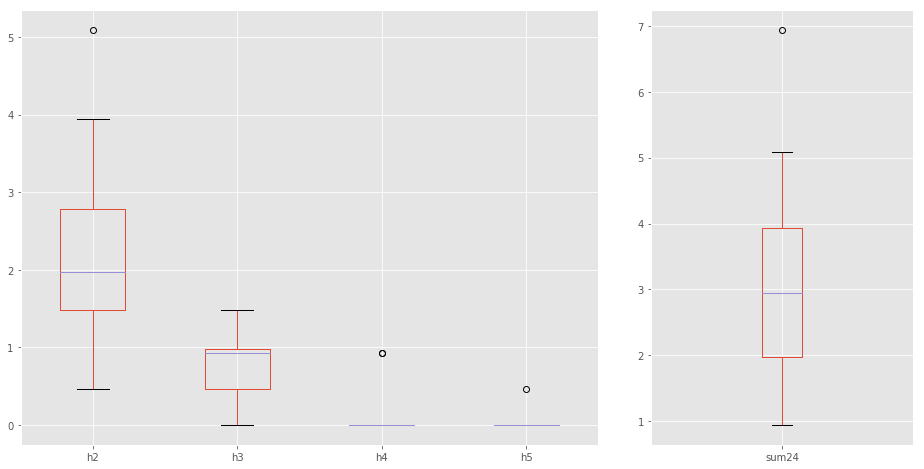

### Results for Linebacker, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.663961,0.000000,0.0,0.0,2.069805
Median,1.704545,0.000000,0.0,0.0,2.435065
75 Percentile,2.384135,0.405844,0.0,0.0,2.749395


##### Box Plots

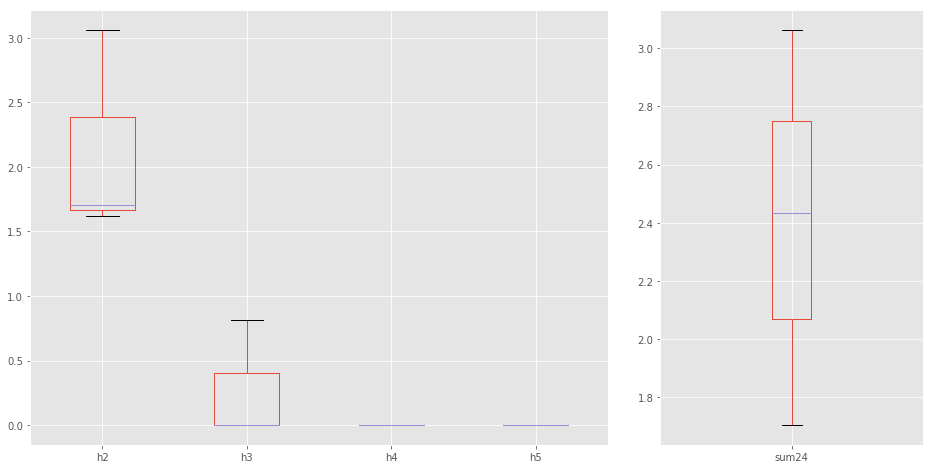

### Results for Off Guard, Practice Type: Camp

  Number of Data Points: 14


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.612103,0.124008,0.0,0.0,2.291951
Median,1.984127,0.496032,0.0,0.0,2.480159
75 Percentile,2.480159,0.992063,0.0,0.0,3.472222


##### Box Plots

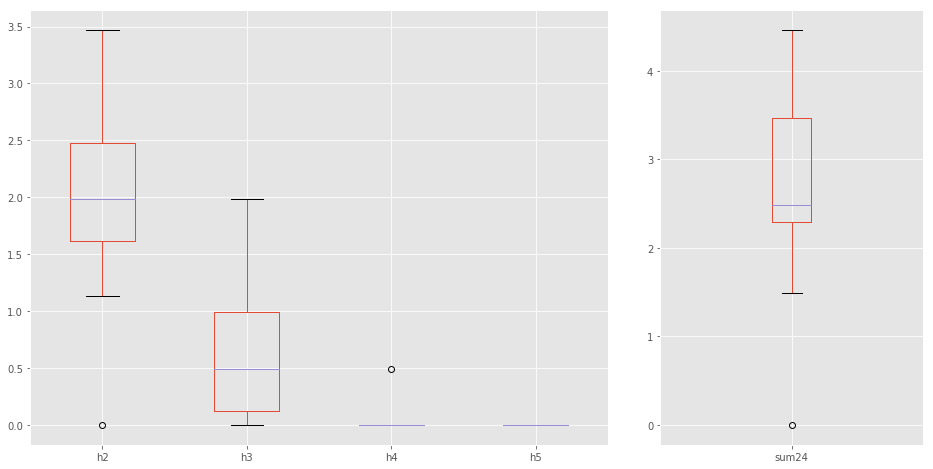

### Results for Off Guard, Practice Type: Scrimmage

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.727983,0.097656,0.0,0.0,0.825639
Median,0.745739,0.195312,0.0,0.0,0.941051
75 Percentile,0.763494,0.292969,0.0,0.0,1.056463


##### Box Plots

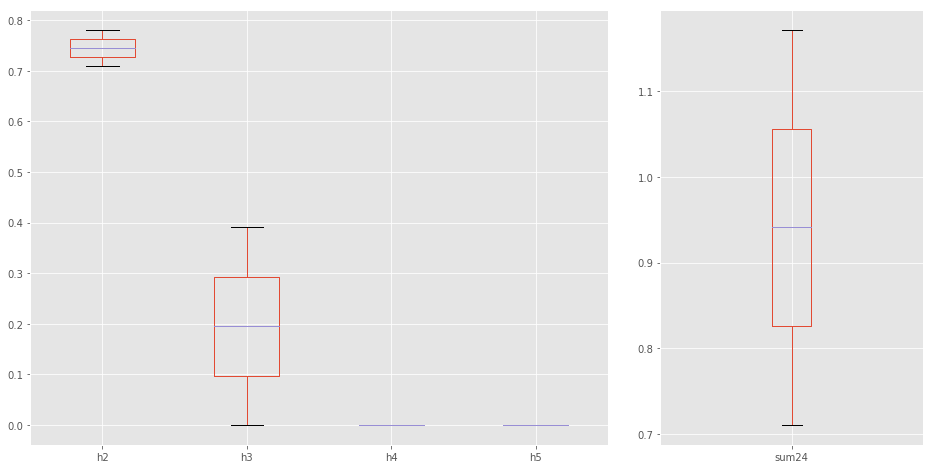

### Results for Off Guard, Practice Type: Thurs

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.116071,0.139509,0.0,0.0,1.674107
Median,1.577057,0.558036,0.0,0.0,2.195749
75 Percentile,3.020672,0.649020,0.0,0.0,3.190509


##### Box Plots

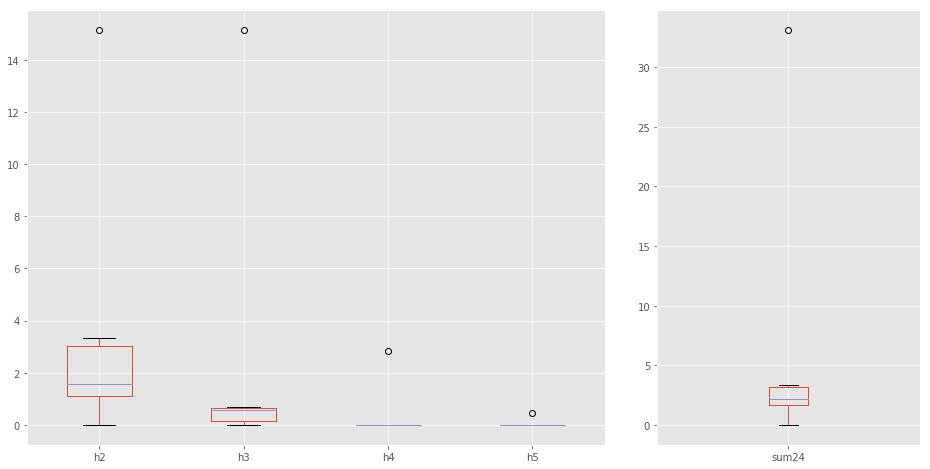

### Results for Off Guard, Practice Type: Tues

  Number of Data Points: 11


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.271739,0.000000,0.0,0.0,0.516529
Median,1.068376,0.000000,0.0,0.0,1.068376
75 Percentile,1.630435,0.805927,0.0,0.0,1.902174


##### Box Plots

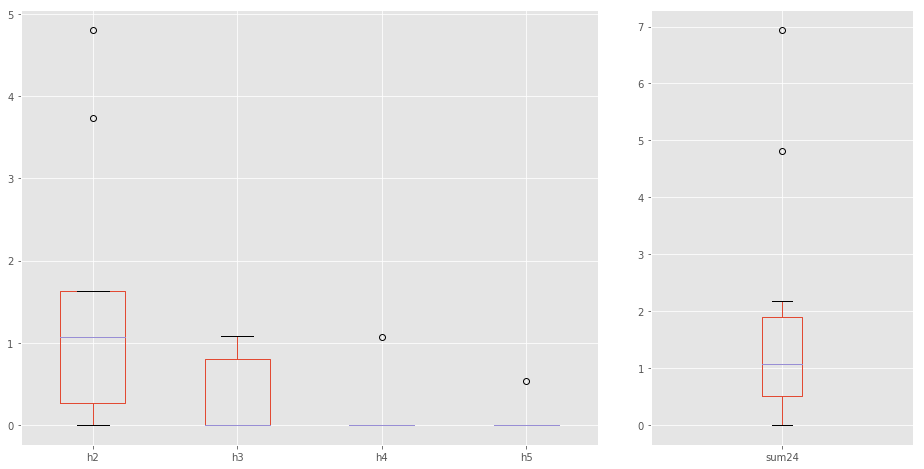

### Results for Off Guard, Practice Type: Wed

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.756098,0.0,0.0,0.0,0.756098
Median,2.262195,0.0,0.0,0.0,2.540650
75 Percentile,3.417683,0.0,0.0,0.0,4.264228


##### Box Plots

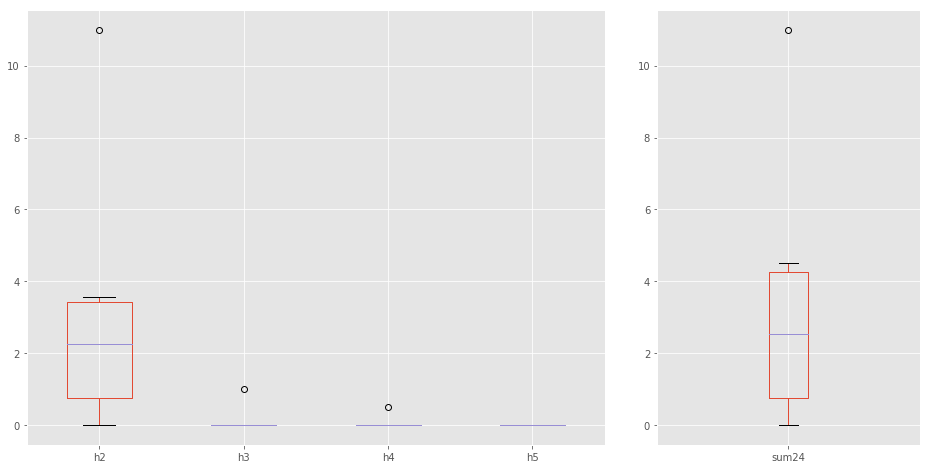

### Results for Off Guard, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.405844,0.0,0.0,0.0,0.405844
Median,0.811688,0.0,0.0,0.0,0.811688
75 Percentile,1.018589,0.0,0.0,0.0,1.018589


##### Box Plots

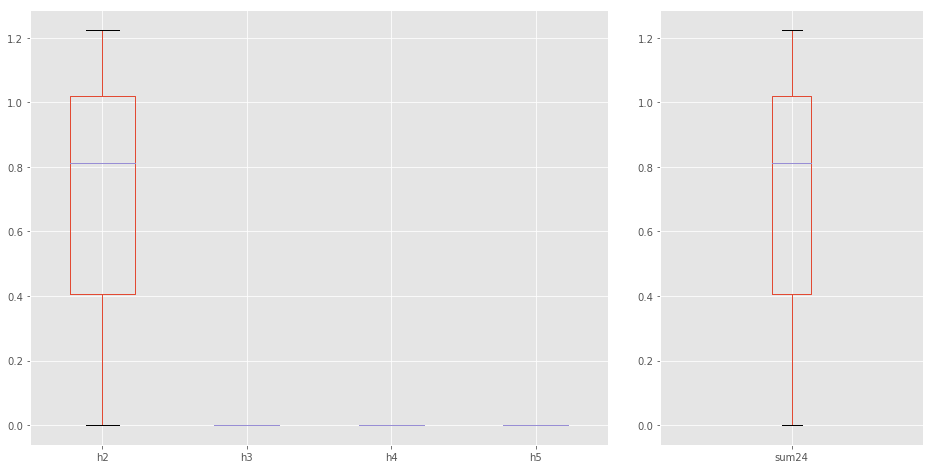

### Results for Off Tackle, Practice Type: Camp

  Number of Data Points: 14


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.992063,0.000000,0.0,0.0,0.992063
Median,1.448935,0.000000,0.0,0.0,1.488095
75 Percentile,1.860119,0.372024,0.0,0.0,2.356151


##### Box Plots

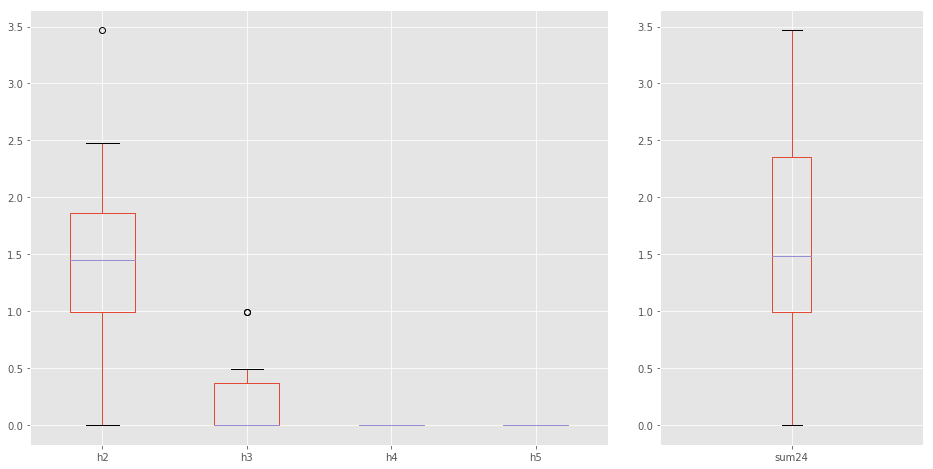

### Results for Off Tackle, Practice Type: Scrimmage

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.177557,0.0,0.0,0.0,0.177557
Median,0.355114,0.0,0.0,0.0,0.355114
75 Percentile,0.532670,0.0,0.0,0.0,0.532670


##### Box Plots

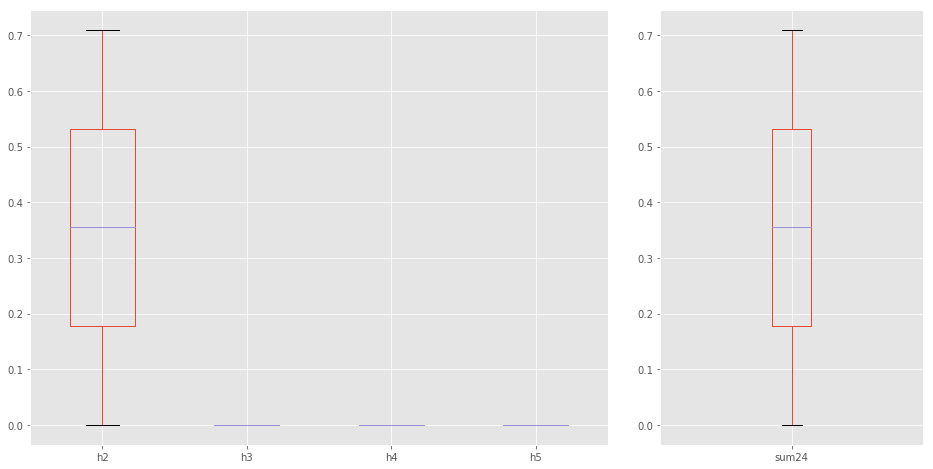

### Results for Off Tackle, Practice Type: Thurs

  Number of Data Points: 7


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.236742,0.0,0.0,0.0,0.236742
Median,0.558036,0.0,0.0,0.0,0.558036
75 Percentile,0.618692,0.0,0.0,0.0,0.618692


##### Box Plots

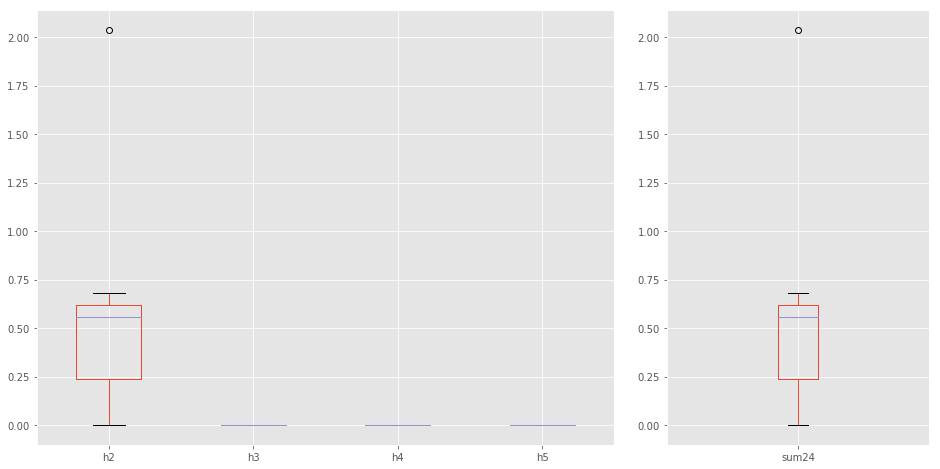

### Results for Off Tackle, Practice Type: Tues

  Number of Data Points: 13


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.000000,0.000000,0.0,0.0,0.534188
75 Percentile,0.543478,0.534188,0.0,0.0,0.543478


##### Box Plots

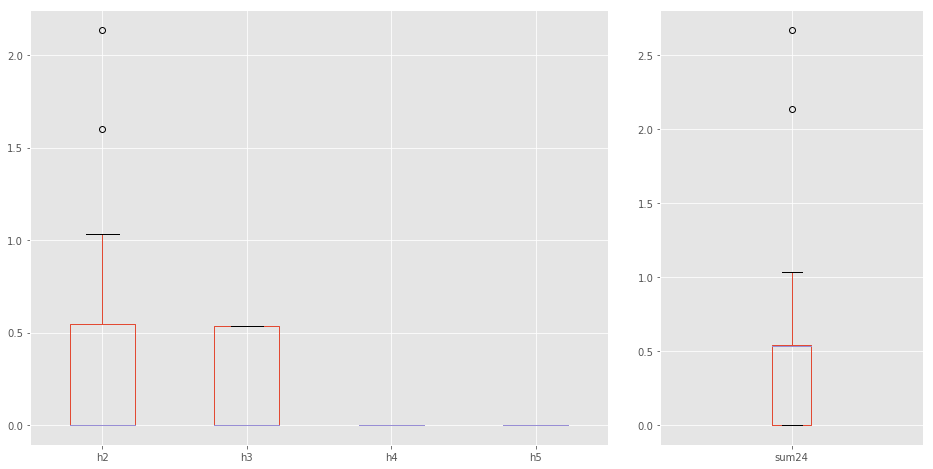

### Results for Off Tackle, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.068376,0.0,0.0,0.0,1.068376
Median,1.500000,0.0,0.0,0.0,1.500000
75 Percentile,2.000000,0.5,0.0,0.0,2.500000


##### Box Plots

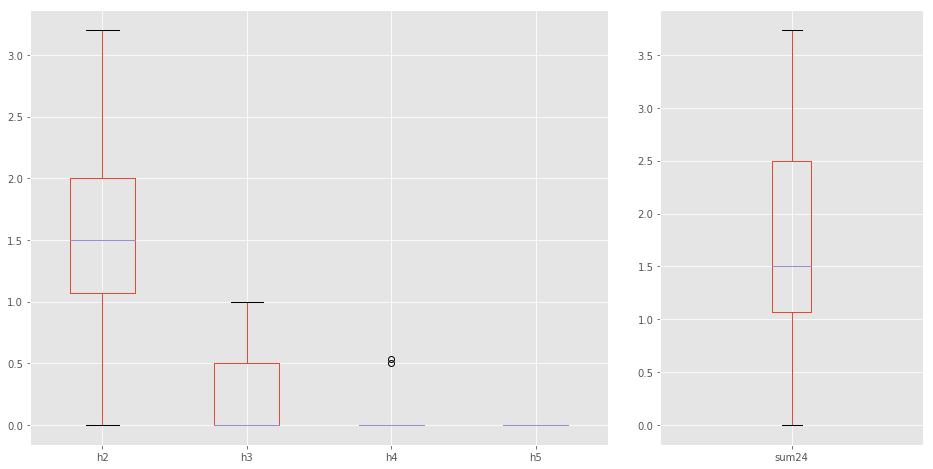

### Results for Off Tackle, Practice Type: Wed/Thurs

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.22549,0.0,0.0,0.0,1.22549
Median,1.22549,0.0,0.0,0.0,1.22549
75 Percentile,1.22549,0.0,0.0,0.0,1.22549


##### Box Plots

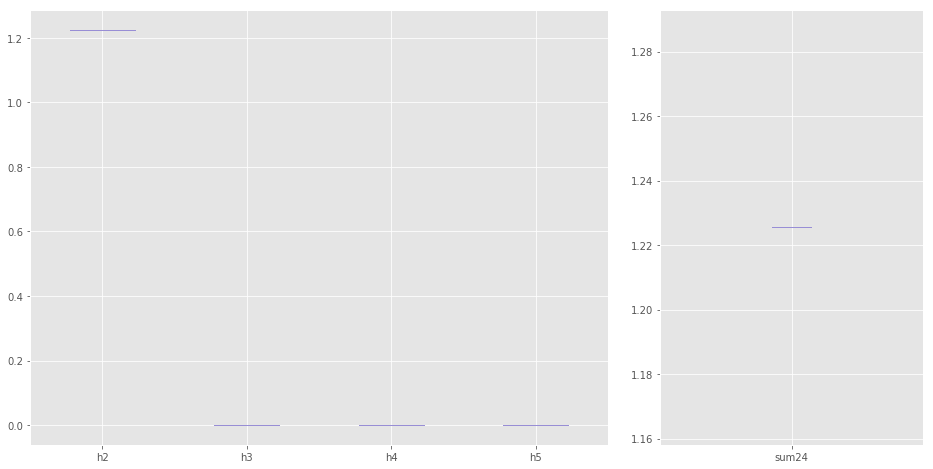

### Results for Running Back, Practice Type: Camp

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.496032,0.496032,0.0,0.0,1.468515
Median,1.736111,0.965957,0.0,0.0,2.480159
75 Percentile,2.480159,1.612103,0.0,0.0,3.720238


##### Box Plots

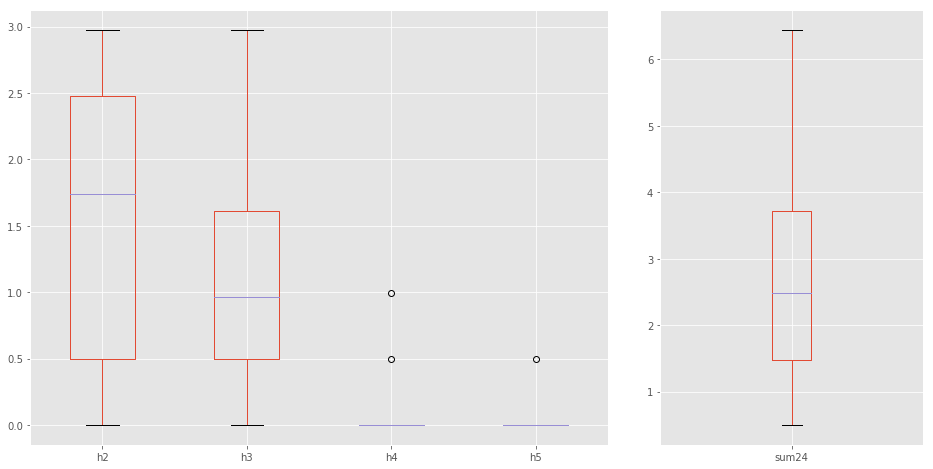

### Results for Running Back, Practice Type: Scrimmage

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.923295,0.195312,0.097656,0.0,1.216264
Median,1.136364,0.390625,0.195312,0.0,1.722301
75 Percentile,1.349432,0.585938,0.292969,0.0,2.228338


##### Box Plots

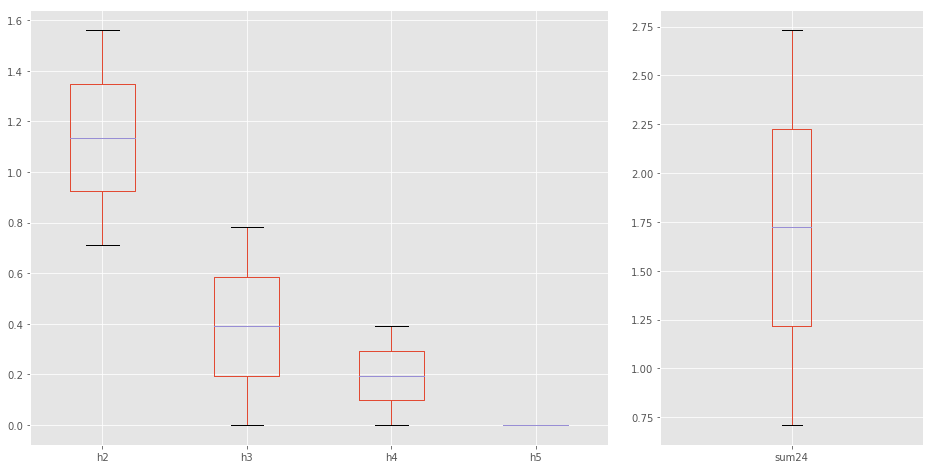

### Results for Running Back, Practice Type: Thurs

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.558036,0.0,0.0,0.0,0.558036
75 Percentile,1.116071,0.0,0.0,0.0,1.116071


##### Box Plots

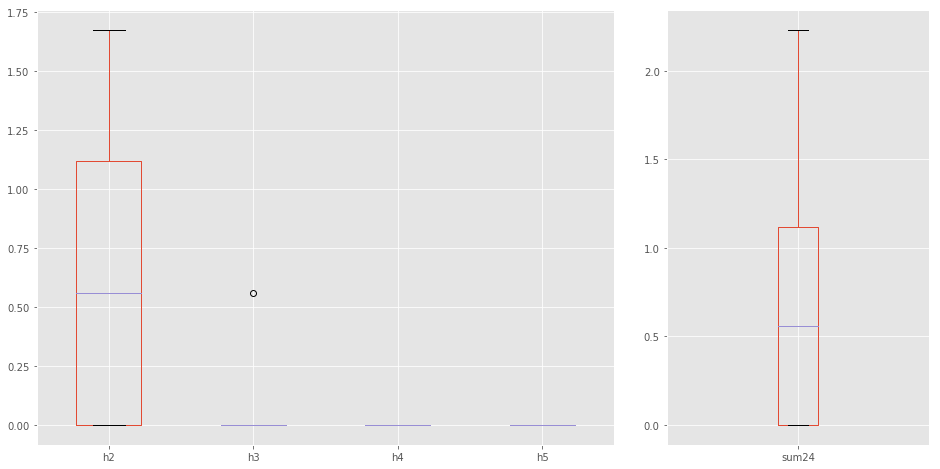

### Results for Running Back, Practice Type: Tues

  Number of Data Points: 11


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.000000,0.000000,0.0,0.0,1.033058
75 Percentile,1.068376,0.783623,0.0,0.0,2.136752


##### Box Plots

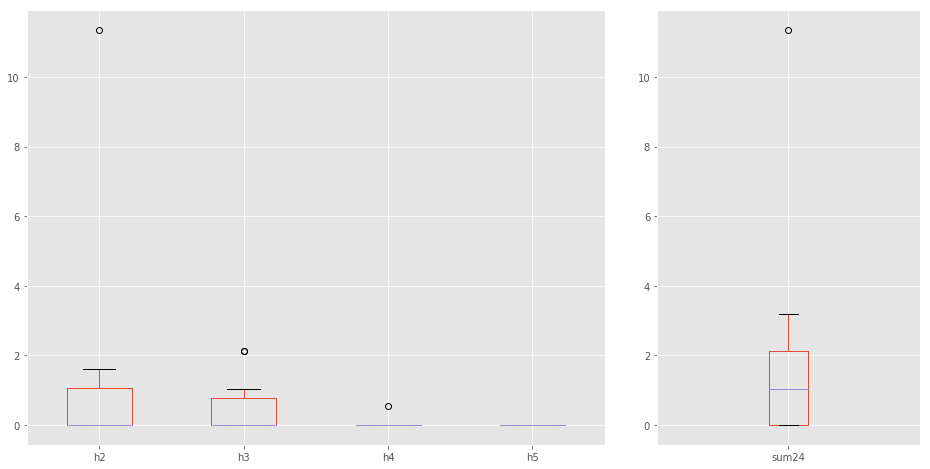

### Results for Running Back, Practice Type: Wed

  Number of Data Points: 7


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.750000,0.504065,0.0,0.0,1.500000
Median,1.000000,1.000000,0.0,0.0,2.000000
75 Percentile,1.042318,1.000000,0.0,0.0,2.338701


##### Box Plots

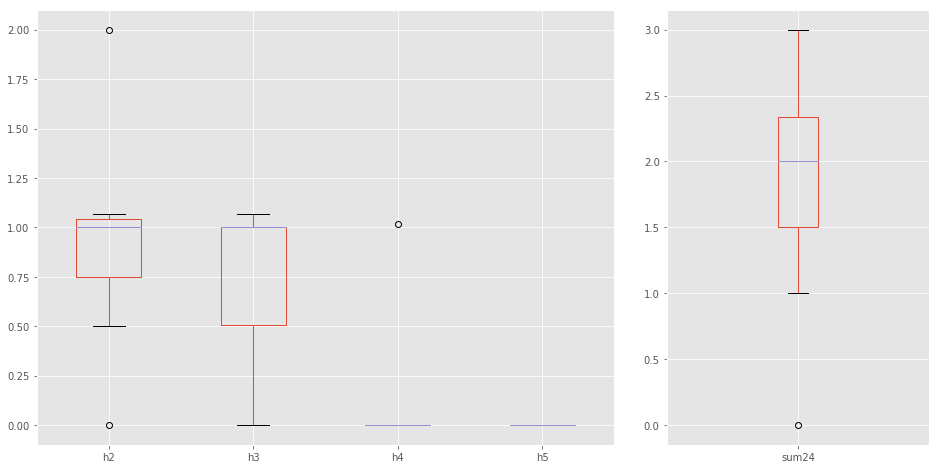

### Results for Running Back, Practice Type: Wed/Thurs

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,1.22549,0.0,1.22549
Median,0.0,0.0,1.22549,0.0,1.22549
75 Percentile,0.0,0.0,1.22549,0.0,1.22549


##### Box Plots

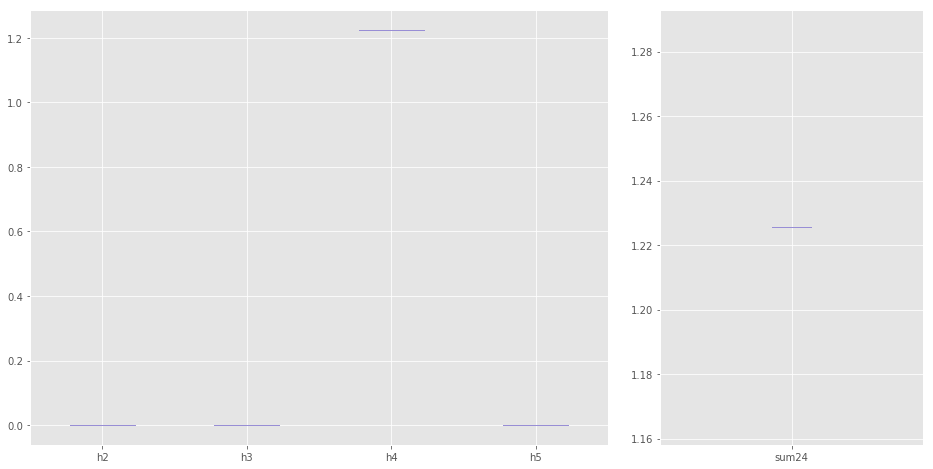

### Results for Safety, Practice Type: Camp

  Number of Data Points: 13


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.856164
Median,0.459559,0.919118,0.0,0.0,0.919118
75 Percentile,0.919118,0.919118,0.0,0.0,1.838235


##### Box Plots

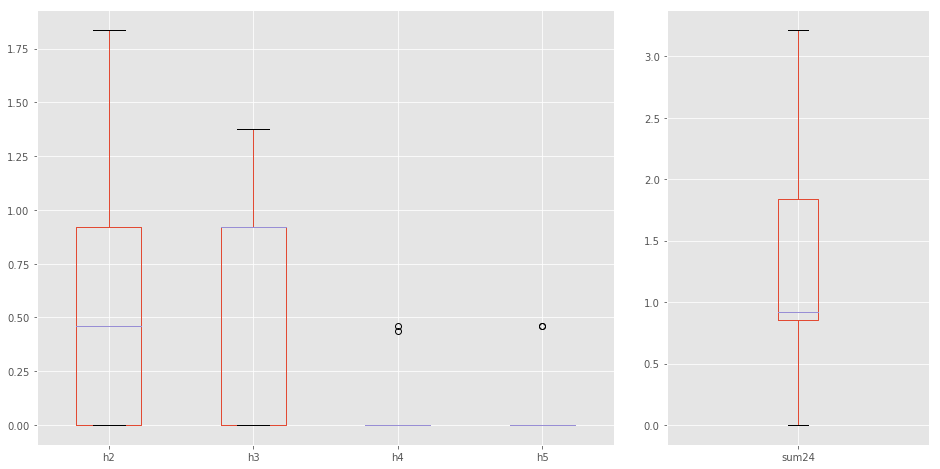

### Results for Safety, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.390625,0.390625,0.0,0.78125
Median,0.0,0.390625,0.390625,0.0,0.78125
75 Percentile,0.0,0.390625,0.390625,0.0,0.78125


##### Box Plots

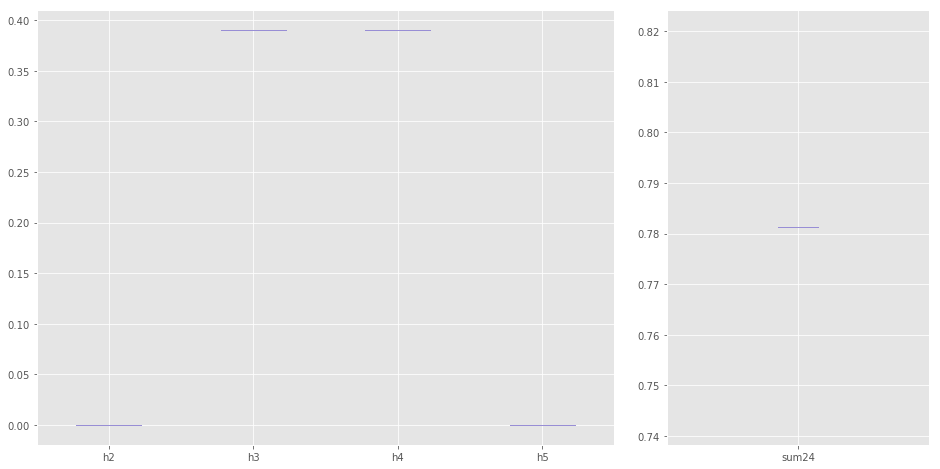

### Results for Safety, Practice Type: Thurs

  Number of Data Points: 5


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.679348,0.0,0.0,0.0,0.679348
Median,0.946970,0.0,0.0,0.0,0.946970
75 Percentile,2.561475,0.0,0.0,0.0,3.073770


##### Box Plots

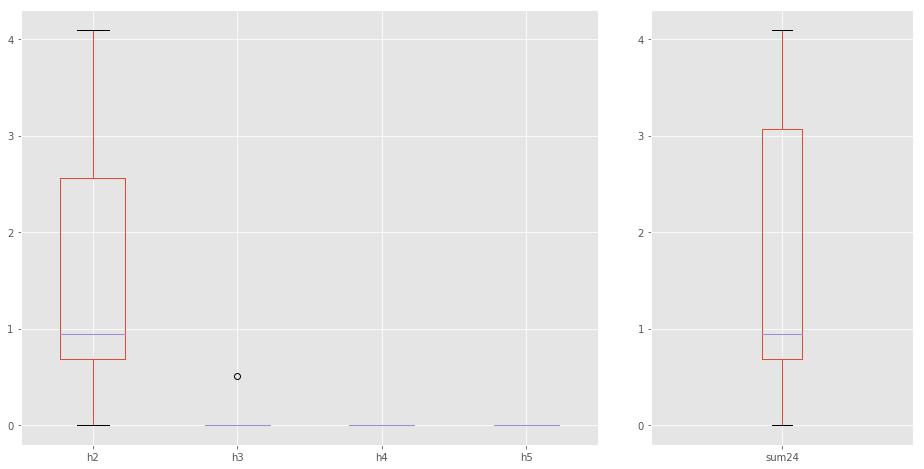

### Results for Safety, Practice Type: Tues

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.498031,0.000000,0.000000,0.0,0.863189
Median,0.742126,0.246063,0.000000,0.0,0.984252
75 Percentile,1.230315,0.738189,0.369094,0.0,1.968504


##### Box Plots

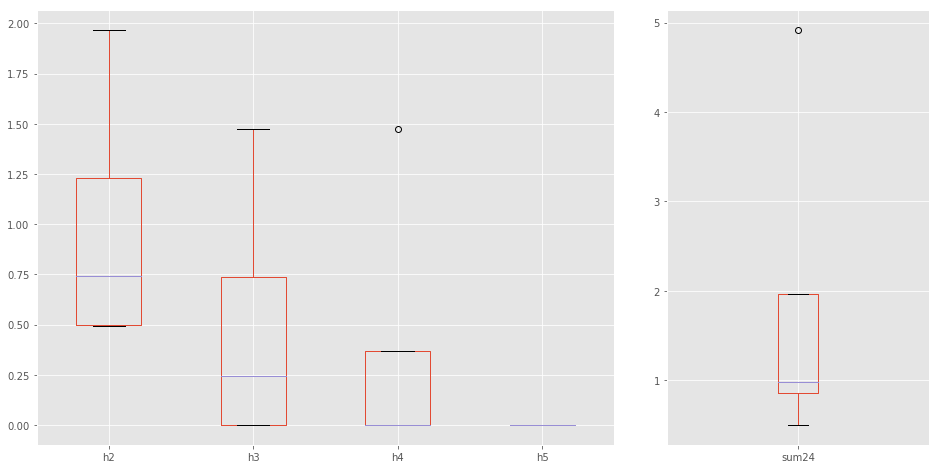

### Results for Safety, Practice Type: Wed

  Number of Data Points: 5


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.462963,0.000000,0.0,0.0,0.469925
Median,0.469925,0.000000,0.0,0.0,0.925926
75 Percentile,0.984252,0.462963,0.0,0.0,1.388889


##### Box Plots

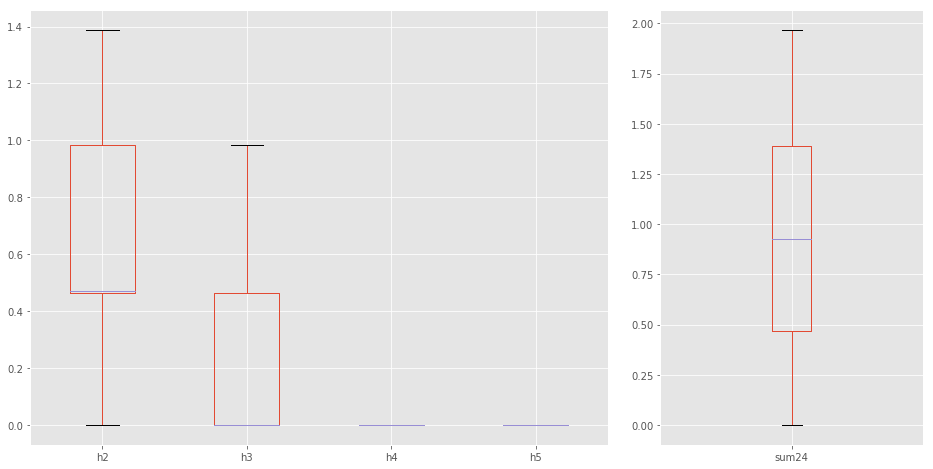

### Results for Tight End, Practice Type: Camp

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.984127,1.448935,0.482978,0.000000,5.077799
Median,2.976190,1.984127,0.496032,0.000000,6.448413
75 Percentile,4.464286,3.224206,0.992063,0.496032,8.184524


##### Box Plots

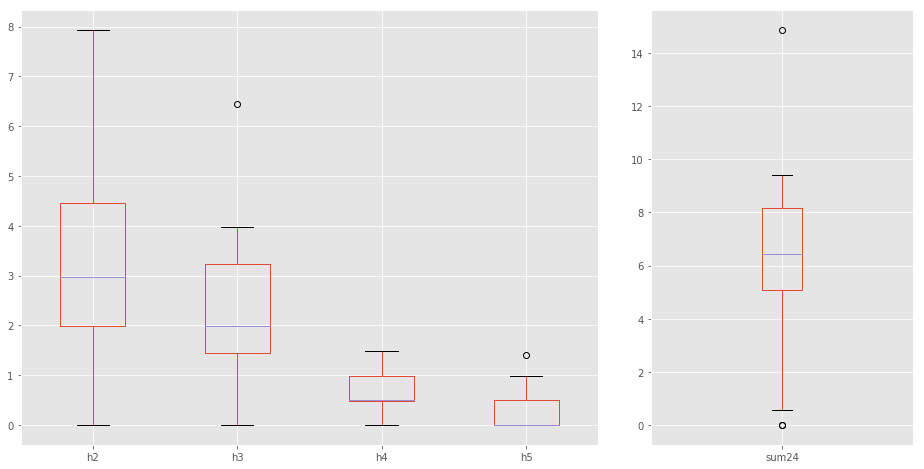

### Results for Tight End, Practice Type: Scrimmage

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.411577,0.195312,0.097656,0.0,1.704545
Median,2.112926,0.390625,0.195312,0.0,2.698864
75 Percentile,2.814276,0.585938,0.292969,0.0,3.693182


##### Box Plots

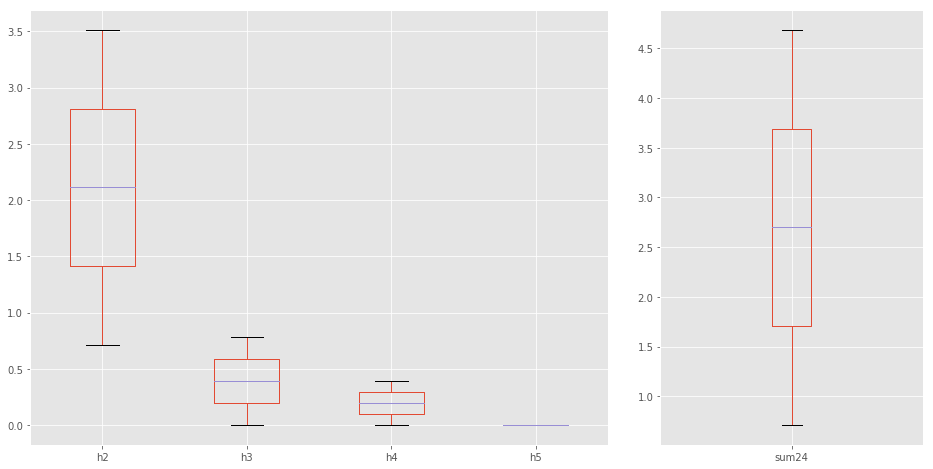

### Results for Tight End, Practice Type: Thurs

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.558036,0.000000,0.0,0.0,0.558036
Median,0.679348,0.000000,0.0,0.0,1.358696
75 Percentile,1.116071,1.116071,0.0,0.0,2.232143


##### Box Plots

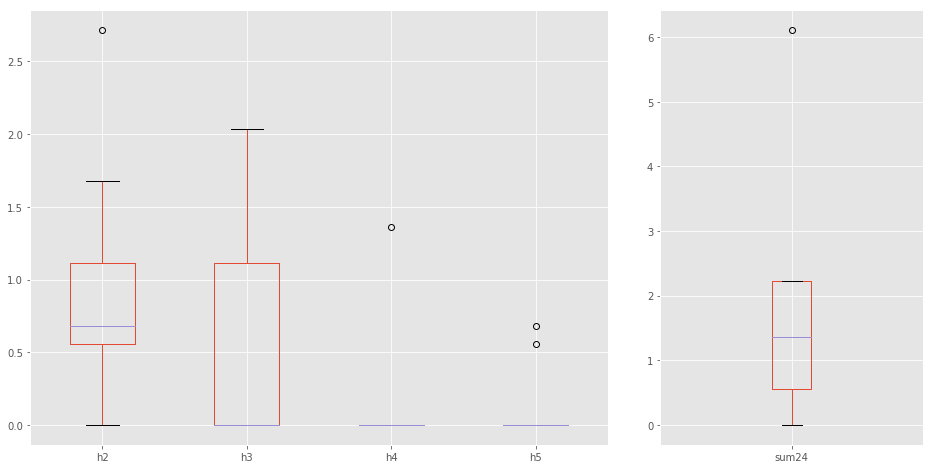

### Results for Tight End, Practice Type: Tues

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.173913,2.838352,0.538833,0.000000,5.655425
Median,3.205128,3.205128,1.068376,0.516529,8.012821
75 Percentile,4.306020,4.273504,1.616499,0.805927,9.139375


##### Box Plots

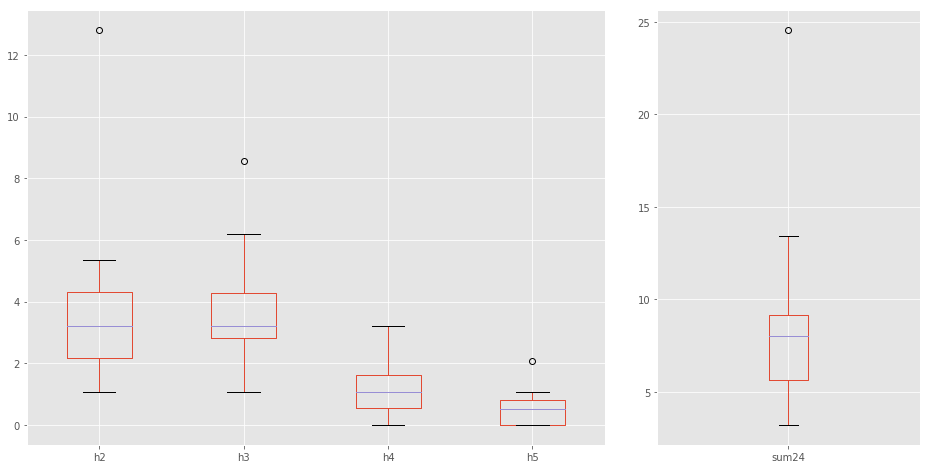

### Results for Tight End, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,3.048780,1.01626,0.0,0.00000,5.081301
Median,3.556911,1.50000,1.0,0.50813,7.478632
75 Percentile,4.500000,3.00000,1.5,1.00000,9.000000


##### Box Plots

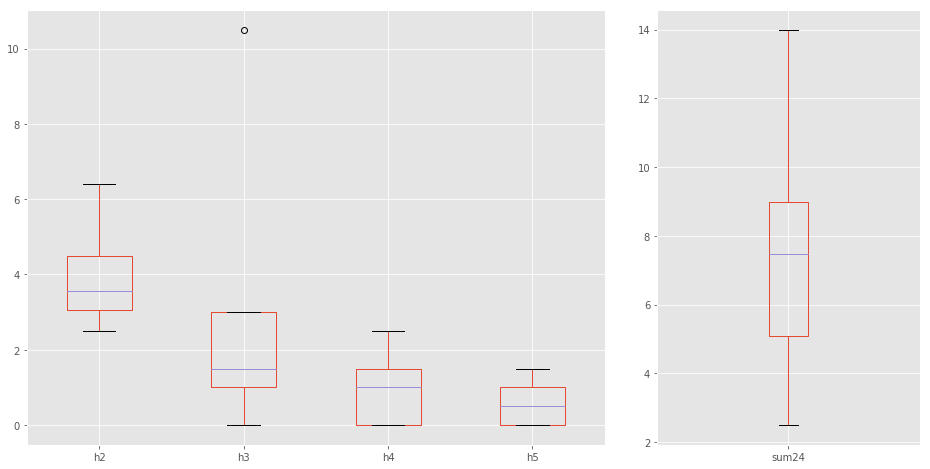

### Results for Tight End, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.037179,3.155239,1.424433,0.306373,7.535969
Median,2.450980,3.246753,1.623377,0.612745,8.578431
75 Percentile,3.676471,4.380730,2.343551,0.612745,10.110294


##### Box Plots

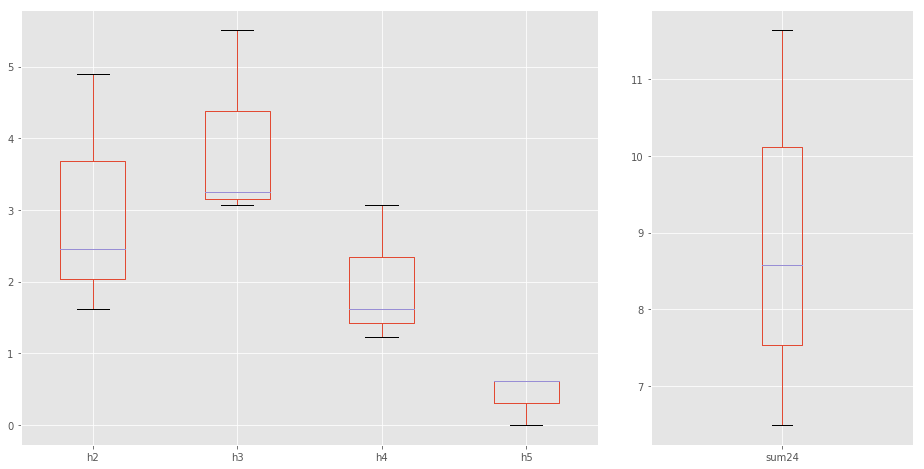

### Results for Wide Receiver, Practice Type: Camp

  Number of Data Points: 11


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.000000,0.0,0.0,0.000000
Median,0.0,0.000000,0.0,0.0,0.000000
75 Percentile,0.0,0.496032,0.0,0.0,0.496032


##### Box Plots

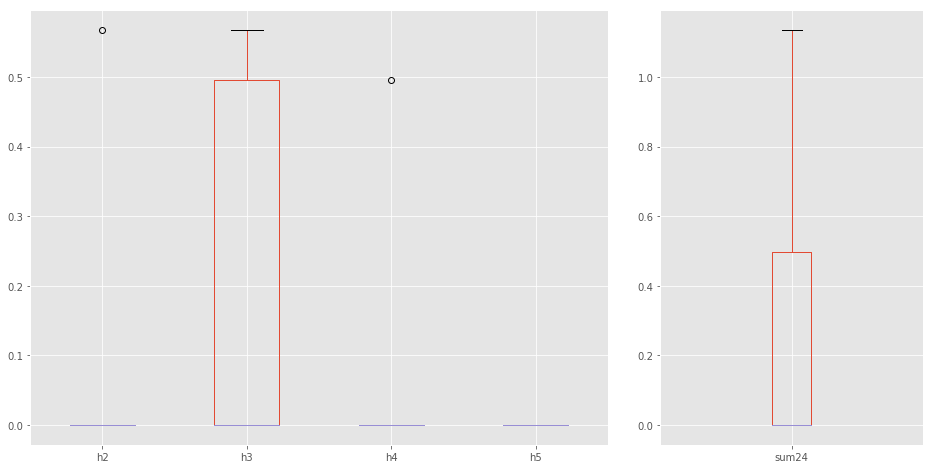

### Results for Wide Receiver, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.710227,0.0,0.0,0.710227
Median,0.0,0.710227,0.0,0.0,0.710227
75 Percentile,0.0,0.710227,0.0,0.0,0.710227


##### Box Plots

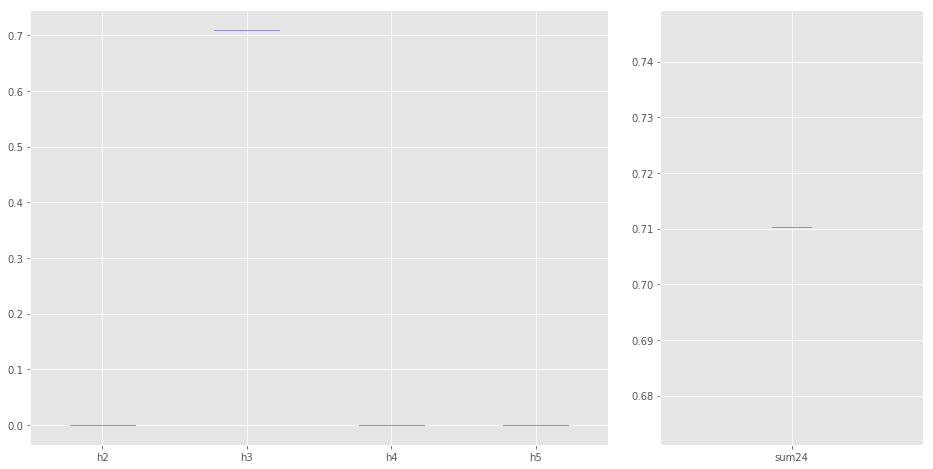

### Results for Wide Receiver, Practice Type: Thurs

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.279018,0.0,0.0,0.0,0.279018
75 Percentile,2.270191,0.0,0.0,0.0,2.625304


##### Box Plots

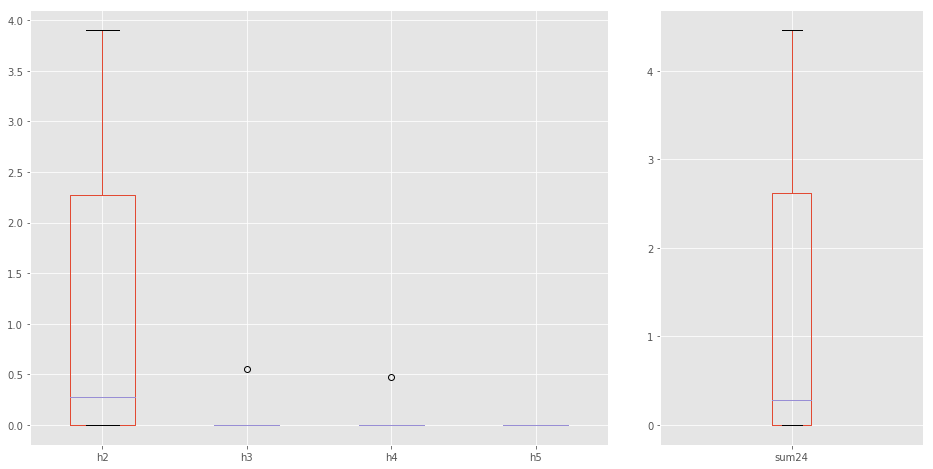

### Results for Wide Receiver, Practice Type: Tues

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.534188,0.000000,0.0,0.0,1.041887
Median,1.050717,0.534188,0.0,0.0,1.420094
75 Percentile,1.068376,0.534188,0.0,0.0,1.602564


##### Box Plots

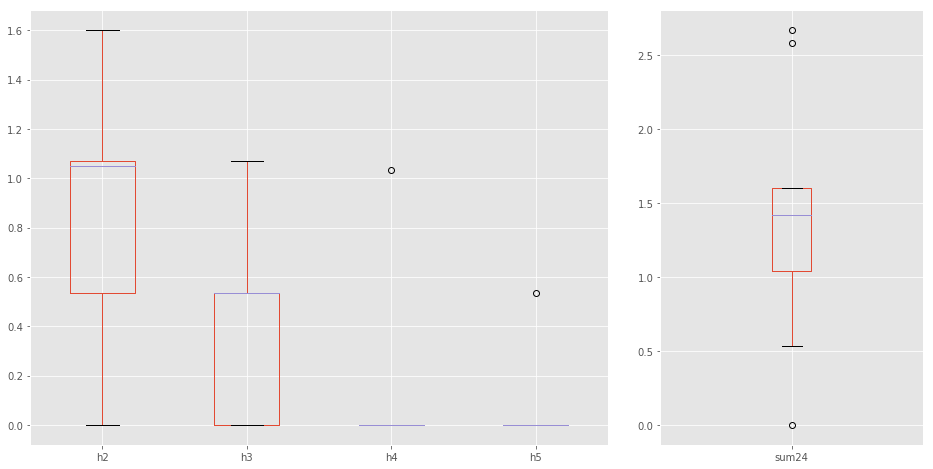

### Results for Wide Receiver, Practice Type: Wed

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.375,0.000,0.0,0.0,0.375
Median,0.750,0.000,0.0,0.0,1.000
75 Percentile,1.375,0.125,0.0,0.0,1.750


##### Box Plots

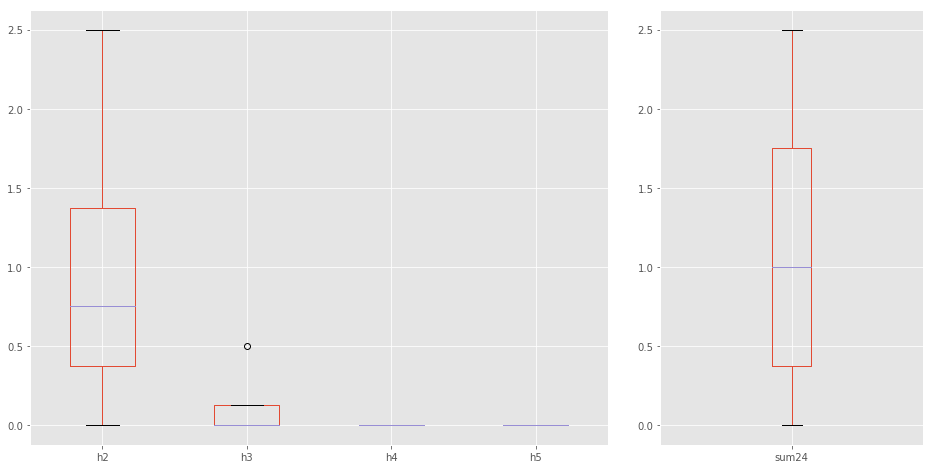

### Results for Wide Receiver, Practice Type: Wed/Thurs

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.22549,0.0,0.0,0.612745,1.22549
Median,1.22549,0.0,0.0,0.612745,1.22549
75 Percentile,1.22549,0.0,0.0,0.612745,1.22549


##### Box Plots

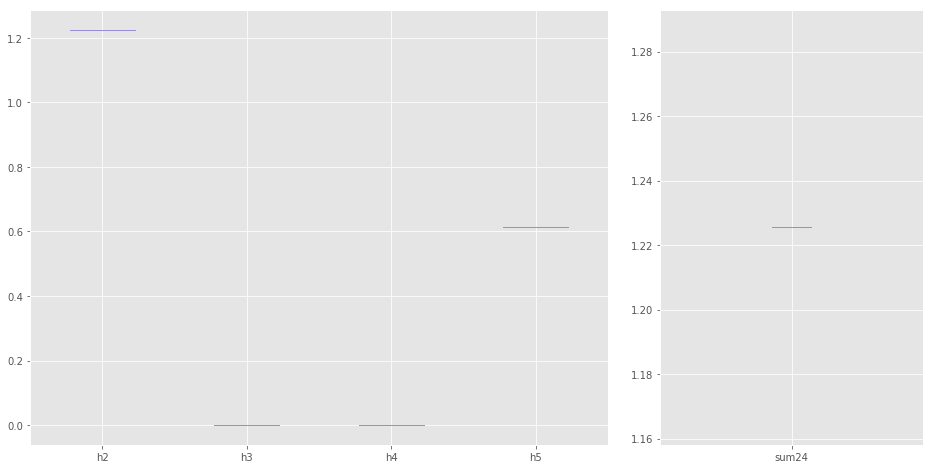

In [13]:
grps = (practices.groupby(['type', 'player', 'pcode', 'ptype', 'day'], as_index=False)
      .sum()
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_total_duration_by_date(durs, y.day, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .assign(h2=lambda x: x.h2*125/x.plyrmnts)
      .assign(h3=lambda x: x.h3*125/x.plyrmnts)
      .assign(h4=lambda x: x.h4*125/x.plyrmnts)
      .assign(h5=lambda x: x.h5*125/x.plyrmnts)
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .groupby(['player']))
for name, grp in grps:
    for n, g in grp.groupby('type'):
        printmd('### Results for {}, Practice Type: {}'.format(name.title(), n.title()))
        print('  Number of Data Points: {}'.format(g.shape[0]))
        #display(g)
        ## Give the median and interquartile ranges
        printmd('##### Interquartile and Median Values')
        dat = g.quantile([0.25, 0.50, 0.75])[['h2', 'h3', 'h4', 'h5', 'sum24']]
        dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
        display(dat)
        printmd('##### Box Plots')
        fig = plt.figure(figsize=(16, 8))
        plt.subplot2grid((1,3), (0,0), colspan=2)
        g[['h2', 'h3', 'h4', 'h5']].boxplot()
        plt.subplot2grid((1,3), (0,2))
        g[['sum24']].boxplot()
        plt.show()

### Question 4: What is the exposure by practice activity across all positions?

This question is similar to question 3, only this time looking for exposure based on practice activity (skelly vs. def, 1on1, etc) instead of practice type (tues, wed, camp, etc) and looking at the data across all player positions.

In [14]:
activity_durs = pd.read_csv('activity_durations.csv', header=[0,1], index_col=0)

In [15]:
grps = (practices
        .drop(practices[practices.day == '2017-08-29'].index)
        .drop(practices[practices.day == '2017-10-04'].index)
        .drop(practices[practices.activity == 'post'].index)
        .groupby(['event', 'day', 'activity', 'ptype'], as_index=False)
        .sum()
        .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.ptype) for idx, y in x.iterrows()])
        .assign(minutes=lambda x: [get_activity_duration_by_event(activity_durs, y.event, y.ptype, y.activity)
                                 for idx, y in x.iterrows()])
        .assign(plyrmnts=lambda x: x.num_players*x.minutes)
        .assign(h2=lambda x: x.h2/x.plyrmnts)
        .assign(h3=lambda x: x.h3/x.plyrmnts)
        .assign(h4=lambda x: x.h4/x.plyrmnts)
        .assign(h5=lambda x: x.h5/x.plyrmnts)
        .assign(sum24=lambda x: x.h2+x.h3+x.h4)
        .groupby(['activity']))
grps.aggregate(np.median)[['h2', 'h3', 'h4', 'h5', 'sum24']]

,h2,h3,h4,h5,sum24
activity,,,,,
1on1,0.010000,0.000000,0.000000,0.0,0.010000
1on2,0.011111,0.000000,0.000000,0.0,0.011111
goal line,0.014286,0.000000,0.000000,0.0,0.014286
indy,0.007378,0.000000,0.000000,0.0,0.011415
inside,0.022222,0.011111,0.000000,0.0,0.044444
kickoff,0.010000,0.000000,0.000000,0.0,0.012500
kor,0.000000,0.000000,0.000000,0.0,0.000000
line games,0.000000,0.000000,0.004630,0.0,0.004630
mix session,0.027619,0.014762,0.000000,0.0,0.045714


### Results for 1On1

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.00000,0.000,0.0,0.0,0.005000
Median,0.01000,0.000,0.0,0.0,0.010000
75 Percentile,0.01105,0.005,0.0,0.0,0.011111


##### Box Plots

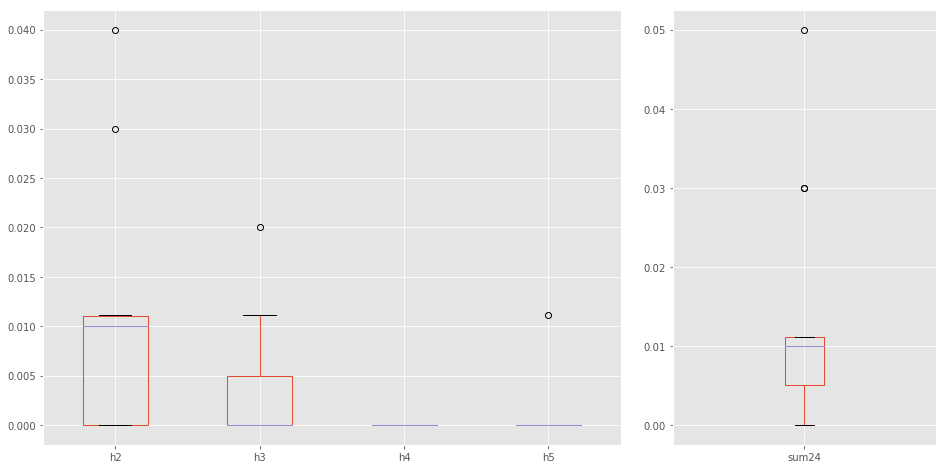

### Results for 1On2

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.005556,0.0,0.0,0.0,0.005556
Median,0.011111,0.0,0.0,0.0,0.011111
75 Percentile,0.016667,0.0,0.0,0.0,0.016667


##### Box Plots

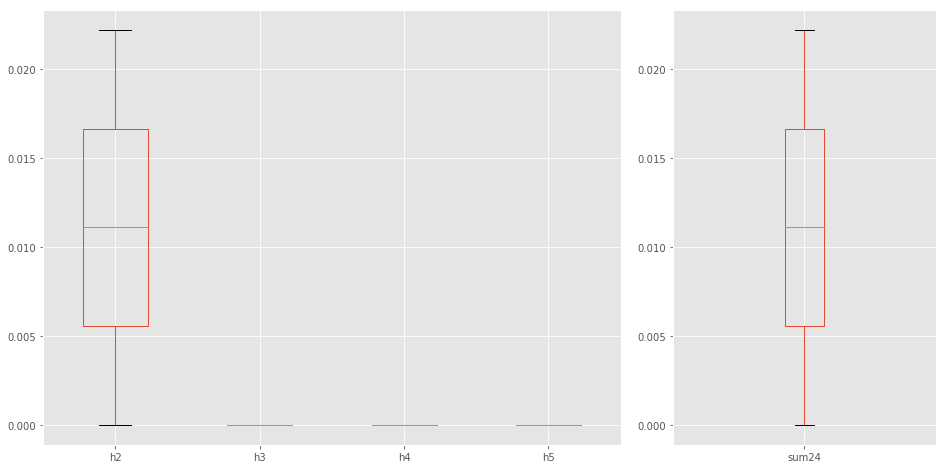

### Results for Goal Line

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.014286,0.0,0.0,0.0,0.014286
Median,0.014286,0.0,0.0,0.0,0.014286
75 Percentile,0.014286,0.0,0.0,0.0,0.014286


##### Box Plots

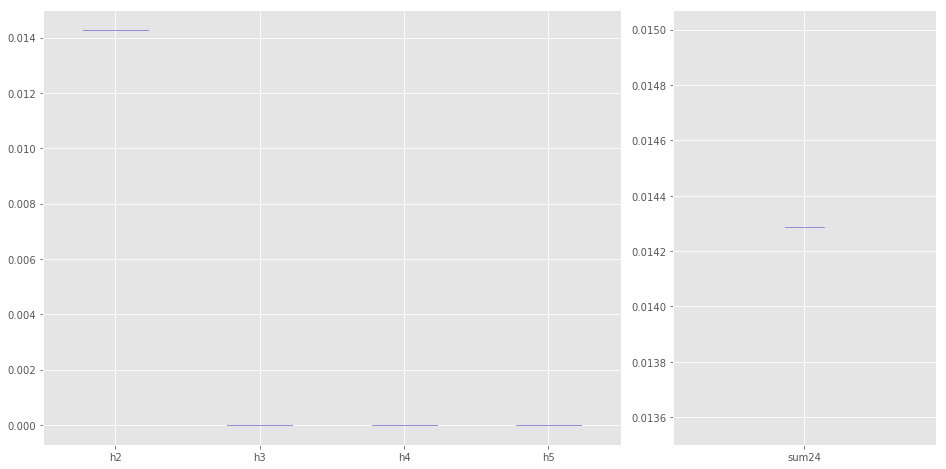

### Results for Indy

  Number of Data Points: 84


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.002337,0.000000,0.0,0.0,0.005417
Median,0.007378,0.000000,0.0,0.0,0.011415
75 Percentile,0.019706,0.006192,0.0,0.0,0.027778


##### Box Plots

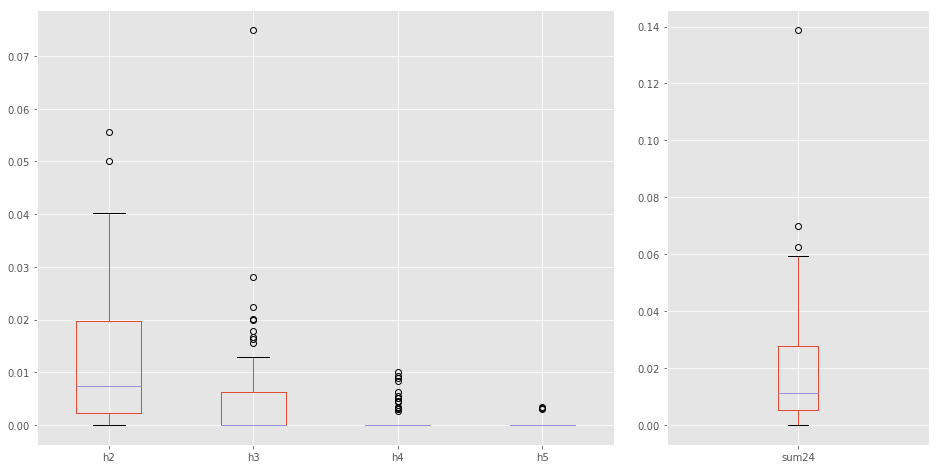

### Results for Inside

  Number of Data Points: 23


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.011111,0.005000,0.0,0.0,0.026111
Median,0.022222,0.011111,0.0,0.0,0.044444
75 Percentile,0.036667,0.022222,0.0,0.0,0.055250


##### Box Plots

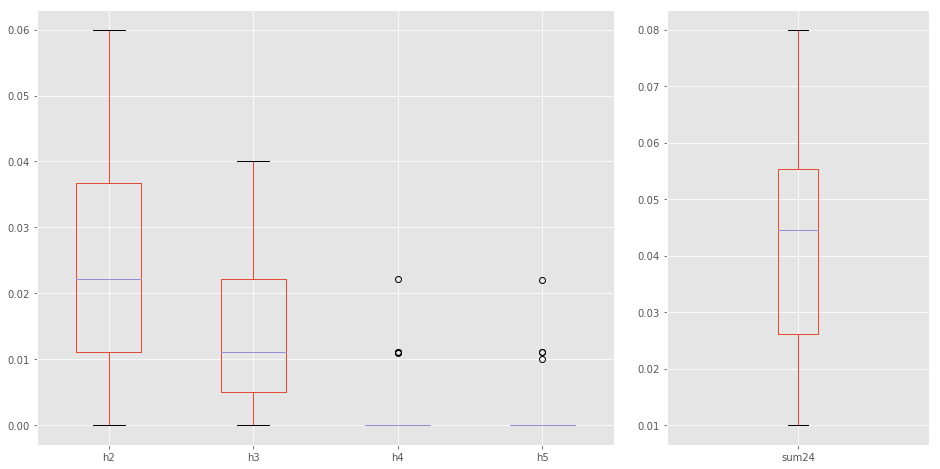

### Results for Kickoff

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.0000
Median,0.010000,0.000000,0.0,0.0,0.0125
75 Percentile,0.015873,0.005556,0.0,0.0,0.0250


##### Box Plots

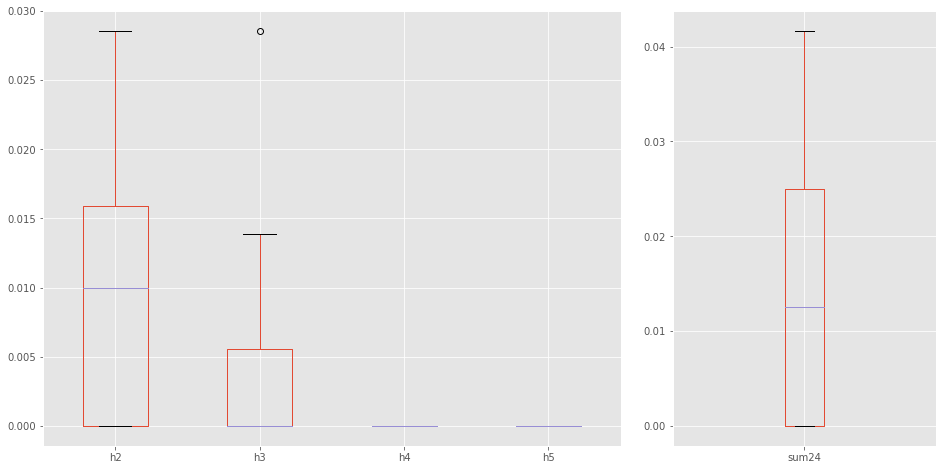

### Results for Kor

  Number of Data Points: 13


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.000000
Median,0.0,0.0,0.0,0.0,0.000000
75 Percentile,0.0,0.0,0.0,0.0,0.011111


##### Box Plots

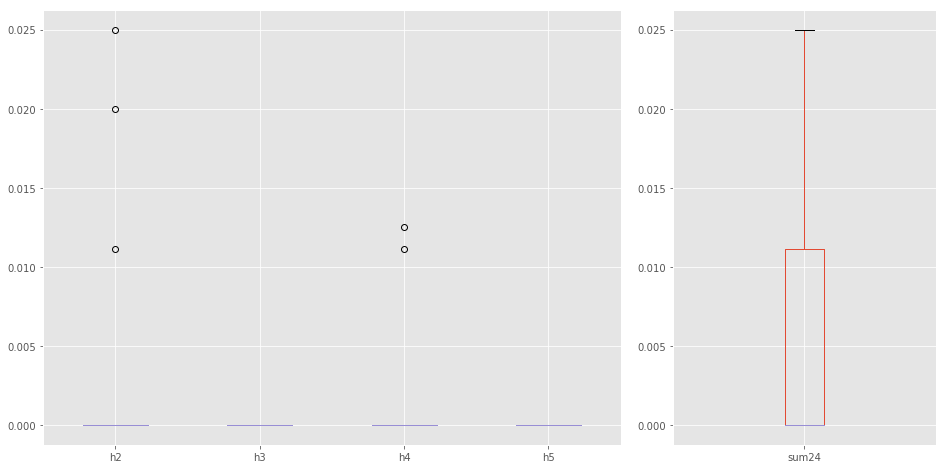

### Results for Line Games

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.002315,0.0,0.002315
Median,0.0,0.0,0.004630,0.0,0.004630
75 Percentile,0.0,0.0,0.006944,0.0,0.006944


##### Box Plots

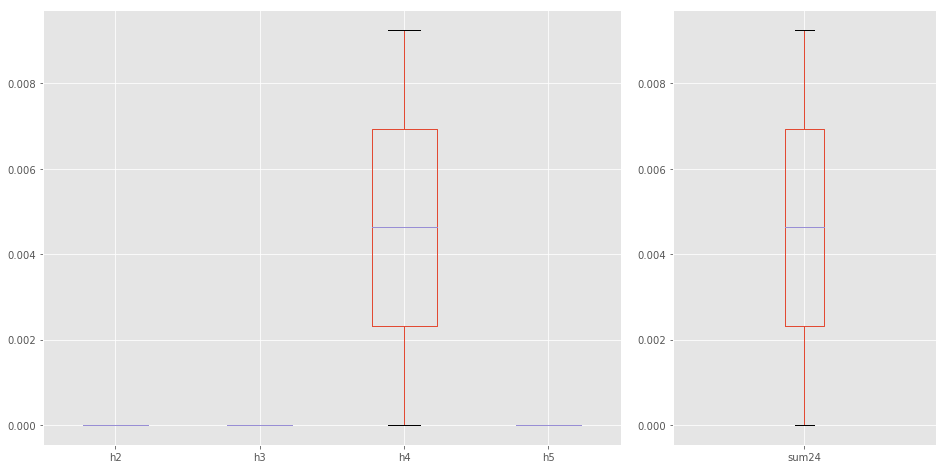

### Results for Mix Session

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.025556,0.007143,0.000000,0.000000,0.034127
Median,0.027619,0.014762,0.000000,0.000000,0.045714
75 Percentile,0.029762,0.020000,0.003333,0.002381,0.055000


##### Box Plots

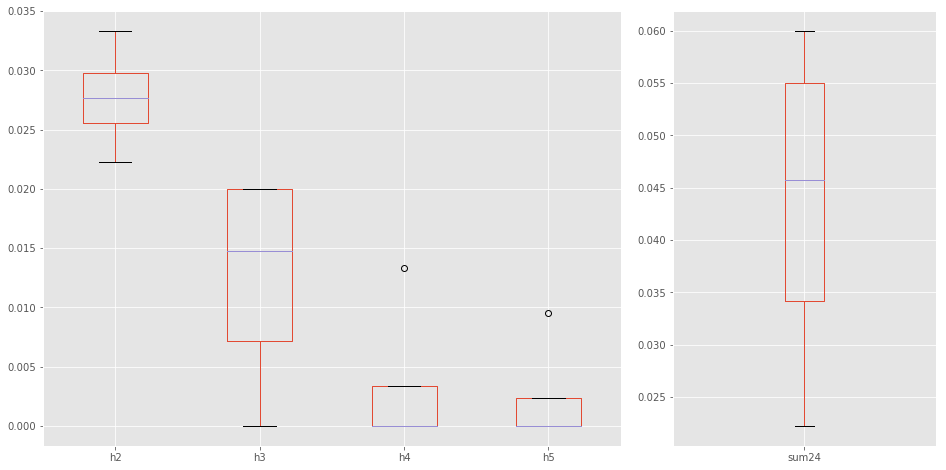

### Results for Otb

  Number of Data Points: 24


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.000000,0.000000,0.0,0.0,0.004167
75 Percentile,0.009259,0.008333,0.0,0.0,0.017130


##### Box Plots

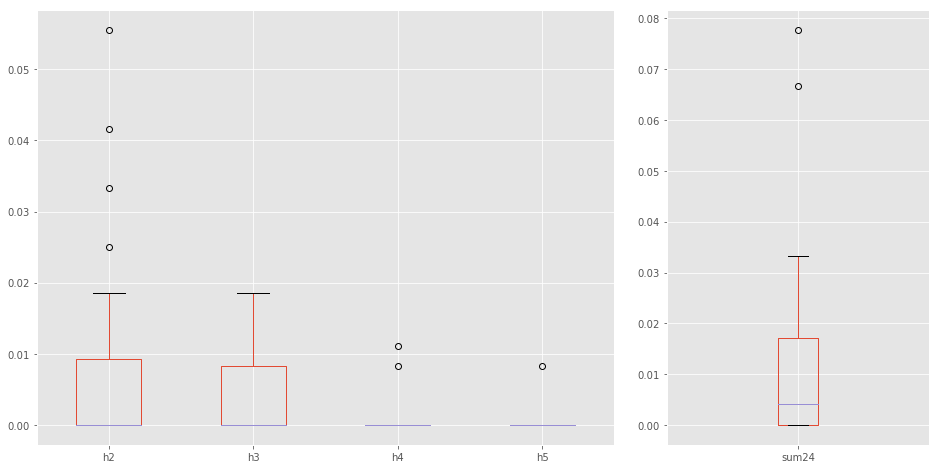

### Results for Pap

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.013889,0.000000,0.000000,0.0,0.015625
Median,0.015625,0.000000,0.013889,0.0,0.027778
75 Percentile,0.027778,0.013889,0.015625,0.0,0.075000


##### Box Plots

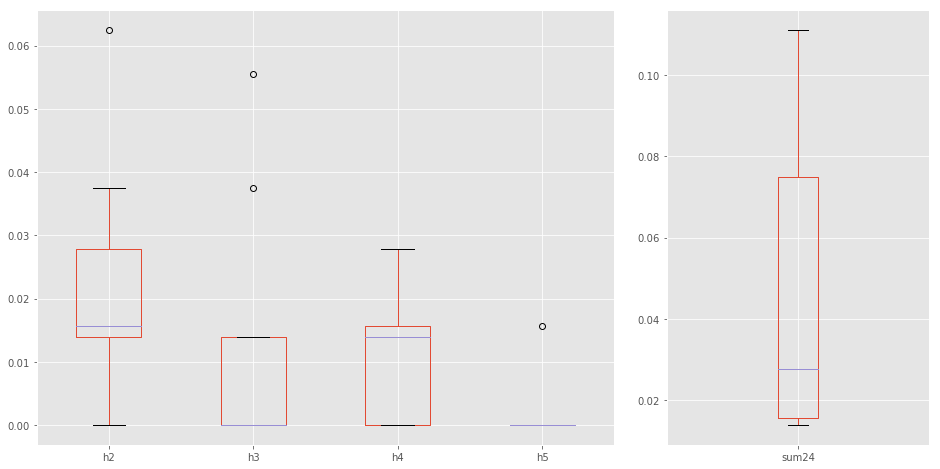

### Results for Pass Rush

  Number of Data Points: 41


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.008333,0.000000,0.0,0.0,0.009259
75 Percentile,0.009259,0.008333,0.0,0.0,0.016667


##### Box Plots

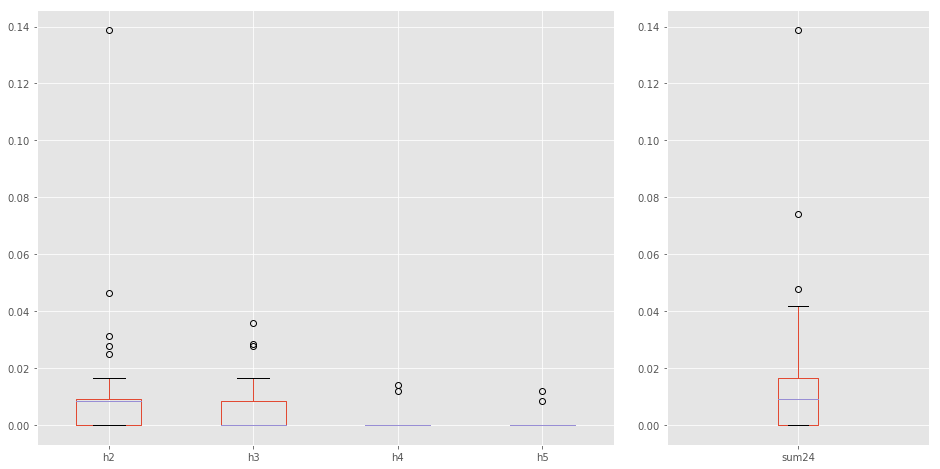

### Results for Pat/Fg

  Number of Data Points: 45


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.022222,0.0,0.0,0.0,0.022222
75 Percentile,0.040000,0.0,0.0,0.0,0.040000


##### Box Plots

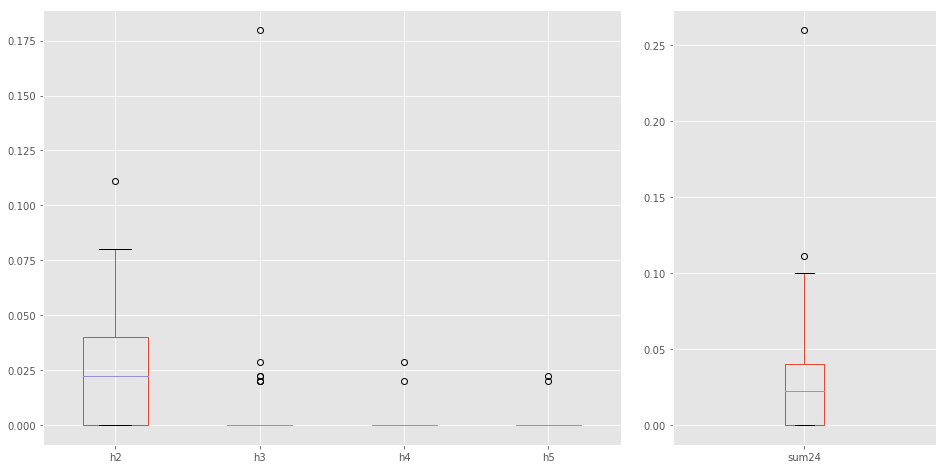

### Results for Perimeter Period

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.028571,0.0,0.0,0.028571
Median,0.0,0.028571,0.0,0.0,0.028571
75 Percentile,0.0,0.028571,0.0,0.0,0.028571


##### Box Plots

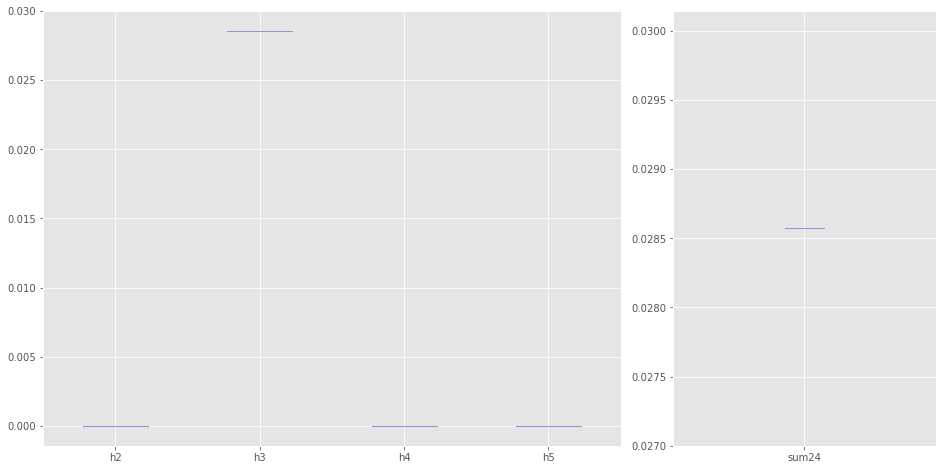

### Results for Post-Practice

  Number of Data Points: 42


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.00,0.0,0.0,0.000000
Median,0.011111,0.00,0.0,0.0,0.013194
75 Percentile,0.021131,0.01,0.0,0.0,0.026389


##### Box Plots

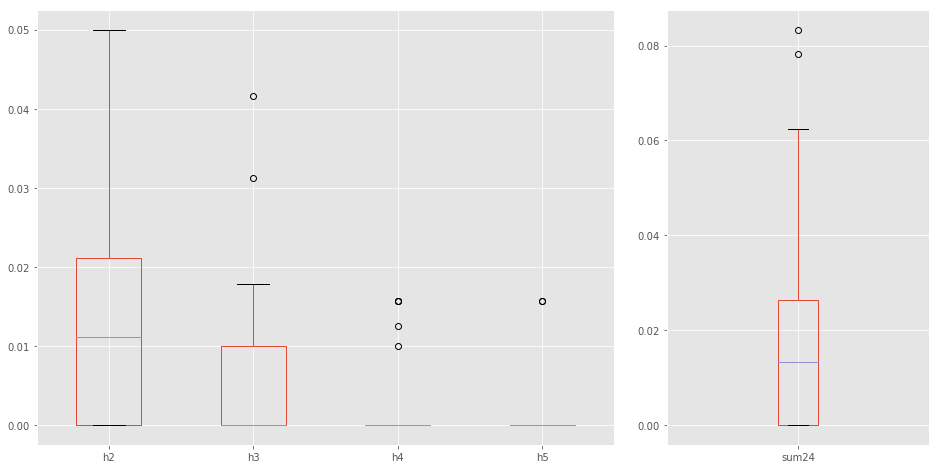

### Results for Pre

  Number of Data Points: 54


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.001852,0.0,0.0,0.0,0.008125
75 Percentile,0.012500,0.0,0.0,0.0,0.020000


##### Box Plots

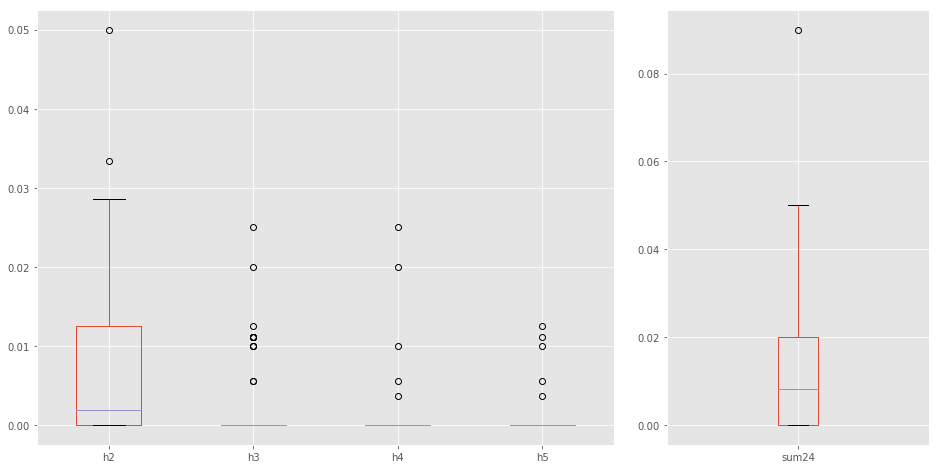

### Results for Punt

  Number of Data Points: 23


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.012500,0.0,0.0,0.0,0.013889
75 Percentile,0.016071,0.0,0.0,0.0,0.018929


##### Box Plots

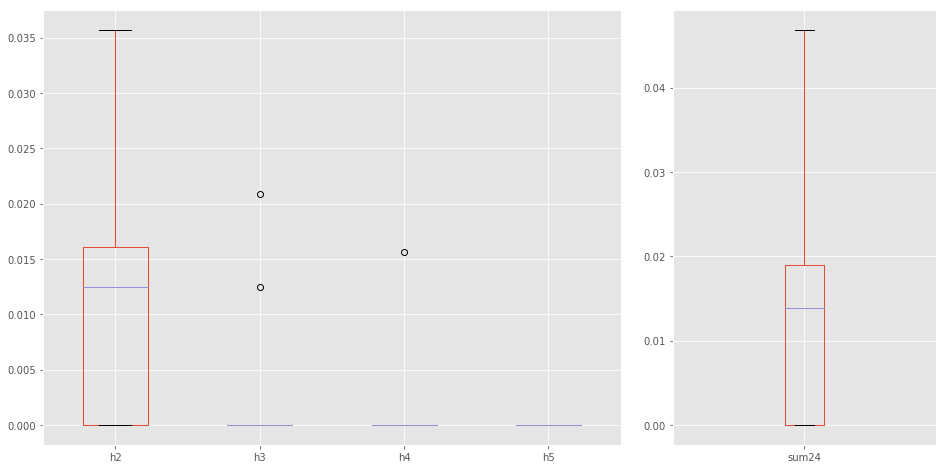

### Results for Punt Return

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

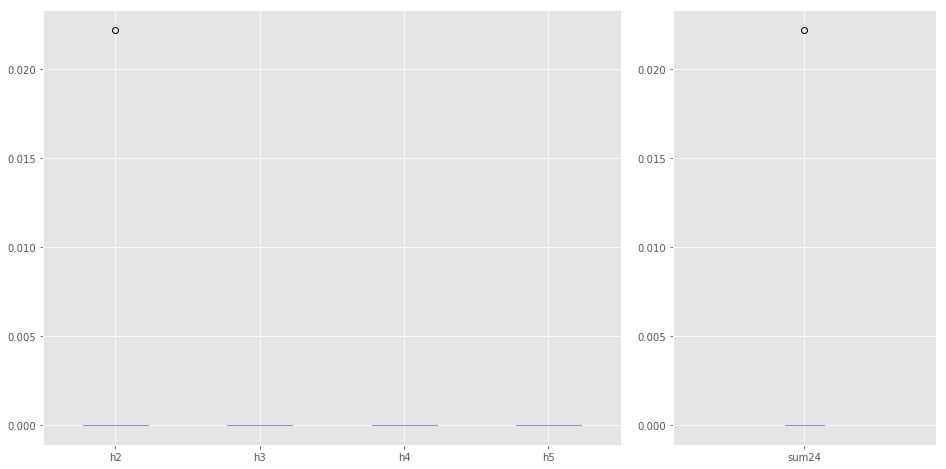

### Results for Red Zone Skell Vs. Scouts

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.010417,0.0,0.0,0.0,0.010417
75 Percentile,0.023065,0.0,0.0,0.0,0.023065


##### Box Plots

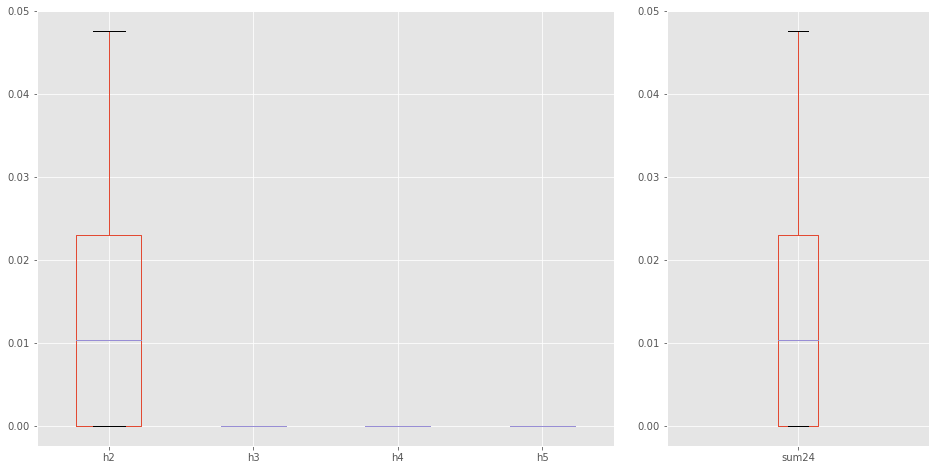

### Results for Run Fit

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.008929,0.0,0.013393
Median,0.005952,0.005952,0.013095,0.0,0.026786
75 Percentile,0.012500,0.012500,0.015179,0.0,0.037500


##### Box Plots

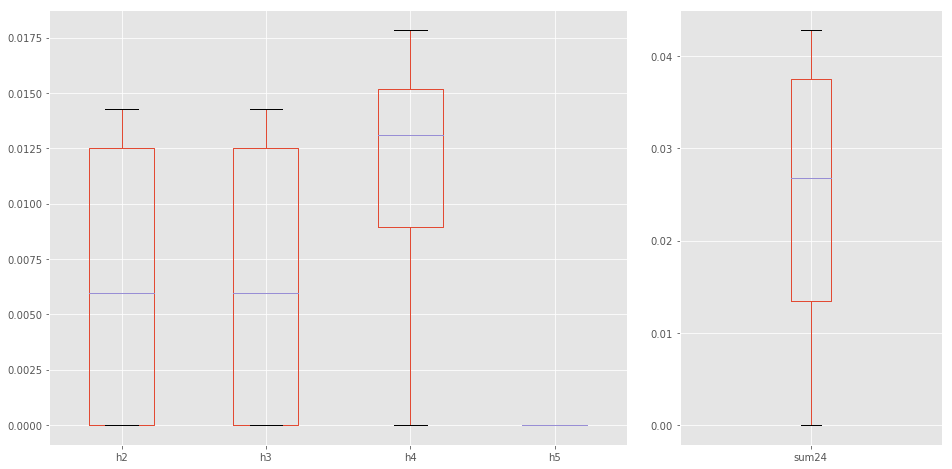

### Results for Run Pursuit

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.011111,0.0,0.0,0.0,0.011111
Median,0.011111,0.0,0.0,0.0,0.011111
75 Percentile,0.011111,0.0,0.0,0.0,0.011111


##### Box Plots

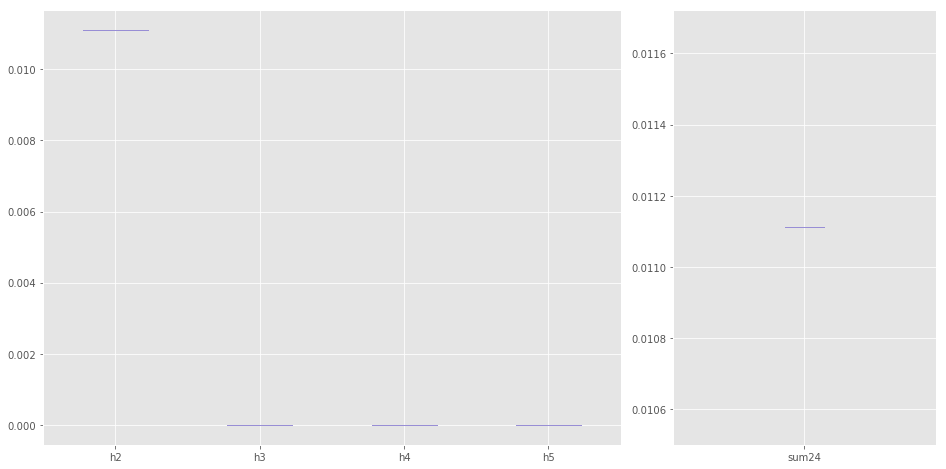

### Results for Run Session

  Number of Data Points: 25


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.007407,0.000000,0.0,0.0,0.013333
Median,0.013333,0.007407,0.0,0.0,0.026667
75 Percentile,0.020000,0.019048,0.0,0.0,0.038095


##### Box Plots

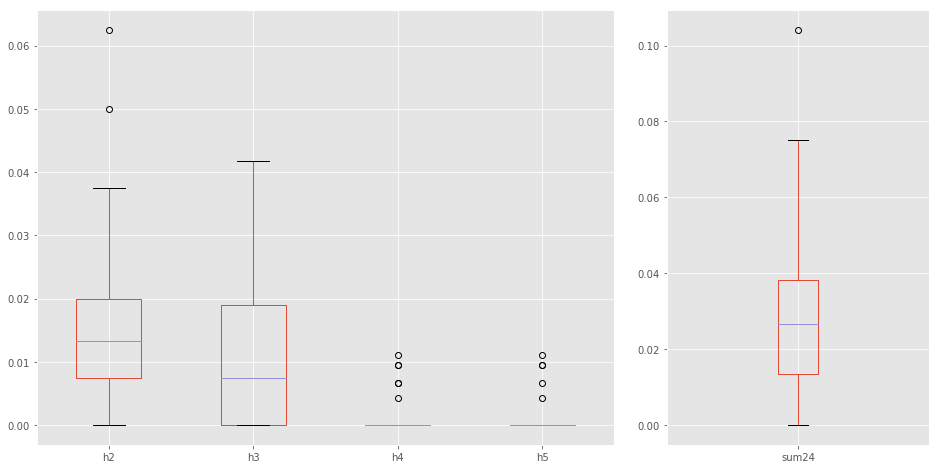

### Results for Run Session-Blitz

  Number of Data Points: 21


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.014815,0.000000,0.000000,0.0,0.033333
Median,0.022222,0.014815,0.000000,0.0,0.041667
75 Percentile,0.029630,0.025000,0.008333,0.0,0.059259


##### Box Plots

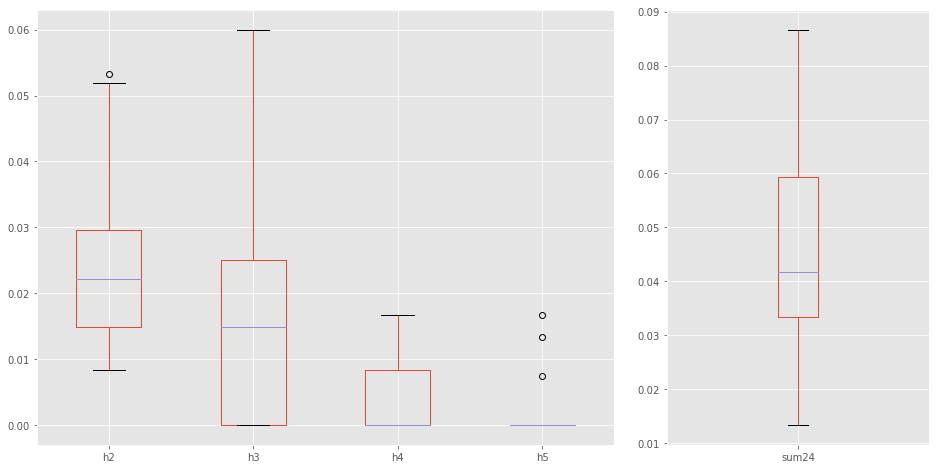

### Results for Scrimmage

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.007315,0.003553,0.000231,0.0,0.011435
Median,0.009722,0.004420,0.000989,0.0,0.016204
75 Percentile,0.013599,0.005324,0.001652,0.0,0.019167


##### Box Plots

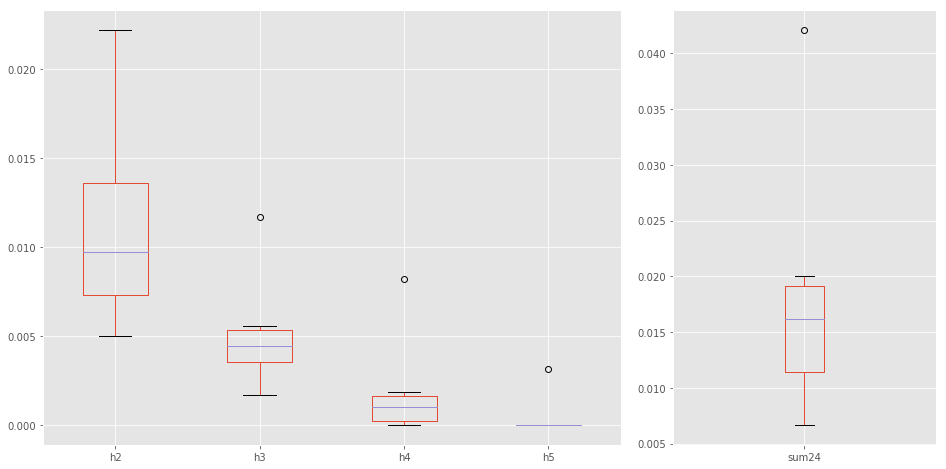

### Results for Skell Vs. Def Scouts

  Number of Data Points: 33


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.004167,0.000000,0.000000,0.0,0.009259
Median,0.008333,0.004630,0.000000,0.0,0.013889
75 Percentile,0.013889,0.009259,0.004167,0.0,0.027778


##### Box Plots

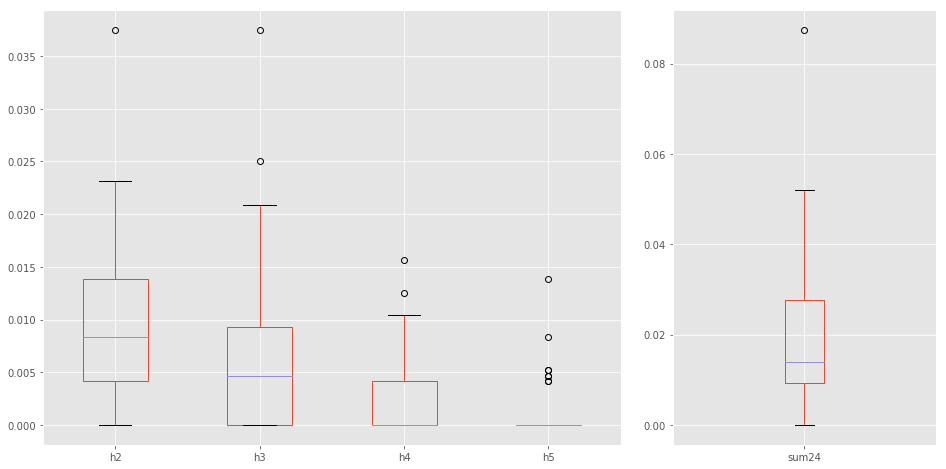

### Results for Skell Vs. Off Scouts

  Number of Data Points: 31


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.004125
Median,0.005952,0.000000,0.0,0.0,0.009259
75 Percentile,0.011905,0.004167,0.0,0.0,0.016146


##### Box Plots

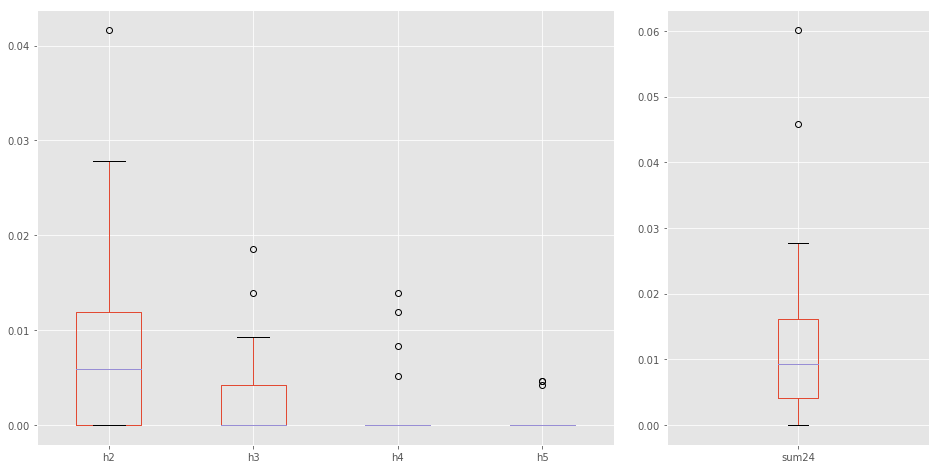

### Results for Specific Def Scheme

  Number of Data Points: 5


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.00,0.000000,0.0,0.0,0.010000
Median,0.00,0.010000,0.0,0.0,0.010000
75 Percentile,0.01,0.011111,0.0,0.0,0.011111


##### Box Plots

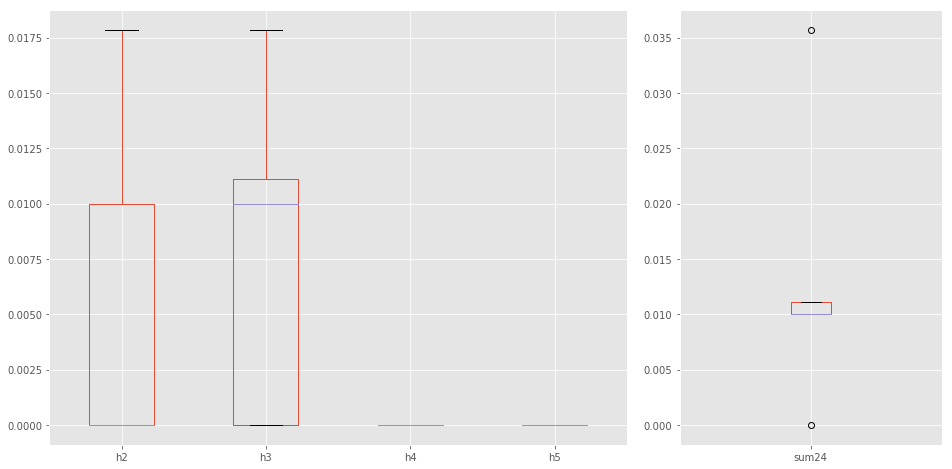

### Results for Team Situation

  Number of Data Points: 48


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0000,0.0,0.0,0.012153
Median,0.017857,0.0000,0.0,0.0,0.023611
75 Percentile,0.030000,0.0125,0.0,0.0,0.037500


##### Box Plots

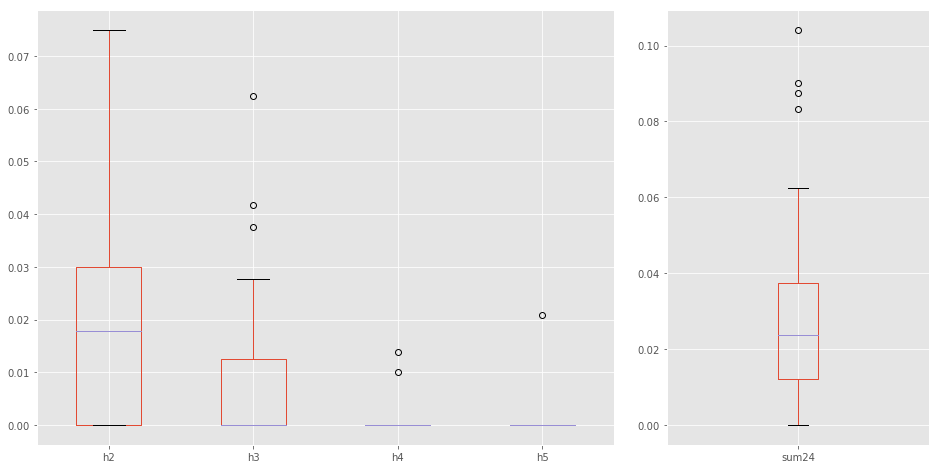

### Results for Team Vs. Def Scouts

  Number of Data Points: 48


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.005934,0.004040,0.000000,0.0,0.015000
Median,0.012374,0.007540,0.000000,0.0,0.026389
75 Percentile,0.022917,0.016964,0.004545,0.0,0.039385


##### Box Plots

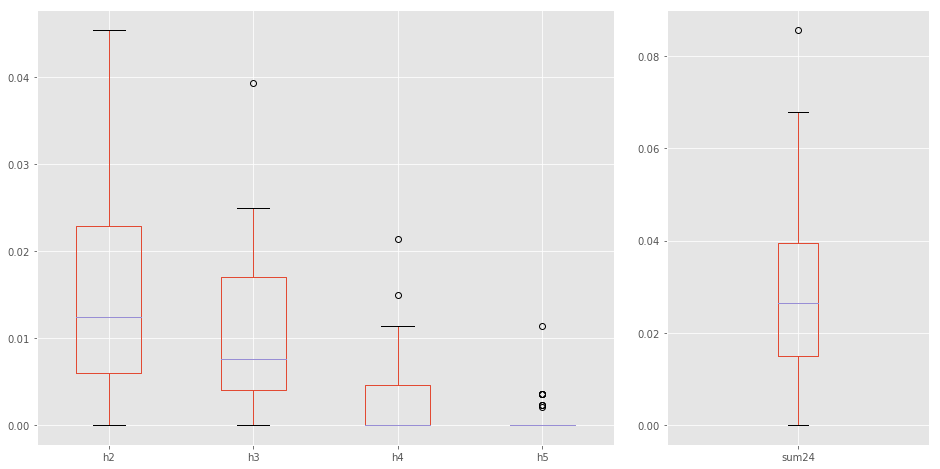

### Results for Team Vs. Off Scouts

  Number of Data Points: 50


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.004738,0.000000,0.000000,0.0,0.007143
Median,0.011905,0.004310,0.000000,0.0,0.018254
75 Percentile,0.021260,0.008049,0.002022,0.0,0.033003


##### Box Plots

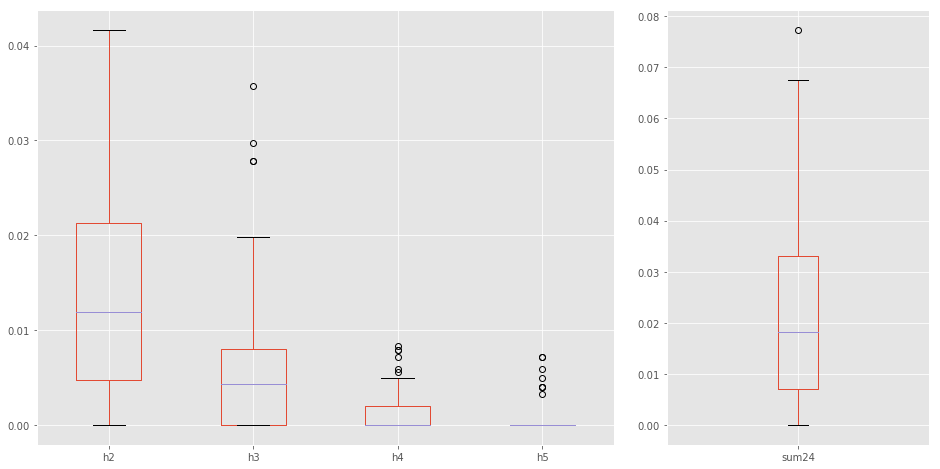

In [16]:
for name, grp in grps:
    printmd('### Results for {}'.format(name.title()))
    #display(grp)
    print('  Number of Data Points: {}'.format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp.quantile([0.25, 0.50, 0.75])[['h2', 'h3', 'h4', 'h5', 'sum24']]
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,3), (0,0), colspan=2)
    grp[['h2', 'h3', 'h4', 'h5']].boxplot()
    plt.subplot2grid((1,3), (0,2))
    grp[['sum24']].boxplot()
    plt.show()

### Question 5a: What is the exposure to hits before and after break across all positions?

In the same manner as in the in previous questions, the data in the following two questions (5a and 5b) has been normalized by the number of "player-minutes" in the given time period (pre or post break).

In [17]:
(practices.groupby(['event', 'before_break', 'day', 'player', 'pcode', 'ptype'], as_index=False)
      .sum()
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_prepost_duration_by_date(durs, y.day, y.before_break, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .groupby(['before_break'], as_index=False)
      .sum()
      .assign(h2=lambda x: x.h2*(60*80)/x.plyrmnts)
      .assign(h3=lambda x: x.h3*(60*80)/x.plyrmnts)
      .assign(h4=lambda x: x.h4*(60*80)/x.plyrmnts)
      .assign(h5=lambda x: x.h5*(60*80)/x.plyrmnts)
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(sum34=lambda x: x.h3+x.h4)
      .set_index('before_break')[['h2', 'h3', 'h4', 'h5', 'sum24', 'sum34']])

,h2,h3,h4,h5,sum24,sum34
before_break,,,,,,
post,91.310510,51.551132,14.664105,6.651759,157.525747,66.215237
pre,59.071577,27.277169,6.254638,2.345489,92.603384,33.531807


### Results for Post Half

Number of samples: 40


##### Interquartile and Median Values

,h2,h3,h4,h5,sum34,sum24
25 Percentile,0.093758,0.043860,0.008772,0.000000,0.064531,0.175395
Median,0.136603,0.074825,0.026316,0.008772,0.095884,0.227630
75 Percentile,0.183411,0.102973,0.035088,0.019231,0.144537,0.315152


##### Box Plots

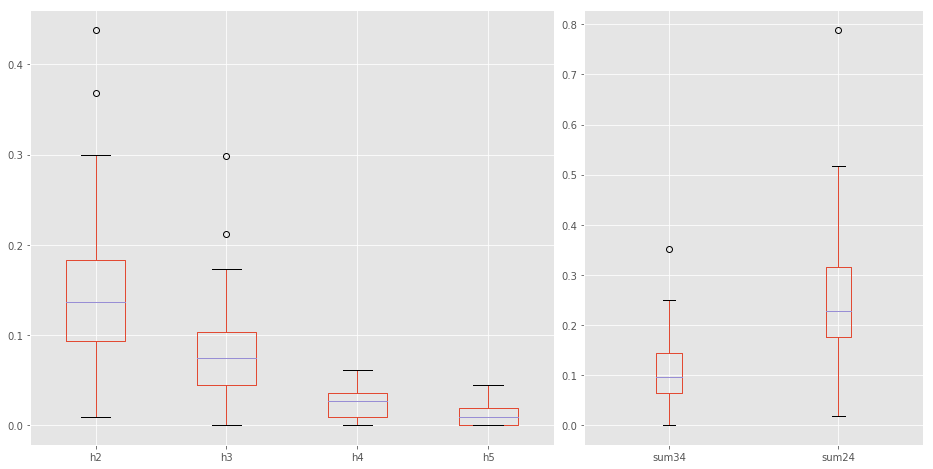

### Results for Pre Half

Number of samples: 55


##### Interquartile and Median Values

,h2,h3,h4,h5,sum34,sum24
25 Percentile,0.040045,0.015476,0.000000,0.000000,0.016969,0.061268
Median,0.083333,0.026316,0.006757,0.000000,0.032979,0.128700
75 Percentile,0.116134,0.063293,0.018028,0.005377,0.076907,0.203026


##### Box Plots

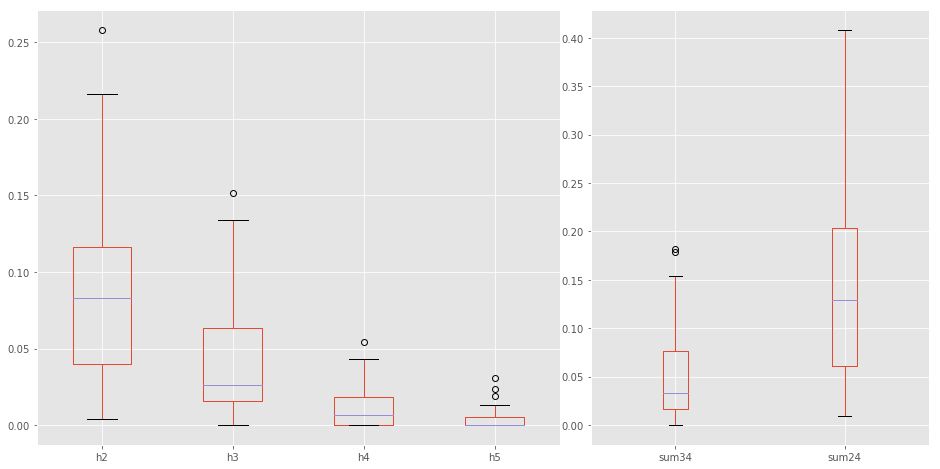

In [18]:
grps = (practices.groupby(['event', 'before_break', 'day', 'player', 'pcode', 'ptype'], as_index=False)
      .sum()
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_prepost_duration_by_date(durs, y.day, y.before_break, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .assign(h2=lambda x: x.h2/x.plyrmnts)
      .assign(h3=lambda x: x.h3/x.plyrmnts)
      .assign(h4=lambda x: x.h4/x.plyrmnts)
      .assign(h5=lambda x: x.h5/x.plyrmnts)
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(sum34=lambda x: x.h3+x.h4)
      .groupby(['event', 'before_break'])
      .sum()
      .groupby('before_break'))
for name, grp in grps:
    printmd('### Results for {} Half'.format(name.title()))
    print("Number of samples: {}".format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp[['h2', 'h3', 'h4', 'h5', 'sum34', 'sum24']].quantile([0.25, 0.50, 0.75])
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,5), (0,0), colspan=3)
    grp[['h2', 'h3', 'h4', 'h5']].boxplot()
    plt.subplot2grid((1,5), (0,3), colspan=3)
    grp[['sum34', 'sum24']].boxplot()
    plt.show()

### Question 5b: What is the exposure to hits before and after halftime across all positions?

Same question as above, this time for game data

In [19]:
(games.groupby(['event', 'before_break', 'day', 'player', 'pcode', 'ptype'], as_index=False)
      .sum()
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_prepost_duration_by_date(durs, y.day, y.before_break, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .groupby(['before_break'])
      .sum()
      .assign(h2=lambda x: x.h2*(30*22)/x.plyrmnts)
      .assign(h3=lambda x: x.h3*(30*22)/x.plyrmnts)
      .assign(h4=lambda x: x.h4*(30*22)/x.plyrmnts)
      .assign(h5=lambda x: x.h5*(30*22)/x.plyrmnts)
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(sum34=lambda x: x.h3+x.h4)[['h2', 'h3', 'h4', 'h5', 'sum24', 'sum34']])

,h2,h3,h4,h5,sum24,sum34
before_break,,,,,,
post,105.327851,72.608986,21.289672,12.101498,199.226509,93.898658
pre,131.550897,86.902000,32.234326,11.325574,250.687223,119.136326


### Results for Post Half

Number of samples: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum34,sum24
25 Percentile,1.264416,0.838394,0.221521,0.119812,1.163326,2.441128
Median,1.404967,1.034601,0.343089,0.171183,1.369770,3.050809
75 Percentile,1.868394,1.257918,0.513802,0.273195,1.785806,3.201507


##### Box Plots

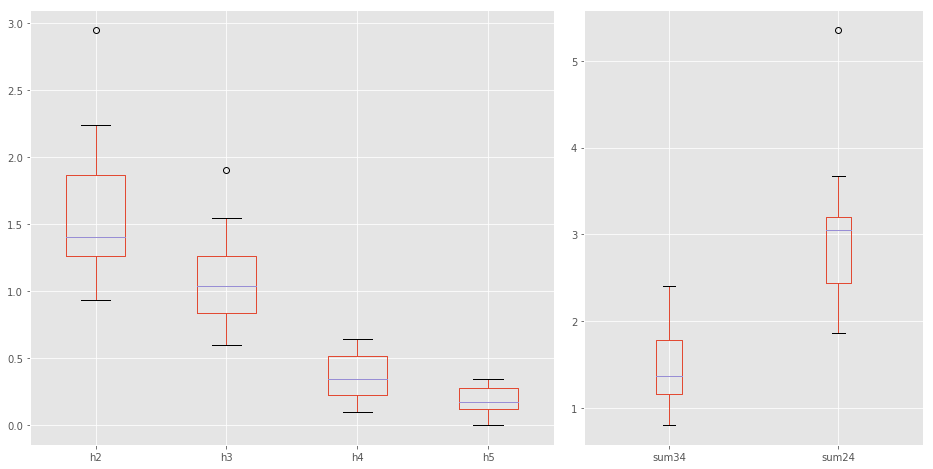

### Results for Pre Half

Number of samples: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum34,sum24
25 Percentile,1.678126,1.175284,0.413750,0.132413,1.543440,3.549933
Median,1.944907,1.270397,0.484207,0.171849,1.763399,3.979053
75 Percentile,2.520292,1.465542,0.621681,0.262972,2.042367,4.286302


##### Box Plots

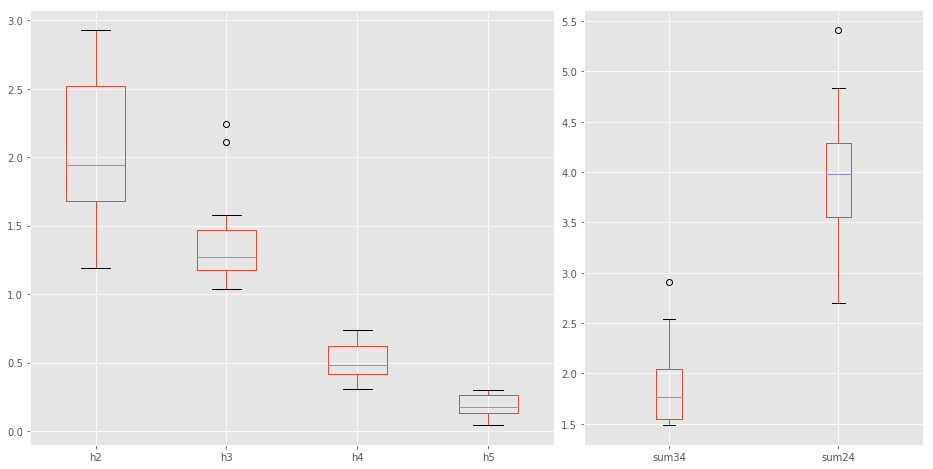

In [20]:
grps = (games.groupby(['event', 'before_break', 'day', 'player', 'pcode', 'ptype'], as_index=False)
      .sum()
      .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, y.pcode) for idx, y in x.iterrows()])
      .assign(minutes=lambda x: [get_prepost_duration_by_date(durs, y.day, y.before_break, y.ptype)
                                 for idx, y in x.iterrows()])
      .assign(plyrmnts=lambda x: x.num_players*x.minutes)
      .assign(h2=lambda x: x.h2/x.plyrmnts)
      .assign(h3=lambda x: x.h3/x.plyrmnts)
      .assign(h4=lambda x: x.h4/x.plyrmnts)
      .assign(h5=lambda x: x.h5/x.plyrmnts)
      .assign(sum24=lambda x: x.h2+x.h3+x.h4)
      .assign(sum34=lambda x: x.h3+x.h4)
      .groupby(['event', 'before_break'])
      .sum()
      .groupby('before_break'))
for name, grp in grps:
    printmd('### Results for {} Half'.format(name.title()))
    print("Number of samples: {}".format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp[['h2', 'h3', 'h4', 'h5', 'sum34', 'sum24']].quantile([0.25, 0.50, 0.75])
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,5), (0,0), colspan=3)
    grp[['h2', 'h3', 'h4', 'h5']].boxplot()
    plt.subplot2grid((1,5), (0,3), colspan=3)
    grp[['sum34', 'sum24']].boxplot()
    plt.show()

## Statistical Tests

### Before and After Break in Practice

Here, we are testing our null hypothesis is that there is no difference in the hit force before and after the break in practice. We consider the hits observed before and after practice as two different populations, and each hit has been classified into a force category ranging from h2 for a weak hit to h5 for a severe hit. Given that we have categorical data for two populations, we'll use the Chi-Squared test of homogeneity to test our hypothesis. First, we'll create the contingency table then run the test.

In [21]:
table = practices.groupby(['before_break']).sum()
printmd('*Contingency Table*')
display(table)
chi2, pval, dof, expected_vals = chi2_contingency(table)
print('The p-value is {}.'.format(pval))
printmd('*The expected values are:*')
display(pd.DataFrame(expected_vals, index=table.index, columns=table.columns))

*Contingency Table*

,h2,h3,h4,h5
before_break,,,,
post,604.0,341.0,97.0,44.0
pre,680.0,314.0,72.0,27.0


The p-value is 0.003923549295454134.


*The expected values are:*

,h2,h3,h4,h5
before_break,,,,
post,639.937586,326.447912,84.228545,35.385957
pre,644.062414,328.552088,84.771455,35.614043




### Before and After Halftime in Games

We'll now run the same test on the game data.

In [22]:
table = games.groupby(['before_break']).sum()
printmd('*Contingency Table*')
display(table)
chi2, pval, dof, expected_vals = chi2_contingency(table)
print('The p-value is {}.'.format(pval))
printmd('*The expected values are:*')
display(pd.DataFrame(expected_vals, index=table.index, columns=table.columns))

*Contingency Table*

,h2,h3,h4,h5
before_break,,,,
post,470.0,324.0,95.0,54.0
pre,604.0,399.0,148.0,52.0


The p-value is 0.19809520536597588.


*The expected values are:*

,h2,h3,h4,h5
before_break,,,,
post,471.939422,317.702237,106.77959,46.578751
pre,602.060578,405.297763,136.22041,59.421249


For games, we'll accept the null hypothesis.

### Testing Practice Types

We'll run the same test on differing practice types, asking the question if there is a difference in hit force between practice types. The null, once again, is that there isn't a difference.

#### Tuesday vs Wednesday

In [23]:
table = practices.groupby(['type']).sum().loc[['tues', 'wed'], :]
printmd('*Contingency Table*')
display(table)
chi2, pval, dof, expected_vals = chi2_contingency(table)
print('The p-value is {}.'.format(pval))
printmd('*The expected values are:*')
display(pd.DataFrame(expected_vals, index=table.index, columns=table.columns))

*Contingency Table*

,h2,h3,h4,h5
type,,,,
tues,343.0,206.0,54.0,26.0
wed,271.0,104.0,36.0,16.0


The p-value is 0.02129596408083769.


*The expected values are:*

,h2,h3,h4,h5
type,,,,
tues,365.725379,184.649621,53.607955,25.017045
wed,248.274621,125.350379,36.392045,16.982955


Therefore we reject the null for Tuesday vs Wednesday practices.

#### Tuesday vs Thursday

In [24]:
table = practices.groupby(['type']).sum().loc[['tues', 'thurs'], :]
printmd('*Contingency Table*')
display(table)
chi2, pval, dof, expected_vals = chi2_contingency(table)
print('The p-value is {}.'.format(pval))
printmd('*The expected values are:*')
display(pd.DataFrame(expected_vals, index=table.index, columns=table.columns))

*Contingency Table*

,h2,h3,h4,h5
type,,,,
tues,343.0,206.0,54.0,26.0
thurs,152.0,70.0,13.0,4.0


The p-value is 0.03839171734774302.


*The expected values are:*

,h2,h3,h4,h5
type,,,,
tues,358.703917,200.004608,48.551843,21.739631
thurs,136.296083,75.995392,18.448157,8.260369


Therefore we do not reject the null for Tuesday vs Thursday practices.

#### Wednesday vs Thursday

In [25]:
table = practices.groupby(['type']).sum().loc[['wed', 'thurs'], :]
printmd('*Contingency Table*')
display(table)
chi2, pval, dof, expected_vals = chi2_contingency(table)
print('The p-value is {}.'.format(pval))
printmd('*The expected values are:*')
display(pd.DataFrame(expected_vals, index=table.index, columns=table.columns))

*Contingency Table*

,h2,h3,h4,h5
type,,,,
wed,271.0,104.0,36.0,16.0
thurs,152.0,70.0,13.0,4.0


The p-value is 0.1395299323386981.


*The expected values are:*

,h2,h3,h4,h5
type,,,,
wed,271.202703,111.558559,31.415916,12.822823
thurs,151.797297,62.441441,17.584084,7.177177


Therefore we do not reject the null for Wednesday vs Thursday practices.

#### Camp vs Combined Tuesday, Wednesday, Thursday

In [26]:
tmp = practices.groupby(['type']).sum()
tmp = tmp.append(pd.Series(tmp.loc['tues', :] + tmp.loc['wed', :] + tmp.loc['thurs', :], name='comb'))
table = tmp.loc[['camp', 'comb'], :]
printmd('*Contingency Table*')
display(table)
chi2, pval, dof, expected_vals = chi2_contingency(table)
print('The p-value is {}.'.format(pval))
printmd('*The expected values are:*')
display(pd.DataFrame(expected_vals, index=table.index, columns=table.columns))

*Contingency Table*

,h2,h3,h4,h5
type,,,,
camp,421.0,232.0,50.0,21.0
comb,766.0,380.0,103.0,46.0


The p-value is 0.48199426319016914.


*The expected values are:*

,h2,h3,h4,h5
type,,,,
camp,425.650322,219.459138,54.864785,24.025755
comb,761.349678,392.540862,98.135215,42.974245


So, at the $\alpha$ = 0.05 level we must not reject the null hypothesis for the camp and combined Tuesday, Wednesday, Thursday practice data.

## Wilcoxon Statistical Tests

Here, we'll look at if there is a statistically significant difference between the the number of hits a player receives before and after the break in practice by hit strength. A similar test will be run for games using half time as the delimiter. Finally, we'll compare the hits received by practice type (Tuesday, Wednesday, etc) to determine if a player is at more statisically significant risk of receiving a hit of a given strength during any particular practice.

### Practice data

In [27]:
# Do some preliminary data cleaning (eliminate those events that don't have a pre and post period)
tmp = practices.groupby(['event', 'before_break', 'type', 'day'], as_index=False).sum()
for event in np.unique(tmp.event):
    if tmp[tmp.event == event].shape[0] != 2:
        tmp = tmp.drop(tmp[tmp.event == event].index)
grps = tmp.groupby('before_break')

post = (grps.get_group('post')
            .assign(minutes=lambda x: [(get_prepost_duration_by_date(durs, y.day, y.before_break, 'offensive') + 
                                        get_prepost_duration_by_date(durs, y.day, y.before_break, 'defensive'))
                                        for idx, y in x.iterrows()])
            .assign(sum24=lambda x: (x.h2+x.h3+x.h4)/x.minutes)
            .assign(h5=lambda x: x.h5/x.minutes))[['event', 'before_break', 'sum24', 'h5']]

pre = (grps.get_group('pre')
           .assign(minutes=lambda x: [(get_prepost_duration_by_date(durs, y.day, y.before_break, 'offensive') + 
                                       get_prepost_duration_by_date(durs, y.day, y.before_break, 'defensive'))
                                       for idx, y in x.iterrows()])
           .assign(sum24=lambda x: (x.h2+x.h3+x.h4)/x.minutes)
           .assign(h5=lambda x: x.h5/x.minutes))[['event', 'before_break', 'sum24', 'h5']]

#### Sum of Bins 2 - 4

In [28]:
sum24 = pd.DataFrame(np.array([pre.sum24.values, post.sum24.values]).T, columns=['pre', 'post'], index=pre.event)
display(sum24)
wilcoxon(pre.sum24, post.sum24, zero_method='pratt', correction=True)

,pre,post
event,,
Conneticut #1,0.115385,0.175439
Conneticut #2,0.075342,0.075472
Houston #1,0.092308,0.114035
Houston #2,0.095890,0.198113
Louisiana #1,0.415385,0.368421
Louisiana #2,0.363014,0.350877
Memphis #1,0.106061,0.218182
Navy #1,0.130769,0.130841
Navy #2,0.146154,0.228070


WilcoxonResult(statistic=25.0, pvalue=2.3638609217286031e-07)

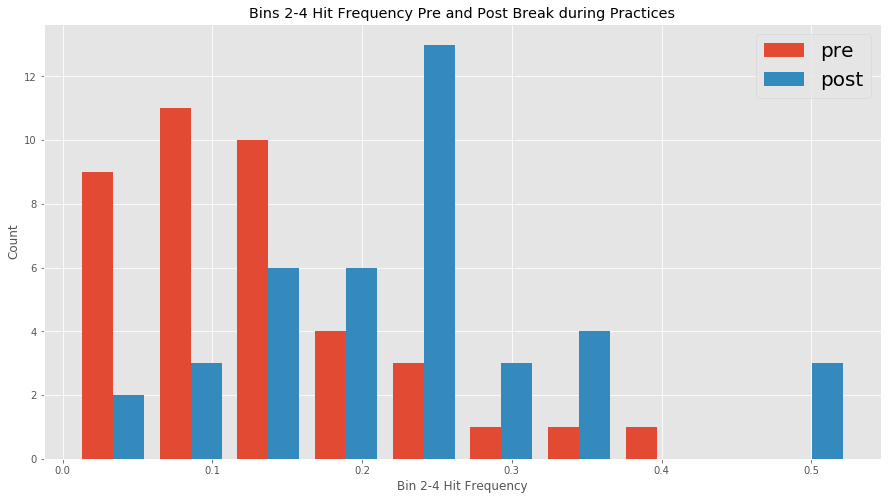

In [29]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.hist([sum24.pre, sum24.post], 10, histtype='bar', label=['pre', 'post'])
ax.legend(prop={'size': 20})
ax.set_title('Bins 2-4 Hit Frequency Pre and Post Break during Practices')
plt.xlabel('Bin 2-4 Hit Frequency')
plt.ylabel('Count')
plt.show()

#### Bin 5

In [30]:
h5 = pd.DataFrame(np.array([pre.h5.values, post.h5.values]).T, columns=['pre', 'post'], index=pre.event)
display(h5)
wilcoxon(pre.h5, post.h5, zero_method='pratt', correction=True)

,pre,post
event,,
Conneticut #1,0.000000,0.000000
Conneticut #2,0.000000,0.028302
Houston #1,0.000000,0.008772
Houston #2,0.000000,0.000000
Louisiana #1,0.030769,0.017544
Louisiana #2,0.000000,0.043860
Memphis #1,0.000000,0.027273
Navy #1,0.007692,0.000000
Navy #2,0.007692,0.000000


WilcoxonResult(statistic=116.0, pvalue=7.9733747499550475e-05)

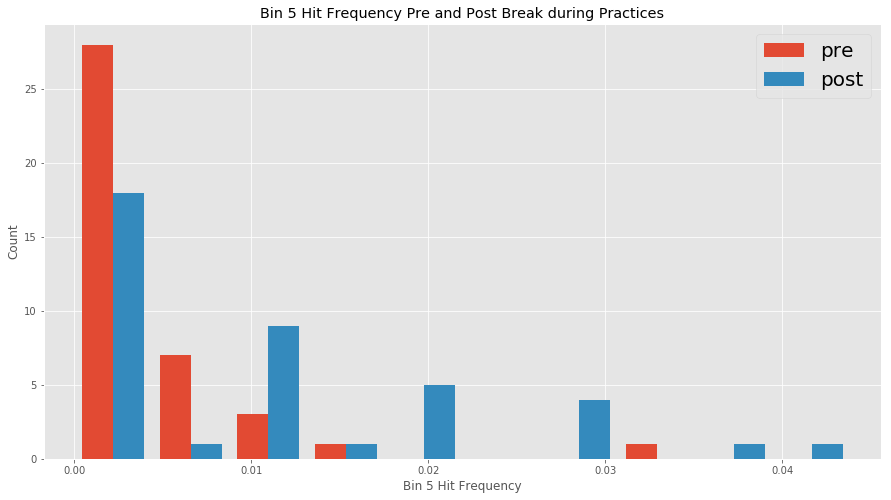

In [31]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.hist([h5.pre, h5.post], 10, histtype='bar', label=['pre', 'post'])
ax.legend(prop={'size': 20})
ax.set_title('Bin 5 Hit Frequency Pre and Post Break during Practices')
plt.xlabel('Bin 5 Hit Frequency')
plt.ylabel('Count')
plt.show()

### Game Data

In [32]:
# Do some preliminary data cleaning (eliminate those events that don't have a pre and post period)
tmp = games.groupby(['event', 'before_break', 'type', 'day'], as_index=False).sum()
for event in np.unique(tmp.event):
    if tmp[tmp.event == event].shape[0] != 2:
        tmp = tmp.drop(tmp[tmp.event == event].index)
grps = tmp.groupby('before_break')

post = (grps.get_group('post')
            .assign(minutes=lambda x: [(get_prepost_duration_by_date(durs, y.day, y.before_break, 'offensive') + 
                                        get_prepost_duration_by_date(durs, y.day, y.before_break, 'defensive'))
                                        for idx, y in x.iterrows()])
            .assign(sum24=lambda x: (x.h2+x.h3+x.h4)/x.minutes)
            .assign(h5=lambda x: x.h5/x.minutes))[['event', 'before_break', 'sum24', 'h5']]

pre = (grps.get_group('pre')
           .assign(minutes=lambda x: [(get_prepost_duration_by_date(durs, y.day, y.before_break, 'offensive') + 
                                       get_prepost_duration_by_date(durs, y.day, y.before_break, 'defensive'))
                                       for idx, y in x.iterrows()])
           .assign(sum24=lambda x: (x.h2+x.h3+x.h4)/x.minutes)
           .assign(h5=lambda x: x.h5/x.minutes))[['event', 'before_break', 'sum24', 'h5']]

#### Sum of Bins 2 - 4

In [33]:
sum24 = pd.DataFrame(np.array([pre.sum24.values, post.sum24.values]).T, columns=['pre', 'post'], index=pre.event)
display(sum24)
wilcoxon(pre.sum24, post.sum24, zero_method='pratt', correction=True)

,pre,post
event,,
Conneticut Game,2.666667,2.466667
Houston Game,2.833333,2.933333
Louisiana Game,4.133333,3.266667
Memphis Game,2.733333,2.500000
Navy Game,3.000000,3.033333
New Mexico Game,2.566667,2.033333
Oklahoma State Game,4.800000,2.400000
S Florida Game,3.200000,1.766667
S Methodist Game,2.733333,1.433333


WilcoxonResult(statistic=10.0, pvalue=0.025369859822053694)

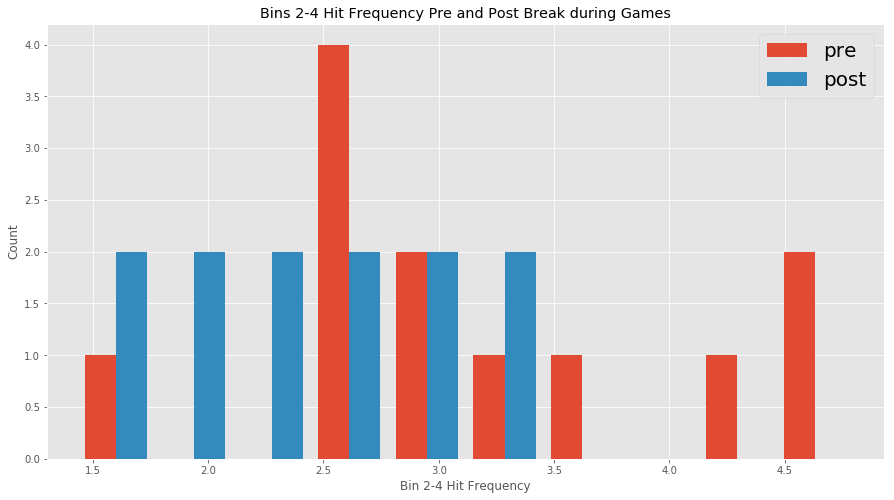

In [34]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.hist([sum24.pre, sum24.post], 10, histtype='bar', label=['pre', 'post'])
ax.legend(prop={'size': 20})
ax.set_title('Bins 2-4 Hit Frequency Pre and Post Break during Games')
plt.xlabel('Bin 2-4 Hit Frequency')
plt.ylabel('Count')
plt.show()

#### Bin 5

In [35]:
h5 = pd.DataFrame(np.array([pre.h5.values, post.h5.values]).T, columns=['pre', 'post'], index=pre.event)
display(h5)
wilcoxon(pre.h5, post.h5, zero_method='pratt', correction=True)

,pre,post
event,,
Conneticut Game,0.133333,0.300000
Houston Game,0.100000,0.133333
Louisiana Game,0.300000,0.166667
Memphis Game,0.200000,0.300000
Navy Game,0.100000,0.133333
New Mexico Game,0.100000,0.166667
Oklahoma State Game,0.266667,0.100000
S Florida Game,0.066667,0.100000
S Methodist Game,0.133333,0.000000


WilcoxonResult(statistic=37.5, pvalue=0.9374007990093649)

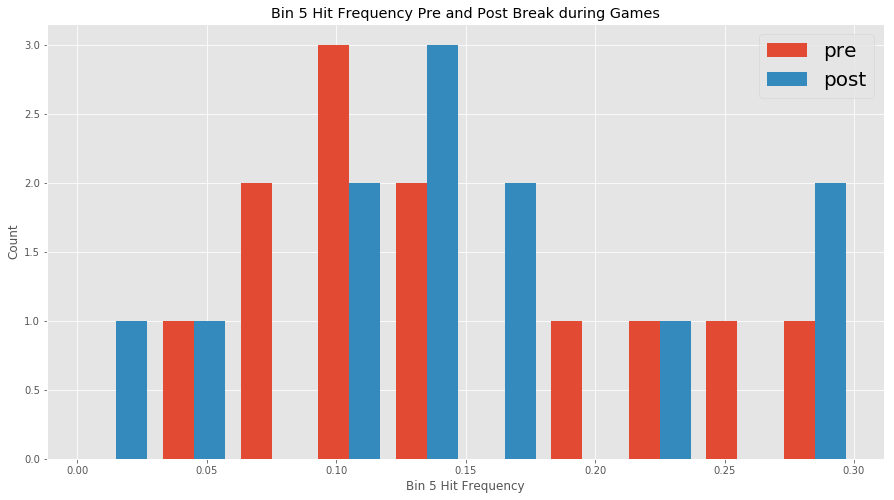

In [36]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.hist([h5.pre, h5.post], 10, histtype='bar', label=['pre', 'post'])
ax.legend(prop={'size': 20})
ax.set_title('Bin 5 Hit Frequency Pre and Post Break during Games')
plt.xlabel('Bin 5 Hit Frequency')
plt.ylabel('Count')
plt.show()

## Mann Whitney U Test

Here, we're going to be testing for the difference of distributions of the different practice types using the Mann-Whitney U test. First, we'll compile the data and normalize the hits by player-minutes as done above. The table below shows the results of this normalization process in the columns labeled `norm_sum24` and `norm_h5`.

In [37]:
utest_data = (practices.groupby(['type', 'event', 'day'], as_index=False)
          .sum()
          .assign(minutes=lambda x: [(get_total_duration_by_date(durs, y.day, 'offensive') + 
                                      get_total_duration_by_date(durs, y.day, 'defensive'))
                                      for idx, y in x.iterrows()])
          .assign(num_players=lambda x: [get_num_players_by_date(attnd, y.day, 'total') for idx, y in x.iterrows()])
          .assign(player_minutes=lambda x: x.minutes*x.num_players)
          .assign(sum24=lambda x: x.h2+x.h3+x.h4)
          .assign(norm_sum24=lambda x: x.sum24/x.player_minutes)
          .assign(norm_h5=lambda x: x.h5/x.player_minutes))
display(utest_data)
from functools import reduce
comb = utest_data[reduce(np.logical_or, [utest_data.type=='tues', utest_data.type=='wed', utest_data.type=='thurs'])].copy()
comb['type'] = 'comb'
utest_groups = pd.concat([utest_data, comb]).groupby('type')

,type,event,day,h2,h3,h4,h5,minutes,num_players,player_minutes,sum24,norm_sum24,norm_h5
0,camp,fall camp practice #1,2017-07-31,2.0,2.0,0.0,0.0,230.0,19,4370.0,4.0,0.000915,0.000000
1,camp,fall camp practice #10,2017-08-11,24.0,27.0,3.0,4.0,262.0,19,4978.0,54.0,0.010848,0.000804
2,camp,fall camp practice #11,2017-08-12,30.0,21.0,3.0,2.0,272.0,19,5168.0,54.0,0.010449,0.000387
3,camp,fall camp practice #12,2017-08-13,30.0,16.0,3.0,0.0,262.0,18,4716.0,49.0,0.010390,0.000000
4,camp,fall camp practice #13,2017-08-14,35.0,9.0,3.0,1.0,262.0,18,4716.0,47.0,0.009966,0.000212
5,camp,fall camp practice #14,2017-08-16,30.0,14.0,4.0,0.0,262.0,19,4978.0,48.0,0.009642,0.000000
6,camp,fall camp practice #17,2017-08-19,1.0,1.0,0.0,0.0,137.0,20,2740.0,2.0,0.000730,0.000000
7,camp,fall camp practice #2,2017-08-01,3.0,3.0,0.0,0.0,227.0,20,4540.0,6.0,0.001322,0.000000
8,camp,fall camp practice #3,2017-08-02,48.0,17.0,4.0,3.0,262.0,19,4978.0,69.0,0.013861,0.000603
9,camp,fall camp practice #4,2017-08-03,57.0,38.0,5.0,0.0,262.0,20,5240.0,100.0,0.019084,0.000000


### TUES vs WED

#### Sum of Bins 2-4

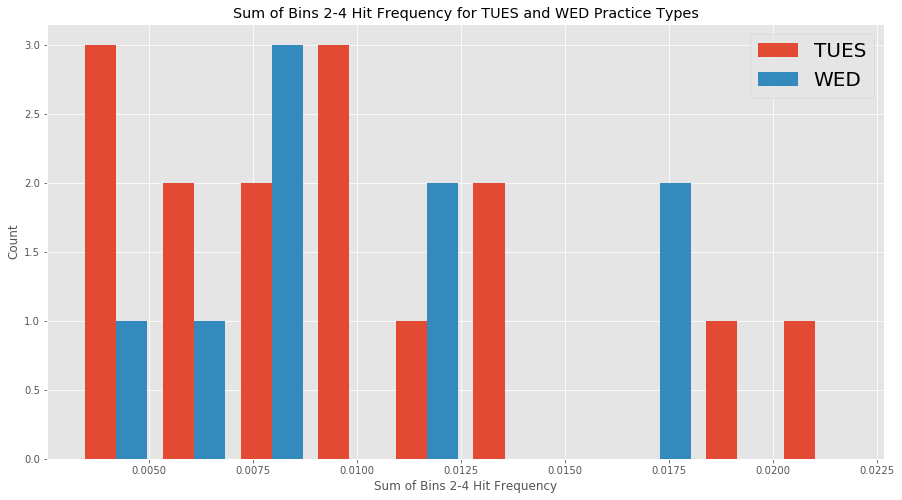

_Result_

MannwhitneyuResult(statistic=67.0, pvalue=1.0)

#### Bin 5

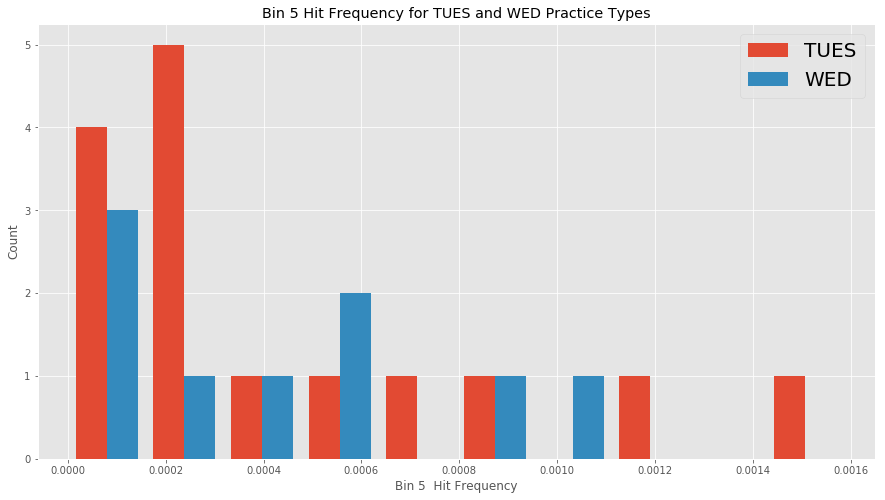

_Result_

MannwhitneyuResult(statistic=65.0, pvalue=0.90381491879526221)

### WED vs THURS

#### Sum of Bins 2-4

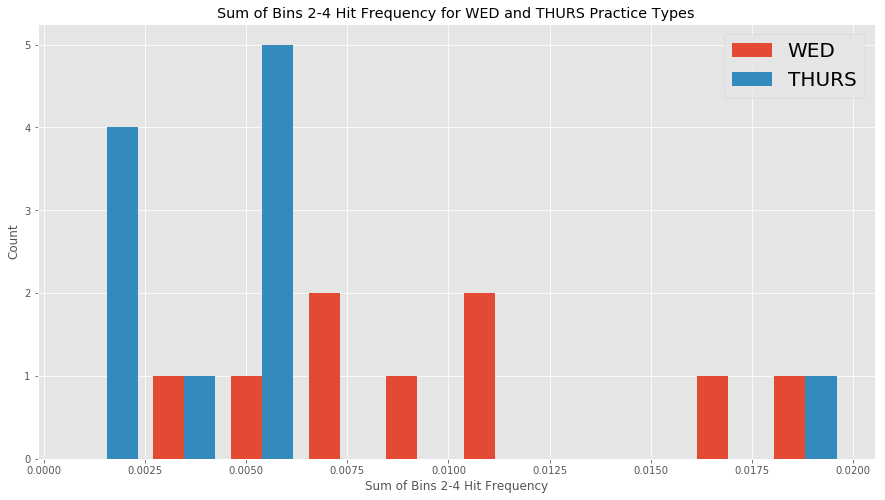

_Result_

MannwhitneyuResult(statistic=80.0, pvalue=0.022654494080089346)

#### Bin 5

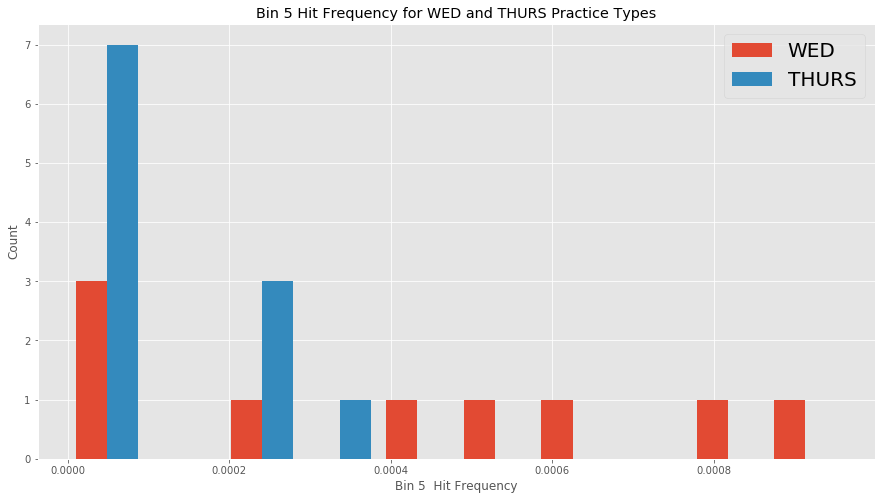

_Result_

MannwhitneyuResult(statistic=73.5, pvalue=0.056333201870602638)

### TUES vs THURS

#### Sum of Bins 2-4

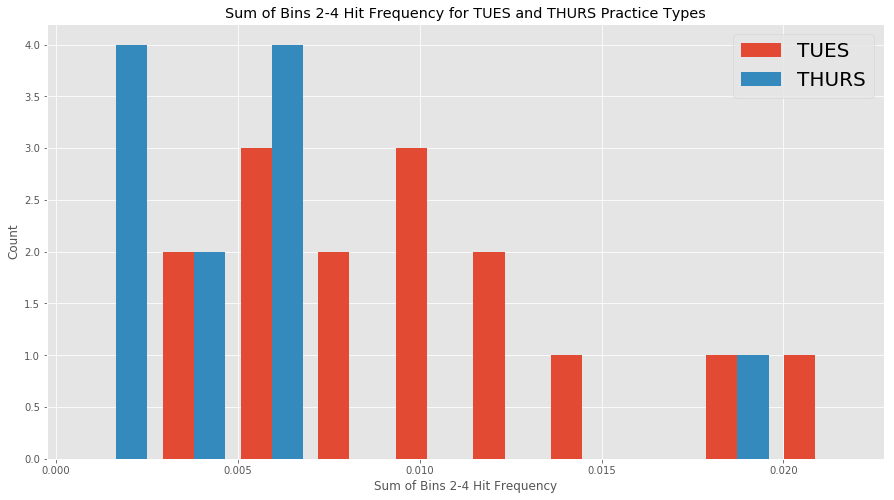

_Result_

MannwhitneyuResult(statistic=134.0, pvalue=0.0081234233042734964)

#### Bin 5

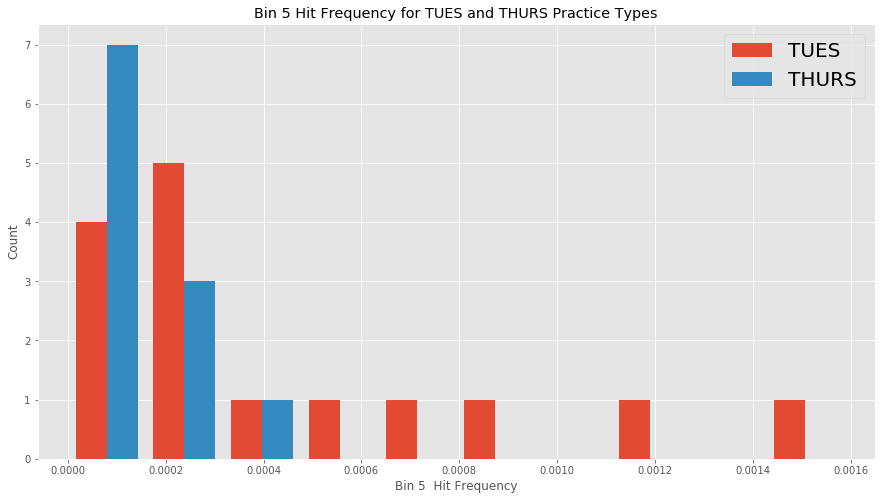

_Result_

MannwhitneyuResult(statistic=124.0, pvalue=0.026859328378869611)

### CAMP vs COMB

#### Sum of Bins 2-4

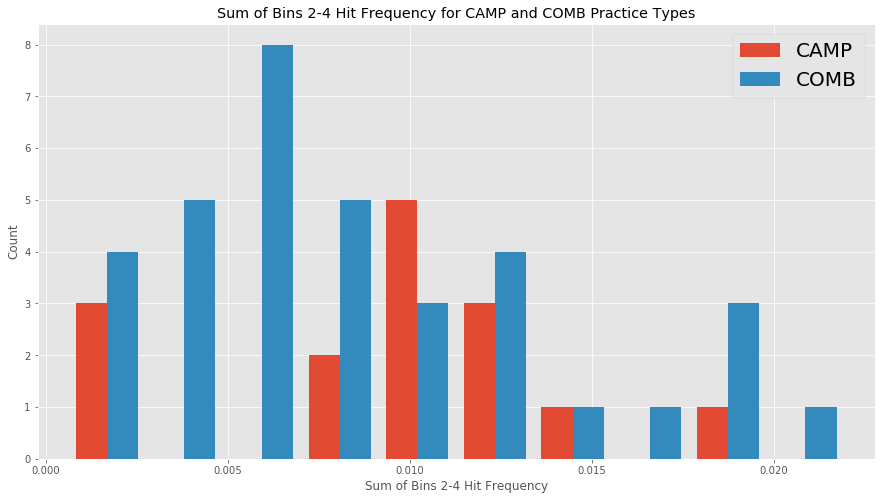

_Result_

MannwhitneyuResult(statistic=307.0, pvalue=0.35159975260191689)

#### Bin 5

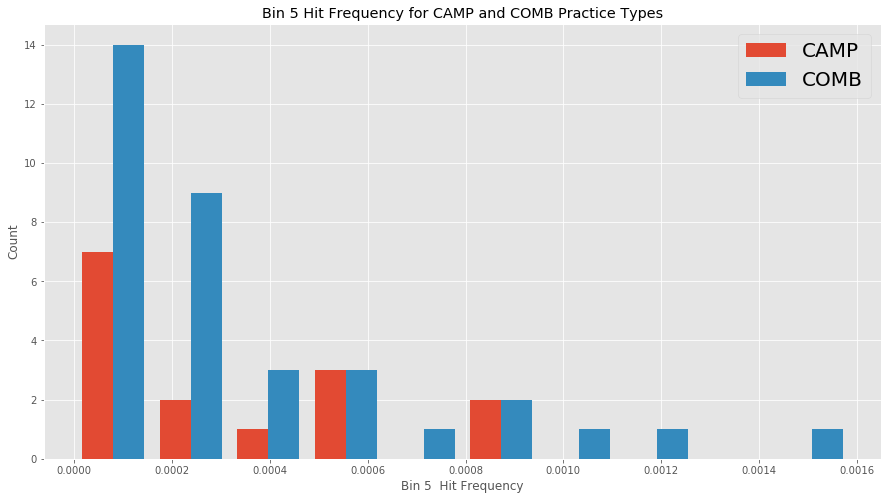

_Result_

MannwhitneyuResult(statistic=247.0, pvalue=0.74136280119599463)

In [38]:
pairs = [('tues', 'wed'), ('wed', 'thurs'), ('tues', 'thurs'), ('camp', 'comb')]
for t1, t2 in pairs:
    printmd('### {} vs {}'.format(t1.upper(), t2.upper()))
    printmd('#### Sum of Bins 2-4')
    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot()
    ax.hist([utest_groups.get_group(t1)['norm_sum24'], utest_groups.get_group(t2)['norm_sum24']], 10, histtype='bar', label=[t1.upper(), t2.upper()])
    ax.legend(prop={'size': 20})
    ax.set_title('Sum of Bins 2-4 Hit Frequency for {} and {} Practice Types'.format(t1.upper(), t2.upper()))
    plt.xlabel('Sum of Bins 2-4 Hit Frequency')
    plt.ylabel('Count')
    plt.show()
    printmd('_Result_')
    display(mannwhitneyu(utest_groups.get_group(t1)['norm_sum24'],
                 utest_groups.get_group(t2)['norm_sum24'],
                 alternative='two-sided'))
    printmd('#### Bin 5')
    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot()
    ax.hist([utest_groups.get_group(t1)['norm_h5'], utest_groups.get_group(t2)['norm_h5']], 10, histtype='bar', label=[t1.upper(), t2.upper()])
    ax.legend(prop={'size': 20})
    ax.set_title('Bin 5 Hit Frequency for {} and {} Practice Types'.format(t1.upper(), t2.upper()))
    plt.xlabel('Bin 5  Hit Frequency')
    plt.ylabel('Count')
    plt.show()
    printmd('_Result_')
    display(mannwhitneyu(utest_groups.get_group(t1)['norm_h5'],
                 utest_groups.get_group(t2)['norm_h5'],
                 alternative='two-sided'))